# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# Marginal Emissions Data Processing

This notebook covers the methodology for how to calculate marginal emission factors. These emission factors will be later used in the optimisation part of the project.

### Importing Libraries

In [1579]:
## Installing additional libraries to the environment as needed
# ! rm -rf ~/Library/Jupyter/kernels/exampleenvironment
# ! pip install seaborn
# ! pip install matplotlib
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install statsmodels
# ! pip install scipy
# ! pip install jupyterlab jupyter ipykernel matplotlib seaborn polars pyarrow matplotlib-inline
# ! pip install geopandas
# ! pip install shapely
# ! pip install pyproj

In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# Jupyter/Notebook Setup
# ────────────────────────────────────────────────────────────────────────────
%matplotlib inline
from IPython.display import display

# ────────────────────────────────────────────────────────────────────────────
# Core Data Handling
# ────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

# ────────────────────────────────────────────────────────────────────────────
# Machine Learning & Statistics
# ────────────────────────────────────────────────────────────────────────────
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import RBFSampler
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import skew, kurtosis, zscore

from feature_engine.creation import CyclicalFeatures

# ────────────────────────────────────────────────────────────────────────────
# Visualization
# ────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ────────────────────────────────────────────────────────────────────────────
# Geospatial
# ────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

# ────────────────────────────────────────────────────────────────────────────
# System & Utilities
# ────────────────────────────────────────────────────────────────────────────
import os
import re
import logging
import random
import binascii
import calendar
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any, Union, Callable, Iterable, Sequence
import json
import hashlib
from pathlib import Path
import math
from itertools import product,combinations
from copy import deepcopy
from multiprocessing import Pool, cpu_count, Manager, Lock
from multiprocessing.pool import ThreadPool
from functools import wraps
from tqdm import tqdm
from functools import partial
import inspect

# ────────────────────────────────────────────────────────────────────────────
# Logging Configuration
# ────────────────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)

## Loading Data from Local Storage

### Defining File Paths and Directories

In [1581]:
# Reminder of data directory structure and contents

# This is a redundant code block, but it is included as a reminder of the directory variables.
base_data_directory = "data"  # Base directory where the dataframes will be saved

hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")  # Directory where the dataframes will be saved
meter_save_directory = os.path.join(hitachi_data_directory, "meter_primary_files")

print("\n" + "-" * 120)
print(f"Contents of '{base_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(base_data_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(root, base_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - era5_data.parquet
  - era5/.DS_Store
  - era5/era5_reanalysis_data_2020-2025.parquet
  - era5/grib_downloads/125ae282169904325e8bc153160be150.grib
  - era5/grib_downloads/125ae282169904325e8bc153160be150.grib.47d85.idx
  - era5/grib_downloads/289f2aac241f8a158ff074a66682452e.grib
  - era5/grib_downloads/289f2aac241f8a158ff074a66682452e.grib.47d85.idx
  - era5/grib_downloads/554832a6209258041784298e5401a7ab.grib
  - era5/grib_downloads/554832a6209258041784298e5401a7ab.grib.47d85.idx
  - era5/grib_downloads/5aee58993569287064988fbc8ad385dd.grib
  - era5/grib_downloads/5aee58993569287064988fbc8ad385dd.grib.47d85.idx
  - era5/grib_downloads/5bcc58c42bdde8ce6b147b00099404bc.grib
  - era5/grib_dow

In [1582]:
# Isolate the contents of the 'save_directory' to show names of the files we want to retrieve
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' directory:\n" + "-" * 120)
for f in sorted(os.listdir(hitachi_data_directory)):
    print(f"  - {f}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data/hitachi_copy' directory:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250606_1901.parquet
  - customers_20250630_1215.parquet
  - customers_20250630_1215_optimised.parquet
  - customers_20250701_1318.parquet
  - customers_20250714_1401.parquet
  - customers_20250714_1401_optimised.parquet
  - customers_weather_mapping_20250630_1215.parquet
  - grid_and_weather_stacked_20250714_1401.parquet
  - grid_readings_20250606_1901.parquet
  - grid_readings_20250630_1215.parquet
  - grid_readings_20250701_1318.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_half_hourly.parquet
  - grid_readings_20250714_1401_half_hourly_trimmed.parquet
  - hourly_meter_data_join_with_weather_20250630_1215.parquet
  - hourly_meter_data_with_

In [ ]:
# File names copied from the output of the above code block
# only weather and grid readings (emissions from carbon tracker) are needed to calcuate marginal emissions factors.
weather_path = os.path.join(
    hitachi_data_directory, "weather_20250714_1401_optimised_iso_imputed_enriched_gap_filled_half_hourly.parquet"
)
grid_readings_path = os.path.join(
    hitachi_data_directory, "grid_readings_20250714_1401.parquet"
)

### Loading Data

In [1584]:
# Load the dataframes from the parquet files
weather_table_pldf = pl.read_parquet(weather_path)
grid_readings_table_pldf = pl.read_parquet(grid_readings_path)

In [1585]:
# Displaying the first 5 rows of each DataFrame to verify the data has been loaded correctly
print("\n" + "-" * 120)
print("Head of the 'weather_table_pldf' DataFrame:\n" + "-" * 120)
display(weather_table_pldf.head(5))

print("\n" + "-" * 120)
print("Head of the 'grid_readings_table_pldf' DataFrame:\n" + "-" * 120)
display(grid_readings_table_pldf.head(5))


------------------------------------------------------------------------------------------------------------------------
Head of the 'weather_table_pldf' DataFrame:
------------------------------------------------------------------------------------------------------------------------


weather_longitude,weather_latitude,timestamp,temperature,precipitation_mm,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,wind_speed,wind_direction,city,location,era5_longitude,era5_latitude,distance_btwn_weather_and_era5_m,gap_filling
f64,f64,datetime[μs],f32,f64,f64,f64,f32,f32,f32,f32,f32,f32,cat,struct[2],f32,f32,f64,list[struct[2]]
72.77,19.2,2020-01-01 00:00:00,17.569946,0.000852,4.513792,4.994794,0.006653,0.0,0.0,0.006653,3.823672,212.011459,"""mumbai""","{72.77,19.2}",72.75,19.25,0.053852,[]
72.77,19.2,2020-01-01 00:30:00,18.007446,0.000426,2.256896,2.497397,0.003326,0.0,0.0,0.003326,3.452406,224.168091,"""mumbai""","{72.77,19.2}",72.75,19.25,0.053852,[]
72.77,19.2,2020-01-01 01:00:00,18.444946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.081141,236.324707,"""mumbai""","{72.77,19.2}",72.75,19.25,0.053852,[]
72.77,19.2,2020-01-01 01:30:00,18.85878,0.0,0.001234,0.001366,0.006638,0.0,0.0,0.006638,2.88578,244.182526,"""mumbai""","{72.77,19.2}",72.75,19.25,0.053852,[]
72.77,19.2,2020-01-01 02:00:00,19.272614,0.0,0.002468,0.002731,0.013275,0.0,0.0,0.013275,2.69042,252.040344,"""mumbai""","{72.77,19.2}",72.75,19.25,0.053852,[]



------------------------------------------------------------------------------------------------------------------------
Head of the 'grid_readings_table_pldf' DataFrame:
------------------------------------------------------------------------------------------------------------------------


timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:10:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:15:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:20:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0
2022-01-04 17:25:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0


## Analysis

### Aggregating Grid Readings Data

In [1586]:
print("\n" + "-" * 120)
print("Columns in 'grid_readings_table_pldf':\n"+  "-" * 120)
display(grid_readings_table_pldf.columns)

print("\n" + "-" * 120)
print("Descriptive statistics of 'grid_readings_table_pldf':\n" + "-" * 120)
display((grid_readings_table_pldf.describe()))


------------------------------------------------------------------------------------------------------------------------
Columns in 'grid_readings_table_pldf':
------------------------------------------------------------------------------------------------------------------------


['timestamp',
 'thermal_generation',
 'gas_generation',
 'g_co2_per_kwh',
 'hydro_generation',
 'nuclear_generation',
 'renewable_generation',
 'tons_co2',
 'total_generation',
 'tons_co2_per_mwh',
 'demand_met',
 'net_demand']


------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of 'grid_readings_table_pldf':
------------------------------------------------------------------------------------------------------------------------


statistic,timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""561067""",561067.0,561067.0,561067.0,561067.0,561067.0,561067.0,561067.0,561067.0,561067.0,561067.0,561067.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-12 15:50:43.006628""",127192.154768,3888.086409,734.162609,17809.729132,5095.590551,17948.379313,10473.806207,171933.940173,0.734163,170732.291455,153985.560859
"""std""",null,20960.644587,1626.092321,76.569234,8655.389875,788.932396,14581.962855,1693.366616,26456.112552,0.076569,26158.803872,22143.970194
"""min""","""2020-01-01 00:00:00""",65919.0,0.0,473.856441,509.0,2275.0,478.5,5549.6103,88658.0,0.473856,87972.0,86367.0
"""25%""","""2021-05-02 17:15:00""",111703.5,2563.5,681.198053,10080.0,4443.0,6687.0,9218.1949,153264.0,0.681198,152233.5,138341.0
"""50%""","""2022-09-17 05:50:00""",128416.0,3465.0,734.538248,16946.0,5123.5,12756.0,10550.7235,172266.5,0.734538,170895.0,153908.0
"""75%""","""2024-01-21 10:35:00""",143172.5,4938.0,797.420435,24889.5,5572.5,25095.0,11749.5183,192469.0,0.79742,190909.5,169378.5
"""max""","""2025-06-03 23:55:00""",179602.0,13125.0,899.116153,45871.5,7085.0,82136.0,14812.6736,258643.0,0.899116,256491.0,225340.0


In [1587]:
# Stats:
print(f"Time Start: {grid_readings_table_pldf['timestamp'].min()}")
print(f"Time End: {grid_readings_table_pldf['timestamp'].max()}")

Time Start: 2020-01-01 00:00:00
Time End: 2025-06-03 23:55:00


#### Helper Functions

In [ ]:
def emission_factor_year_mapper(factors: dict, col_name: str):
    """
    Creates a mapping function to ensure that emission factors get mapped to the exact or most relevant year available.

    Parameters:
    ----------
    factors: dict
        Dictionary mapping years to emission factors
    col_name: str
        Name of the column to be created in the resulting DataFrame

    Returns:
    -------
    pl.DataFrame
        A Polars DataFrame with 'year' and the corresponding emission factor for each year.

    """
    # Get years from the keys of the factors dictionary
    years = sorted(factors.keys())
    # get min and max years
    min_y, max_y = years[0], years[-1]
    # back‐fill missing years
    filled = {}
    curr = factors[max_y]
    for y in reversed(range(min_y, max_y + 1)):
        curr = factors.get(y, curr)
        filled[y] = curr

    # return dataframe with years and their corresponding emission factors
    return pl.DataFrame({
            "year": list(filled.keys()),
            col_name: list(filled.values()),
    })

In [ ]:
def add_emission_factors(df: pl.DataFrame, thermal_factors: dict, gas_factors: dict, timestamp_col: str = "timestamp") -> pl.DataFrame:
    """
    Adds emission factors to a DataFrame based on the year extracted from a timestamp column.
    The function extracts the year from the timestamp, creates mapping tables for thermal and gas emission factors,
    and joins these tables to the original DataFrame. It ensures that any years outside the range of the provided factors are replaced with the boundary factor values.

    Parameters:
    ----------
    df: pl.DataFrame
        The DataFrame to which emission factors will be added.
    thermal_factors: dict
        Dictionary mapping years to thermal emission factors (in tonnes CO2 per MWh).
    gas_factors: dict
        Dictionary mapping years to gas emission factors (in tonnes CO2 per MWh).
    timestamp_col: str, optional
        The name of the column containing timestamps from which the year will be extracted. Default is "timestamp".

    Returns:
    -------
    pl.DataFrame
        The original DataFrame with additional columns for thermal and gas emission factors, adjusted for the year extracted from the timestamp.
        The columns added are:
        - "thermal_emission_factor_tonnes_CO2_per_mwh": Thermal emission factor for
            the year extracted from the timestamp.
        - "gas_emission_factor_tonnes_CO2_per_mwh": Gas emission factor for
            the year extracted from the timestamp.

    """
    # Extract year
    df = df.with_columns(pl.col(timestamp_col).dt.year().alias("year"))

    # Build two DataFrames for thermal and gas emission factors
    tm = emission_factor_year_mapper(thermal_factors, "thermal_emission_factor_tonnes_CO2_per_mwh")
    gm = emission_factor_year_mapper(gas_factors,     "gas_emission_factor_tonnes_CO2_per_mwh")

    # Left join the emission factor DataFrames on the year
    df = df.join(tm, on="year", how="left").join(gm, on="year", how="left")

    # Clip any years outside the original factor range
    min_ty, max_ty = min(thermal_factors), max(thermal_factors)
    min_gy, max_gy = min(gas_factors),     max(gas_factors)

    df = df.with_columns([
        # if year < min or year > max, replace with boundary factor
        pl.when(pl.col("year") < min_ty).then(thermal_factors[min_ty])
          .when(pl.col("year") > max_ty).then(thermal_factors[max_ty])
          .otherwise(pl.col("thermal_emission_factor_tonnes_CO2_per_mwh"))
          .alias("thermal_emission_factor_tonnes_CO2_per_mwh"),

        pl.when(pl.col("year") < min_gy).then(gas_factors[min_gy])
          .when(pl.col("year") > max_gy).then(gas_factors[max_gy])
          .otherwise(pl.col("gas_emission_factor_tonnes_CO2_per_mwh"))
          .alias("gas_emission_factor_tonnes_CO2_per_mwh"),
    ])

    return df

In [ ]:
def calculate_emissions(df: pl.DataFrame, interval_minutes: int = 5) -> pl.DataFrame:
    """
    Calculate emissions using year-specific emission factors and specified time interval.

    Parameters:
    ----------
    df : pl.DataFrame
        Input DataFrame containing generation data and emission factors
        with columns: thermal_generation, gas_generation, thermal_emission_factor_tonnes_CO2_per_mwh, gas_emission_factor_tonnes_CO2_per_mwh
        and a timestamp column.

    interval_minutes : int, optional
        Time interval in minutes for emissions calculation (default: 5). Valid values are 5 or 30.

    Returns:
    -------
    pl.DataFrame
        DataFrame with calculated emissions columns for thermal and gas generation

    """
    if interval_minutes not in [5, 30]:
        raise ValueError("interval_minutes must be either 5 or 30")

    interval_factor = interval_minutes / 60  # Convert to fraction of an hour

    return df.with_columns([
        (pl.col("thermal_generation") * pl.col("thermal_emission_factor_tonnes_CO2_per_mwh") * interval_factor)
        .alias("thermal_emissions_tonnes_CO2"),

        (pl.col("gas_generation") * pl.col("gas_emission_factor_tonnes_CO2_per_mwh") * interval_factor)
        .alias("gas_emissions_tonnes_CO2")
    ])


In [ ]:
def calculate_year_specific_emissions(
    df: pl.DataFrame,
    thermal_factors: dict,
    gas_factors: dict,
    original_emissions_col: str = "tons_co2",
    interval_minutes: int = 5,
    timestamp_col: str = "timestamp"
) -> pl.DataFrame:
    """
    Wrapper function to calculate year-specific emissions and compare with original emissions.

    Parameters:
    ----------
    df: pl.DataFrame
        Input DataFrame containing generation and emissions data
    thermal_factors: dict
        Dictionary mapping years to thermal emission factors
    gas_factors: dict
        Dictionary mapping years to gas emission factors
    original_emissions_col: str, optional
        Name of the original emissions column (default: "tons_co2")
    interval_minutes: int, optional
        Time interval in minutes for emissions calculation (default: 5). Valid values are 5
        or 30.
    timestamp_col: str, optional
        Name of the timestamp column (default: "timestamp")

    Returns:
    -------
    pl.DataFrame
        DataFrame with calculated emissions and comparison metrics
    """
    # 1) add factors
    df = add_emission_factors(df, thermal_factors, gas_factors, timestamp_col)
    # 2) calc thermal/gas emissions
    df = calculate_emissions(df, interval_minutes)

    # 3a) compute total
    df = df.with_columns(
        (pl.col("thermal_emissions_tonnes_CO2") + pl.col("gas_emissions_tonnes_CO2"))
          .alias("tonnes_CO2_emissions_year_specific")
    )
    # 3b) compute diff & relative
    df = df.with_columns([
        (pl.col("tonnes_CO2_emissions_year_specific") - pl.col(original_emissions_col))
          .alias("CO2_difference"),
        ((pl.col("tonnes_CO2_emissions_year_specific") - pl.col(original_emissions_col))
          / pl.col(original_emissions_col))
          .alias("relative_CO2_difference")
    ])

    # 4) drop intermediates
    return df.drop([
        "thermal_emissions_tonnes_CO2",
        "gas_emissions_tonnes_CO2",
        "year"
    ])

#### Validating Emissions Calculations

In [1592]:
display(
    grid_readings_table_pldf.head(1)
)  # Display the first 5 rows of the grid_readings table

timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0


In [1593]:
thermal_generation = (grid_readings_table_pldf.select(pl.col("thermal_generation")).head(1).item())
gas_generation = (grid_readings_table_pldf.select(pl.col("gas_generation")).head(1).item())
hydro_generation = (grid_readings_table_pldf.select(pl.col("hydro_generation")).head(1).item())
nuclear_generation = (grid_readings_table_pldf.select(pl.col("nuclear_generation")).head(1).item())
renewable_generation = (grid_readings_table_pldf.select(pl.col("renewable_generation")).head(1).item())
fossil_fuel_generation = thermal_generation + gas_generation
print(f"\nFossil Fuel Generation: {fossil_fuel_generation} MWh")

total_generation = (
    thermal_generation
    + gas_generation
    + hydro_generation
    + nuclear_generation
    + renewable_generation
)
print(f"\nTotal Generation (calculated): {total_generation} MWh")

total_generation_from_table = (grid_readings_table_pldf.select(pl.col("total_generation")).head(1).item())
print(f"Total Generation (from table): {total_generation_from_table} MWh")

emission_factor = (grid_readings_table_pldf.select(pl.col("tons_co2_per_mwh")).head(1).item())
print(f"\nEmission Factor (from table): {emission_factor} tons CO2/MWh")

calculated_emissions_all = total_generation * emission_factor
print(f"\nCalculated Total Emissions: {calculated_emissions_all} tons CO2 (NOT adjusted for hour to 5-minute conversion)")
print(f"Calculated Total Emissions: {calculated_emissions_all / 12} tons CO2 (adjusted for hour to 5-minute conversion)")
print(f"Total Emissions from table: {grid_readings_table_pldf.select(pl.col('tons_co2')).head(1).item()} tons CO2")


Fossil Fuel Generation: 139103.0 MWh

Total Generation (calculated): 164327.0 MWh
Total Generation (from table): 164327.0 MWh

Emission Factor (from table): 0.8155730878066296 tons CO2/MWh

Calculated Total Emissions: 134020.67880000002 tons CO2 (NOT adjusted for hour to 5-minute conversion)
Calculated Total Emissions: 11168.389900000002 tons CO2 (adjusted for hour to 5-minute conversion)
Total Emissions from table: 11168.389900000002 tons CO2


From the above we can see that we obviously need to account for the difference in the time for the emission factor and the data collection.
* The emission factor is presented in tons of CO2 per mega-watt-**hour**
* The data is collected every **5 minutes** and represents total generation over that time period
* Therefore we must include a / 12 in the calculations of emissions

This is an important point to keep in mind because this is a simple mistake easily overlooked during data aggregation, and could lead to incorrect results if not done properly.

We know from the documentation that the emission factors used are from 2018, so lets run a few reproducability tests here.
Note that we will be using the aggregate emission factors for each fuel source here. This is what the documentation on https://carbontracker.in/ says is used.

This is an important disctinction from using the per capacity emission factors which are broken down in the excel file in the "CDM – CO2 Baseline Database" found at <https://cea.nic.in/cdm-co2-baseline-database/?lang=en>

In [1594]:
# Emission factors for coal and gas for 2023 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_20.0.pdf
# Coal = 0.969 tCO2/MWh,    Gas = 0.451 tCO2/MWh

# Emission factors for coal and gas for 2022 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_19.0.pdf
# Coal = 0.978 tCO2/MWh,    Gas = 0.478 tCO2/MWh

# Emission factors for coal and gas for 2021 can be found here:  https://cea.nic.in/wp-content/uploads/2021/03/User_Guide_Version_18.0.pdf
# Coal = 0.975 tCO2/MWh,    Gas = 0.465 tCO2/MWh

# Emission factors for coal and gas for 2020 can be found here:  https://cea.nic.in/wp-content/uploads/tpe___cc/2022/02/User_Guide__ver_17_2021.pdf
# Coal = 0.97 tCO2/MWh,    Gas = 0.42 tCO2/MWh

# Emission factors for coal and gas for 2018 (stated in methodology as used for the table) can be found here: https://cea.nic.in/wp-content/uploads/baseline/2020/07/user_guide_ver14.pdf
# Coal = 0.97 tCO2/MWh,    Gas = 0.45 tCO2/MWh

# Emission factors for coal and gas for 2017 (stated in methodology as used for the table) can be found here: https://cea.nic.in/wp-content/uploads/baseline/2020/07/user_guide_ver14.pdf
# Coal = 0.97 tCO2/MWh,    Gas = 0.45 tCO2/MWh

In [1595]:
emission_factor_coal_2018 = 0.97  # Emission factor for coal in tCO2/MWh
emission_factor_gas_2018 = 0.45  # Emission for gas in tCO2/MWh

emission_factor_coal_2022 = 0.978  # Emission factor for coal in tCO2/MWh
emission_factor_gas_2022 = 0.478  # Emission for gas in tCO2/MWh

# Calculate the emissions for coal and gas
total_emissions_2018_factors = (thermal_generation * emission_factor_coal_2018) + (
    gas_generation * emission_factor_gas_2018
)
total_emissions_2022_factors = (thermal_generation * emission_factor_coal_2022) + (
    gas_generation * emission_factor_gas_2022
)

print(f"Total Emissions : {(total_emissions_2018_factors)/12:.3f} tCO2  (calculated - 2018 factors)")
print(f"Total Emissions : {total_emissions_2022_factors/12:.3f} tCO2  (calculated - 2022 factors)")
print(f"Total Emissions : {grid_readings_table_pldf.select(pl.col('tons_co2')).head(1).item():.3f} tCO2  (from table)")

Total Emissions : 11118.449 tCO2  (calculated - 2018 factors)
Total Emissions : 11216.020 tCO2  (calculated - 2022 factors)
Total Emissions : 11168.390 tCO2  (from table)


We certainly expect the emissions calculated using the 2022 emission factors to be different, but it is surprising to see that the 2018 factors are different. The values should be the exact same as we are using those exact values from the report. What we are instead noticing is that the emissions using the 2018 factors are undercounting.

Next steps - run some tests to calculate the emissions of every 5 minute period in the table using the 2018 annual emission factors, then compare this to the provided emissions.

We should attempt to use the emission factors from the relevant year, but if there are large discrepancies and errors in the data and what we expect, then we should rethink our approach, so we will examine the error of these calculations first

In [1596]:
# Display the first row of the grid readings table
display(grid_readings_table_pldf.head(1))

timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0


In [1597]:
grid_readings_table_adjusted_pldf = grid_readings_table_pldf.with_columns(
    [
        (
            (
                (pl.col("thermal_generation") * emission_factor_coal_2018)
                + (pl.col("gas_generation") * emission_factor_gas_2018)
            )
            / 12
        ).alias("total_emissions_tCO2_2018_external_factors")
    ]
)

grid_readings_table_adjusted_pldf = grid_readings_table_adjusted_pldf.with_columns(
    [
        (
            pl.col("total_emissions_tCO2_2018_external_factors") - pl.col("tons_co2")
        ).alias("error"),
        (
            (pl.col("total_emissions_tCO2_2018_external_factors") - pl.col("tons_co2"))
            / pl.col("tons_co2")
        ).alias("error_ratio"),
    ]
)
# Display the first row of the adjusted grid readings table
grid_readings_table_adjusted_pldf.head(1)

timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand,total_emissions_tCO2_2018_external_factors,error,error_ratio
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,11118.449167,-49.940733,-0.004472


In [1598]:
thermal_gen_factors = {
    2023: 0.969,
    2022: 0.978,
    2021: 0.975,
    2020: 0.97,
}  # Emission factors for coal in tCO2/MWh
gas_gen_factors = {
    2023: 0.451,
    2022: 0.478,
    2021: 0.465,
    2020: 0.42,
}  # Emission factors for gas in tCO2/MWh

In [1599]:
# Apply the wrapper function
grid_readings_table_pldf = calculate_year_specific_emissions(
    grid_readings_table_pldf,
    thermal_factors=thermal_gen_factors,
    gas_factors=gas_gen_factors,
    interval_minutes=5
)

# Display results
display(grid_readings_table_pldf.head(5))

timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:10:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:15:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:20:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:25:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265


In [1600]:
# Extract year from timestamp
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    pl.col("timestamp").dt.year().alias("year")
)
# Add emission factors to grid_readings_table_pldf based on the year
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    pl.col("timestamp").dt.year().alias("year"),  # Extract year directly from datetime
    (
        pl.when(pl.col("year") == 2020)
        .then(thermal_gen_factors[2020])
        .when(pl.col("year") == 2021)
        .then(thermal_gen_factors[2021])
        .when(pl.col("year") == 2022)
        .then(thermal_gen_factors[2022])
        .when(pl.col("year") == 2023)
        .then(thermal_gen_factors[2023])
        .otherwise(thermal_gen_factors[2023])
    ).alias("thermal_emission_factor_tonnes_CO2_per_mwh"),
    (
        pl.when(pl.col("year") == 2020)
        .then(gas_gen_factors[2020])
        .when(pl.col("year") == 2021)
        .then(gas_gen_factors[2021])
        .when(pl.col("year") == 2022)
        .then(gas_gen_factors[2022])
        .when(pl.col("year") == 2023)
        .then(gas_gen_factors[2023])
        .otherwise(gas_gen_factors[2023])
    ).alias("gas_emission_factor_tonnes_CO2_per_mwh"),
)

# Retrieve the unique values of the emission factors (we expect to see 2 because the data only covers 2022 and 2023)
unique_emission_factors = grid_readings_table_pldf.select(
    pl.col("thermal_emission_factor_tonnes_CO2_per_mwh")
    .unique()
    .alias("unique_thermal_emission_factors"),
    pl.col("gas_emission_factor_tonnes_CO2_per_mwh")
    .unique()
    .alias("unique_gas_emission_factors"),
)
print("\n" + "-" * 120)
print("Unique emission factors in 'grid_readings_table_pldf':\n" + "-" * 120)
print(unique_emission_factors)


------------------------------------------------------------------------------------------------------------------------
Unique emission factors in 'grid_readings_table_pldf':
------------------------------------------------------------------------------------------------------------------------
shape: (4, 2)
┌─────────────────────────────────┬─────────────────────────────┐
│ unique_thermal_emission_factor… ┆ unique_gas_emission_factors │
│ ---                             ┆ ---                         │
│ f64                             ┆ f64                         │
╞═════════════════════════════════╪═════════════════════════════╡
│ 0.969                           ┆ 0.42                        │
│ 0.97                            ┆ 0.451                       │
│ 0.975                           ┆ 0.465                       │
│ 0.978                           ┆ 0.478                       │
└─────────────────────────────────┴─────────────────────────────┘


In [1601]:
# Compute emission factors for each relevant year
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    (
        pl.col("thermal_generation")
        * pl.col("thermal_emission_factor_tonnes_CO2_per_mwh")
        * (1 / 12)
    ).alias(
        "thermal_emissions_tonnes_CO2"
    ),  # remember 1/12 is to adjust for 5-minute intervals
    (
        pl.col("gas_generation")
        * pl.col("gas_emission_factor_tonnes_CO2_per_mwh")
        * (1 / 12)
    ).alias(
        "gas_emissions_tonnes_CO2"
    ),  # remember 1/12 is to adjust for 5-minute intervals
)

# Consolidate totals, differences, and drop unnecessary columns
grid_readings_table_pldf = grid_readings_table_pldf.with_columns(
    (
        (pl.col("thermal_emissions_tonnes_CO2") + pl.col("gas_emissions_tonnes_CO2"))
    ).alias("tonnes_CO2_emissions_year_specific"),
    (
        (pl.col("thermal_emissions_tonnes_CO2") + pl.col("gas_emissions_tonnes_CO2"))
        - pl.col("tons_co2")
    ).alias("CO2_difference"),
    (
        (
            (
                pl.col("thermal_emissions_tonnes_CO2")
                + pl.col("gas_emissions_tonnes_CO2")
            )
            - pl.col("tons_co2")
        )
        / pl.col("tons_co2")
    ).alias("relative_CO2_difference"),
).drop(["thermal_emissions_tonnes_CO2", "gas_emissions_tonnes_CO2", "year"])

# Display the first few rows of the adjusted grid readings table
display(grid_readings_table_pldf.head(5))

timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:10:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:15:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:20:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265
2022-01-04 17:25:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265


#### Aggregating Data

There are a few important things we must note about our data before we perform these aggregations:
1. Regarding the units of the generation fields.
    * Each of these columns are in MW.
        * This is according to the website where this data was originally sourced (https://carbontracker.in/)
    * It is important that this is a measurement of power, which is the rate at which energy is used/transmitted (MW = Mega Watts, Watt = Joules / Second)
    * Therefore when transforming data to higher level time frequencies (i.e. from 5 minute to 30 minute intervals), we need to AVERAGE and not AGGREGATE these values.

2. Regarding the interpretation of time:
    * Each reading is aggregated back, meaning that data from 09:55-10:00 would be recorded as 09:55.
    * This is different from the standard convention for meter readings where the time marks the END of the read period
        * That is data for 09:55 would be that from 09:50 to 09:55
        * https://law.resource.org/pub/in/bis/S05/is.15959.2011.pdf (page 17 - table 23 - note 3)
    * This means that we simply have to adjust the time and then ensure any aggregations that we do use the same methodology. That being that the time for which the data is stored represents the end of that time block/interval in which the data was collected.


In [1602]:
# Half-hourly aggregation

# Adjusted timestamp
# - shift each of the timestamps 5 minutes forward to align with the convention of aggregating meter readings (data recorded at end time of interval)
grid_readings_table_pldf = (
    grid_readings_table_pldf.with_columns(
        (pl.col("timestamp") + pl.duration(minutes=5)).alias("end_timestamp")
    )
)
# View the results to verify the adjustment
display(grid_readings_table_pldf.head(5))


timestamp,thermal_generation,gas_generation,g_co2_per_kwh,hydro_generation,nuclear_generation,renewable_generation,tons_co2,total_generation,tons_co2_per_mwh,demand_met,net_demand,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,end_timestamp
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
2022-01-04 17:05:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265,2022-01-04 17:10:00
2022-01-04 17:10:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265,2022-01-04 17:15:00
2022-01-04 17:15:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265,2022-01-04 17:20:00
2022-01-04 17:20:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265,2022-01-04 17:25:00
2022-01-04 17:25:00,136202.0,2901.0,815.573088,10113.0,5211.0,9900.0,11168.3899,164327.0,0.815573,162948.0,154427.0,0.978,0.478,11216.0195,47.6296,0.004265,2022-01-04 17:30:00


In [ ]:
# Now we will aggregate the grid readings to half-hourly intervals.

# Ideally we'd use dt.ceil to round the timestamp UP to the next halfhour.
# Unfortunately this is not yet implemented in polars, so we have to do this manually.
# We accomplish this by adding 29 minutes and 59 seconds to each reading, and then using
# truncate function (which IS supported) to round readings down.
# This is important because meter readings are aggregated UP to the next half-hour, so we need
# to ensure that we are following the same convention.

grid_readings_half_hourly_pldf = (
    grid_readings_table_pldf.with_columns(
        (pl.col("end_timestamp") + pl.duration(minutes=29, seconds=59))
            .dt.truncate("30m")
            .alias("timestamp")
        )
    .group_by("timestamp")
    .agg(
        [
            # Average generation values for each type of generation
            pl.col("thermal_generation").mean().alias("thermal_generation"),
            pl.col("gas_generation").mean().alias("gas_generation"),
            pl.col("hydro_generation").mean().alias("hydro_generation"),
            pl.col("nuclear_generation").mean().alias("nuclear_generation"),
            pl.col("renewable_generation").mean().alias("renewable_generation"),
            pl.col("total_generation").mean().alias("total_generation"),

            # Aggregate the calculated emissions
            pl.col("tons_co2").sum().alias("tons_co2"),
            pl.col("tonnes_CO2_emissions_year_specific").sum().alias(
                "tonnes_CO2_emissions_year_specific"
            ),
            pl.col("CO2_difference").sum().alias("CO2_difference"),

            # Average the relative difference and emission factors.
            pl.col("relative_CO2_difference").mean().alias("relative_CO2_difference"),
            pl.col("g_co2_per_kwh").mean().alias("g_co2_per_kwh"),
            pl.col("tons_co2_per_mwh").mean().alias(
                "tons_co2_per_mwh"),
            pl.col("thermal_emission_factor_tonnes_CO2_per_mwh").mean().alias(
                "thermal_emission_factor_tonnes_CO2_per_mwh"),
            pl.col("gas_emission_factor_tonnes_CO2_per_mwh").mean().alias(
                "gas_emission_factor_tonnes_CO2_per_mwh"),
        ]
    )
    .sort("timestamp")
)

# Viewing the results of the aggregation
display(grid_readings_half_hourly_pldf.sort("timestamp").head(-5))

timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-01 00:30:00,99390.5,4244.5,7147.416667,4268.75,7288.083333,122339.25,49378.0641,49095.7375,-282.3266,-0.005718,807.233573,0.807234,0.97,0.42
2020-01-01 01:00:00,98136.75,4238.583333,6804.833333,4271.583333,7149.75,120601.5,48765.90585,48486.42625,-279.4796,-0.005731,808.716464,0.808716,0.97,0.42
2020-01-01 01:30:00,96729.833333,4233.5,6432.833333,4264.333333,6897.0,118557.5,48079.3123,47803.004167,-276.308133,-0.005747,811.070353,0.81107,0.97,0.42
2020-01-01 02:00:00,95512.0,4253.666667,6589.166667,4261.5,6460.75,117077.083333,47490.5214,47216.59,-273.9314,-0.005768,811.271443,0.811271,0.97,0.42
2020-01-01 02:30:00,94471.5,4254.25,6699.0,4258.666667,6116.166667,115799.583333,46983.72105,46712.07,-271.65105,-0.005782,811.465373,0.811465,0.97,0.42
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-06-03 19:30:00,145225.0,4387.916667,26097.5,6247.333333,22133.333333,204091.083333,71740.90125,71350.987708,-389.913542,-0.005435,703.037346,0.703037,0.969,0.451
2025-06-03 20:00:00,147231.916667,4774.333333,28672.0,6253.416667,20633.333333,207565.0,72805.6148,72410.475792,-395.139008,-0.005427,701.51942,0.701519,0.969,0.451
2025-06-03 20:30:00,147424.166667,4916.75,27858.416667,6246.0,19792.25,206237.583333,72931.32275,72535.735875,-395.586875,-0.005424,707.258067,0.707258,0.969,0.451


In [1604]:
grid_readings_half_hourly_filepath = grid_readings_path.replace(".parquet", "_half_hourly.parquet")

grid_readings_half_hourly_pldf.write_parquet(
grid_readings_half_hourly_filepath,
    compression="snappy",
    statistics=True,
)

In [1605]:
grid_readings_half_hourly_pldf_reload = pl.read_parquet(grid_readings_half_hourly_filepath)

display(grid_readings_half_hourly_pldf_reload.head(5))
display(grid_readings_half_hourly_pldf_reload.describe())


timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-01-01 00:30:00,99390.5,4244.5,7147.416667,4268.75,7288.083333,122339.25,49378.0641,49095.7375,-282.3266,-0.005718,807.233573,0.807234,0.97,0.42
2020-01-01 01:00:00,98136.75,4238.583333,6804.833333,4271.583333,7149.75,120601.5,48765.90585,48486.42625,-279.4796,-0.005731,808.716464,0.808716,0.97,0.42
2020-01-01 01:30:00,96729.833333,4233.5,6432.833333,4264.333333,6897.0,118557.5,48079.3123,47803.004167,-276.308133,-0.005747,811.070353,0.81107,0.97,0.42
2020-01-01 02:00:00,95512.0,4253.666667,6589.166667,4261.5,6460.75,117077.083333,47490.5214,47216.59,-273.9314,-0.005768,811.271443,0.811271,0.97,0.42
2020-01-01 02:30:00,94471.5,4254.25,6699.0,4258.666667,6116.166667,115799.583333,46983.72105,46712.07,-271.65105,-0.005782,811.465373,0.811465,0.97,0.42


statistic,timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""93839""",93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-12 22:25:35.291296""",127200.059801,3886.162731,17812.131983,5095.899919,17970.531984,171964.786418,62623.291248,62455.772893,-167.518355,-0.002577,734.074932,0.734075,0.971932,0.452692
"""std""",null,20934.861607,1623.835235,8642.4304,788.132424,14566.821846,26426.823912,10446.593558,10372.93502,263.699483,0.004145,76.483081,0.076483,0.003597,0.01858
"""min""","""2020-01-01 00:30:00""",66097.833333,21.0,2516.0,2281.083333,495.083333,95950.333333,8329.1386,8339.84,-474.247783,-0.007148,474.849779,0.47485,0.969,0.42
"""25%""","""2021-05-04 03:00:00""",111737.666667,2563.83334,10103.916667,4444.0,6713.083333,153326.583333,55129.0361,55049.9275,-379.822317,-0.005488,681.225688,0.681226,0.969,0.451
"""50%""","""2022-09-16 17:00:00""",128416.416667,3459.416667,16943.75,5124.25,12806.75,172319.083333,63135.60085,63054.666083,-315.974067,-0.005453,734.434972,0.734435,0.97,0.451
"""75%""","""2024-01-21 04:30:00""",143151.083333,4935.75,24872.25,5570.666667,25118.916667,192468.583333,70428.10055,70193.303583,70.4081,0.001205,797.191299,0.797191,0.975,0.465
"""max""","""2025-06-04 00:00:00""",177508.083333,12915.75,43162.083333,7070.0,81927.666667,251763.666667,88742.75695,88268.509167,342.836017,0.00472,895.084397,0.895084,0.978,0.478


### Data Prep

#### Initial Information

In [1606]:
# Isolate the contents of the 'save_directory' to show names of the files we want to retrieve
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' directory:\n" + "-" * 120)
for f in sorted(os.listdir(hitachi_data_directory)):
    print(f"  - {f}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data/hitachi_copy' directory:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250606_1901.parquet
  - customers_20250630_1215.parquet
  - customers_20250630_1215_optimised.parquet
  - customers_20250701_1318.parquet
  - customers_20250714_1401.parquet
  - customers_20250714_1401_optimised.parquet
  - customers_weather_mapping_20250630_1215.parquet
  - grid_and_weather_stacked_20250714_1401.parquet
  - grid_readings_20250606_1901.parquet
  - grid_readings_20250630_1215.parquet
  - grid_readings_20250701_1318.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_half_hourly.parquet
  - grid_readings_20250714_1401_half_hourly_trimmed.parquet
  - hourly_meter_data_join_with_weather_20250630_1215.parquet
  - hourly_meter_data_with_

In [1607]:
me_grid_readings_filename = "grid_readings_20250714_1401_half_hourly"
me_grid_readings_filepath = os.path.join(hitachi_data_directory, me_grid_readings_filename + ".parquet")

me_weather_filename = "weather_20250714_1401_optimised_iso_imputed_enriched_gap_filled_half_hourly"
me_weather_filepath = os.path.join(hitachi_data_directory, me_weather_filename + ".parquet")


In [1608]:
me_grid_readings_pldf = pl.read_parquet(me_grid_readings_filepath)
me_weather_pldf = pl.read_parquet(me_weather_filepath)

In [ ]:
print("\n" + "-" * 120)
print("Columns in the Grid Readings Dataset [me_grid_readings_pldf]:\n" + "-" * 120)
display(me_grid_readings_pldf.columns)
print()

print("\n" + "-" * 120)
print("Columns in the Weather Dataset [me_weather_pldf]:\n" + "-" * 120)
display(me_weather_pldf.columns)
print()


------------------------------------------------------------------------------------------------------------------------
Columns in the Grid Readings Dataset [me_grid_readings_pldf]:
------------------------------------------------------------------------------------------------------------------------


['timestamp',
 'thermal_generation',
 'gas_generation',
 'hydro_generation',
 'nuclear_generation',
 'renewable_generation',
 'total_generation',
 'tons_co2',
 'tonnes_CO2_emissions_year_specific',
 'CO2_difference',
 'relative_CO2_difference',
 'g_co2_per_kwh',
 'tons_co2_per_mwh',
 'thermal_emission_factor_tonnes_CO2_per_mwh',
 'gas_emission_factor_tonnes_CO2_per_mwh']



------------------------------------------------------------------------------------------------------------------------
Columns in the Weather Dataset [me_weather_pldf]:
------------------------------------------------------------------------------------------------------------------------


['weather_longitude',
 'weather_latitude',
 'timestamp',
 'temperature',
 'precipitation_mm',
 'surface_net_solar_radiation_kwh',
 'surface_solar_radiation_downwards_kwh',
 'total_cloud_cover',
 'high_cloud_cover',
 'medium_cloud_cover',
 'low_cloud_cover',
 'wind_speed',
 'wind_direction',
 'city',
 'location',
 'era5_longitude',
 'era5_latitude',
 'distance_btwn_weather_and_era5_m',
 'gap_filling']

In [1610]:
print("\n" + "-" * 120)
print("Descriptive statistics of the Grid Readings Dataset [me_grid_readings_pldf]:\n" + "-" * 120)
display(me_grid_readings_pldf.describe())

print("\n" + "-" * 120)
print("Descriptive statistics of the Weather Dataset [me_weather_pldf]:\n" + "-" * 120)
display(me_weather_pldf.describe())


------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of the Grid Readings Dataset [me_grid_readings_pldf]:
------------------------------------------------------------------------------------------------------------------------


statistic,timestamp,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""93839""",93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0,93839.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-12 22:25:35.291296""",127200.059801,3886.162731,17812.131983,5095.899919,17970.531984,171964.786418,62623.291248,62455.772893,-167.518355,-0.002577,734.074932,0.734075,0.971932,0.452692
"""std""",null,20934.861607,1623.835235,8642.4304,788.132424,14566.821846,26426.823912,10446.593558,10372.93502,263.699483,0.004145,76.483081,0.076483,0.003597,0.01858
"""min""","""2020-01-01 00:30:00""",66097.833333,21.0,2516.0,2281.083333,495.083333,95950.333333,8329.1386,8339.84,-474.247783,-0.007148,474.849779,0.47485,0.969,0.42
"""25%""","""2021-05-04 03:00:00""",111737.666667,2563.83334,10103.916667,4444.0,6713.083333,153326.583333,55129.0361,55049.9275,-379.822317,-0.005488,681.225688,0.681226,0.969,0.451
"""50%""","""2022-09-16 17:00:00""",128416.416667,3459.416667,16943.75,5124.25,12806.75,172319.083333,63135.60085,63054.666083,-315.974067,-0.005453,734.434972,0.734435,0.97,0.451
"""75%""","""2024-01-21 04:30:00""",143151.083333,4935.75,24872.25,5570.666667,25118.916667,192468.583333,70428.10055,70193.303583,70.4081,0.001205,797.191299,0.797191,0.975,0.465
"""max""","""2025-06-04 00:00:00""",177508.083333,12915.75,43162.083333,7070.0,81927.666667,251763.666667,88742.75695,88268.509167,342.836017,0.00472,895.084397,0.895084,0.978,0.478



------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of the Weather Dataset [me_weather_pldf]:
------------------------------------------------------------------------------------------------------------------------


statistic,weather_longitude,weather_latitude,timestamp,temperature,precipitation_mm,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,wind_speed,wind_direction,city,location,era5_longitude,era5_latitude,distance_btwn_weather_and_era5_m,gap_filling
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",4.272435e6,4.272435e6,"""4272435""",4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6,"""4272435""",4.272435e6,4.272435e6,4.272435e6,4.272435e6,4.272435e6
"""null_count""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",75.701111,25.393333,"""2022-09-15 23:30:00""",25.331209,1.734903,2.868279,3.443069,0.356349,0.261726,0.150364,0.102911,5.880582,167.620865,null,null,75.688889,25.388889,0.094474,null
"""std""",1.969453,4.538596,null,9.27551,6.789648,1.968409,2.360046,0.389689,0.37957,0.243357,0.214821,3.090849,86.587364,null,null,1.979166,4.544703,0.035546,null
"""min""",72.77,18.5,"""2020-01-01 00:00:00""",0.487457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005403,0.000265,null,null,72.75,18.5,0.01,null
"""25%""",72.97,19.2,"""2021-05-09 11:30:00""",21.427765,0.0,0.904952,1.085737,0.0,0.0,0.0,0.0,3.776406,107.350494,null,null,73.0,19.25,0.06,null
"""50%""",76.94,28.5,"""2022-09-15 23:30:00""",26.29055,0.001292,3.13842,3.784554,0.173889,0.000244,0.019867,0.0,5.394261,147.217316,null,null,77.0,28.5,0.102956,null
"""75%""",77.14,28.7,"""2024-01-23 11:30:00""",29.572784,0.487556,4.449299,5.326232,0.760925,0.533127,0.209229,0.089996,7.389551,240.2117,null,null,77.25,28.75,0.12083,null
"""max""",77.34,28.8,"""2025-05-31 23:00:00""",305.190186,314.004852,6.923167,8.066226,1.0,1.0,1.0,1.0,42.517315,359.999969,null,null,77.25,28.75,0.156205,null


#### Aligning Temporal Boundaries

In [1611]:
print("\n" + "-" * 120)
print("Time Boundaries of Datasets:\n" + "-" * 120)
print("\t\tGrid Readings Dataset\t\tWeather Dataset")
print(f"Start Time:\t{me_grid_readings_pldf['timestamp'].min()}\t\t{me_weather_pldf['timestamp'].min()}")
print(f"End Time:\t{me_grid_readings_pldf['timestamp'].max()}\t\t{me_weather_pldf['timestamp'].max()}")
print(f"Total Duration:\t{me_grid_readings_pldf['timestamp'].max() - me_grid_readings_pldf['timestamp'].min()}\t\t{me_weather_pldf['timestamp'].max() - me_weather_pldf['timestamp'].min()}")


------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Datasets:
------------------------------------------------------------------------------------------------------------------------
		Grid Readings Dataset		Weather Dataset
Start Time:	2020-01-01 00:30:00		2020-01-01 00:00:00
End Time:	2025-06-04 00:00:00		2025-05-31 23:00:00
Total Duration:	1980 days, 23:30:00		1977 days, 23:00:00


Okay so there are a few things to note:
1. We should not use 2020 because of the pandemic and changes related to consumption, so we can simply chop that year off.
2. We need to align the end of the datasets
3. We should then split the data into train, test and validation sets.

In [1612]:
# Taking 2020 off of each of the datasets
me_grid_readings_pldf = me_grid_readings_pldf.filter(pl.col("timestamp").dt.year() != 2020)
me_weather_pldf = me_weather_pldf.filter(pl.col("timestamp").dt.year() != 2020)

# Trimming the end of the Grid Readings dataset to match the Weather dataset
me_grid_readings_pldf = me_grid_readings_pldf.filter(
    pl.col("timestamp") <= me_weather_pldf["timestamp"].max()
)

# Again display the time boundaries after filtering
print("\n" + "-" * 120)
print("Time Boundaries of Datasets after filtering 2020:\n" + "-" * 120)
print("\t\tGrid Readings Dataset\t\tWeather Dataset")
print(f"Start Time:\t{me_grid_readings_pldf['timestamp'].min()}\t\t{me_weather_pldf['timestamp'].min()}")
print(f"End Time:\t{me_grid_readings_pldf['timestamp'].max()}\t\t{me_weather_pldf['timestamp'].max()}")
print(f"Total Duration:\t{me_grid_readings_pldf['timestamp'].max() - me_grid_readings_pldf['timestamp'].min()}\t\t{me_weather_pldf['timestamp'].max() - me_weather_pldf['timestamp'].min()}")



------------------------------------------------------------------------------------------------------------------------
Time Boundaries of Datasets after filtering 2020:
------------------------------------------------------------------------------------------------------------------------
		Grid Readings Dataset		Weather Dataset
Start Time:	2021-01-01 00:00:00		2021-01-01 00:00:00
End Time:	2025-05-31 23:00:00		2025-05-31 23:00:00
Total Duration:	1611 days, 23:00:00		1611 days, 23:00:00


Perfect now we have 1611 days and 23 hours for each dataset.

Lets run some calculations on when the cuttoffs for the train test and validation should be 

In [1613]:
print("\n" + "-" * 120)
print("Train - Validation - Test Splits:\n" + "-" * 120)

print("""Taking the standard 70% - 10% - 20% split for training, validation, and test datasets
   respectively results in the following time periods:\n""")


print("[Dataset]\t\t[Start Date]\t\t\t[End Date]\n" + "-" * 80)
# Take the start date and add 70% of the total duration to get the cutoff date
start_date = me_grid_readings_pldf['timestamp'].min()
cutoff_date = start_date + (me_grid_readings_pldf['timestamp'].max() - start_date) * 0.7
print(f"Training :\t {start_date} \t\t {cutoff_date}")

# Filter for the next 10% of the data - validation set
validation_start_date = cutoff_date
validation_end_date = validation_start_date + (me_grid_readings_pldf['timestamp'].max() - start_date) * 0.1
print(f"Validation :\t {validation_start_date} \t\t {validation_end_date}")

# Filter for the last 20% of the data - test set
test_start_date = validation_end_date
test_end_date = me_grid_readings_pldf['timestamp'].max()
print(f"Test :\t\t {test_start_date} \t\t {test_end_date}")


------------------------------------------------------------------------------------------------------------------------
Train - Validation - Test Splits:
------------------------------------------------------------------------------------------------------------------------
Taking the standard 70% - 10% - 20% split for training, validation, and test datasets
   respectively results in the following time periods:

[Dataset]		[Start Date]			[End Date]
--------------------------------------------------------------------------------
Training :	 2021-01-01 00:00:00 		 2024-02-03 08:54:00
Validation :	 2024-02-03 08:54:00 		 2024-07-13 13:36:00
Test :		 2024-07-13 13:36:00 		 2025-05-31 23:00:00


Instead, I think we should use the following:
* Training:     2021-01-01  to  2023-12-31
* Validation:   2024-01-01  to  2024-05-31
* Test:         2024-06-01  to  2025-05-31

Because it makes for a slightly cleaner break of dates, and also leaves a full year of data to test, while still leaving 3 full years to train, and almost half a year for validation

In [1614]:
train_start_date = me_grid_readings_pldf['timestamp'].min()
train_end_date = datetime(2023, 12,31, 23, 59, 59)
validation_start_date = datetime(2024, 1 , 1)
validation_end_date = datetime(2024, 5 , 31, 23, 59, 59)
test_start_date = datetime(2024, 6 , 1)
test_end_date = me_grid_readings_pldf['timestamp'].max()

In [1615]:
print("\n" + "-" * 120)
print("Revised Train - Validation - Test Splits:\n" + "-" * 120)

print("[Dataset]\t\t[Start Date]\t\t\t[End Date]\n" + "-" * 80)
print(f"Training :\t {train_start_date} \t\t {train_end_date}")
print(f"Validation :\t {validation_start_date} \t\t {validation_end_date}")
print(f"Test :\t\t {test_start_date} \t\t {test_end_date}")


------------------------------------------------------------------------------------------------------------------------
Revised Train - Validation - Test Splits:
------------------------------------------------------------------------------------------------------------------------
[Dataset]		[Start Date]			[End Date]
--------------------------------------------------------------------------------
Training :	 2021-01-01 00:00:00 		 2023-12-31 23:59:59
Validation :	 2024-01-01 00:00:00 		 2024-05-31 23:59:59
Test :		 2024-06-01 00:00:00 		 2025-05-31 23:00:00


#### Join

In [1616]:
# Check the column orders of each dataset again
print("\n" + "-" * 120)
print("Columns of Datasets:\n" + "-" * 120)
print("Grid Readings Dataset Columns:")
print(me_grid_readings_pldf.columns)
print("\nWeather Dataset Columns:")
print(me_weather_pldf.columns)


------------------------------------------------------------------------------------------------------------------------
Columns of Datasets:
------------------------------------------------------------------------------------------------------------------------
Grid Readings Dataset Columns:
['timestamp', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'tons_co2', 'tonnes_CO2_emissions_year_specific', 'CO2_difference', 'relative_CO2_difference', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'thermal_emission_factor_tonnes_CO2_per_mwh', 'gas_emission_factor_tonnes_CO2_per_mwh']

Weather Dataset Columns:
['weather_longitude', 'weather_latitude', 'timestamp', 'temperature', 'precipitation_mm', 'surface_net_solar_radiation_kwh', 'surface_solar_radiation_downwards_kwh', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'wind_speed', 'wind_direction', 'city', 'location', 'era5_longitude', '

In [ ]:
# Reorder and drop some of the columns in weather dataset
me_weather_pldf = me_weather_pldf.select(
    [
        "timestamp",
        "weather_longitude", "weather_latitude", "city",
        "era5_longitude", "era5_latitude", "distance_btwn_weather_and_era5_m",
        "gap_filling",

        "temperature", "precipitation_mm",
        "surface_net_solar_radiation_kwh", "surface_solar_radiation_downwards_kwh",
        "total_cloud_cover", "high_cloud_cover", "medium_cloud_cover", "low_cloud_cover",
        "wind_speed","wind_direction",
    ]   # note "location is not included as it is not needed for the analysis"
)

In [1618]:
# quick save of the datasets so we can use optimised sink_parquet and other operations

me_grid_readings_trimmed_filename = me_grid_readings_filename + "_trimmed"
me_grid_readings_trimmed_filepath = os.path.join(hitachi_data_directory, me_grid_readings_trimmed_filename + ".parquet")

me_weather_trimmed_filename = me_weather_filename + "_trimmed"
me_weather_trimmed_filepath = os.path.join(hitachi_data_directory, me_weather_trimmed_filename + ".parquet")

In [ ]:
me_grid_readings_pldf.write_parquet(
    me_grid_readings_trimmed_filepath,
    compression="snappy",
    statistics=True,
)
me_weather_pldf.write_parquet(
    me_weather_trimmed_filepath,
    compression="snappy",
    statistics=True,
)

In [1620]:
output_filename = "grid_and_weather_stacked_20250714_1401"
output_filepath = os.path.join(hitachi_data_directory, output_filename + ".parquet")

In [1621]:
with pl.StringCache():
    weather_lf = (pl.read_parquet(me_weather_trimmed_filepath).lazy())
    grid_lf = (pl.read_parquet(me_grid_readings_trimmed_filepath).lazy())

    stacked_lf = weather_lf.join(grid_lf, on="timestamp", how="inner")

    # Efficiently write to parquet without collecting
    stacked_lf.sink_parquet(output_filepath)

# check if successful
if os.path.exists(output_filepath):
    print(f"Stacked DataFrame saved successfully to [{output_filepath}]")
else:
    print(f"Failed to save Stacked DataFrame to [{output_filepath}]")

Stacked DataFrame saved successfully to [data/hitachi_copy/grid_and_weather_stacked_20250714_1401.parquet]


In [1622]:
combined_df = pl.read_parquet(output_filepath)

In [ ]:
# Stats about the new dataframe
print("\n" + "-" * 120)
print("Combined DataFrame (Grid Readings and Weather):\n" + "-" * 120)
print(f"Number of rows: {combined_df.shape[0]:,}")
print(f"Number of columns: {combined_df.shape[1]}")
print(f"Columns: {combined_df.columns}")
print("\n" + "-" * 80)
print("Time Boundaries:")
print(f"\tStart Time: {combined_df['timestamp'].min()}")
print(f"\tEnd Time: {combined_df['timestamp'].max()}")
print(f"\tTotal Duration: {combined_df['timestamp'].max() - combined_df['timestamp'].min()}")
print("\n" + "-" * 80)
print("Memory Usage:\n" + "-" * 80)
print(f"Data size in Memory: {combined_df.estimated_size() / 1024**2:,.2f} MB")
print(f"Data size on Disk: {os.path.getsize(output_filepath) / 1024**2:,.2f} MB")
print(f"Memory Usage per column:")
for col in combined_df.columns:
    size_bytes = combined_df.select(pl.col(col)).estimated_size()
    print(f"{col}: {size_bytes / 1024:.2f} MB")


------------------------------------------------------------------------------------------------------------------------
Combined DataFrame (Grid Readings and Weather):
------------------------------------------------------------------------------------------------------------------------
Number of rows: 3,426,345
Number of columns: 32
Columns: ['timestamp', 'weather_longitude', 'weather_latitude', 'city', 'era5_longitude', 'era5_latitude', 'distance_btwn_weather_and_era5_m', 'gap_filling', 'temperature', 'precipitation_mm', 'surface_net_solar_radiation_kwh', 'surface_solar_radiation_downwards_kwh', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'wind_speed', 'wind_direction', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'tons_co2', 'tonnes_CO2_emissions_year_specific', 'CO2_difference', 'relative_CO2_difference', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'thermal_emission_fa

In [ ]:
# Display the first few rows of the combined DataFrame
print("\n" + "-" * 120)
print("Combined DataFrame (Grid Readings and Weather):\n" + "-" * 120)
display(combined_df.head(5))
display(combined_df.describe())


------------------------------------------------------------------------------------------------------------------------
Combined DataFrame (Grid Readings and Weather):
------------------------------------------------------------------------------------------------------------------------


timestamp,weather_longitude,weather_latitude,city,era5_longitude,era5_latitude,distance_btwn_weather_and_era5_m,gap_filling,temperature,precipitation_mm,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,wind_speed,wind_direction,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
datetime[μs],f64,f64,cat,f32,f32,f64,list[struct[2]],f32,f64,f64,f64,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-02-08 08:30:00,72.87,18.8,"""mumbai""",72.75,18.75,0.13,[],25.04216,0.000428,3.404626,3.69525,0.018921,0.0,0.0,0.018921,9.812794,119.757309,143411.5,3495.833333,22310.833333,5228.666667,8120.916667,182567.75,70656.6453,70963.727667,307.082367,0.004346,774.04315,0.774043,0.978,0.478
2022-02-08 11:00:00,72.87,18.8,"""mumbai""",72.75,18.75,0.13,[],24.375488,0.000428,4.867214,5.282688,0.017822,0.0,0.0,0.017822,10.49168,115.759903,142422.833333,3523.75,13022.583333,5143.583333,28092.916667,192205.666667,70181.24815,70486.94175,305.6936,0.004356,730.275526,0.730276,0.978,0.478
2022-02-08 11:30:00,72.87,18.8,"""mumbai""",72.75,18.75,0.13,[],24.062744,0.000428,5.000349,5.427188,0.043381,0.0,0.0,0.043381,10.354016,118.406769,142050.166667,3449.25,11087.25,5137.833333,30568.083333,192292.583333,69982.92245,70286.90225,303.9798,0.004344,727.877185,0.727877,0.978,0.478
2022-02-08 12:30:00,72.87,18.8,"""mumbai""",72.75,18.75,0.13,[],23.375977,0.000431,5.169676,5.610969,0.065033,0.0,0.0,0.065033,9.624762,124.455902,138975.416667,3421.333333,8760.583333,5215.916667,32652.0,189025.25,68478.623,68776.677417,298.054417,0.004353,724.545701,0.724546,0.978,0.478
2022-02-09 07:00:00,72.87,18.8,"""mumbai""",72.75,18.75,0.13,[],24.717163,0.004295,2.235656,2.426531,0.024475,0.0,0.0,0.024475,6.67153,174.805267,139071.333333,3361.416667,12175.916667,5224.0,3874.25,163706.916667,68511.87235,68809.260583,297.388233,0.004341,837.061952,0.837062,0.978,0.478


statistic,timestamp,weather_longitude,weather_latitude,city,era5_longitude,era5_latitude,distance_btwn_weather_and_era5_m,gap_filling,temperature,precipitation_mm,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,wind_speed,wind_direction,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh
str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""3426345""",3.426345e6,3.426345e6,"""3426345""",3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6,3.426345e6
"""null_count""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-03-15 02:43:40.651160""",75.701111,25.393333,null,75.688889,25.388889,0.094474,null,25.372267,1.681978,2.814164,3.378012,0.359153,0.265558,0.150986,0.103232,5.885688,167.393265,132943.150149,3489.419985,17618.548696,5206.856848,19300.653375,178558.629053,65287.948387,65153.402061,-134.546326,-0.001763,738.384295,0.738384,0.972384,0.460231
"""std""",null,1.969453,4.538596,null,1.979167,4.544703,0.035546,null,9.748551,6.236501,1.990888,2.38684,0.392711,0.382459,0.245767,0.216508,3.092578,85.902237,17997.687584,1464.544287,8837.588501,789.201895,15399.519452,23686.313535,9327.796858,9179.464043,282.335441,0.004199,78.235246,0.078235,0.003856,0.011056
"""min""","""2021-01-01 00:00:00""",72.77,18.5,null,72.75,18.5,0.01,null,2.149261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005403,0.000265,75325.666667,21.0,2516.0,2281.083333,495.083333,106969.666667,8329.1386,8339.84,-474.247783,-0.005538,474.849779,0.47485,0.969,0.42
"""25%""","""2022-02-02 14:30:00""",72.97,19.2,null,73.0,19.25,0.06,null,21.444382,0.0,0.787422,0.938053,0.0,0.0,0.0,0.0,3.78224,107.061172,119932.833333,2436.166667,9710.166667,4670.916667,7025.25,162163.333333,58943.58275,58942.37625,-389.589233,-0.005471,685.605094,0.685605,0.969,0.451
"""50%""","""2023-03-18 13:00:00""",76.94,28.5,null,77.0,28.5,0.102956,null,26.270233,0.001287,3.056912,3.682636,0.173096,0.000015,0.016663,0.0,5.398407,146.970001,134045.583333,3056.833333,16615.833333,5212.0,13669.916667,179597.166667,65910.9119,65822.664583,-323.294158,-0.005402,740.052975,0.740053,0.969,0.451
"""75%""","""2024-04-19 10:00:00""",77.14,28.7,null,77.25,28.75,0.12083,null,29.563568,0.477225,4.434864,5.309079,0.777832,0.558517,0.209991,0.088974,7.393029,239.114883,145741.166667,4219.166667,24573.25,5751.833333,28699.833333,196229.0,71722.7362,71517.912958,80.169825,0.001295,803.19718,0.803197,0.975,0.465
"""max""","""2025-05-31 23:00:00""",77.34,28.8,null,77.25,28.75,0.156205,null,305.190186,282.847809,6.923167,8.057081,1.0,1.0,1.0,1.0,42.517315,359.999969,177508.083333,12915.75,43162.083333,7070.0,75828.666667,251763.666667,88742.75695,88268.509167,342.836017,0.00472,895.084397,0.895084,0.978,0.478


### Data Processing

#### Train - Validation - Test Split

In [1625]:
# Split the combined DataFrame into training, validation, and test sets based on the revised dates
train_pldf = combined_df.filter(
    (pl.col("timestamp") >= train_start_date) & (pl.col("timestamp") <= train_end_date)
)
validation_pldf = combined_df.filter(
    (pl.col("timestamp") >= validation_start_date) & (pl.col("timestamp") <= validation_end_date)
)
test_pldf = combined_df.filter(
    (pl.col("timestamp") >= test_start_date) & (pl.col("timestamp") <= test_end_date)
)

In [1626]:
# Validate the splits
print("\n" + "-" * 120)
print("Train - Validation - Test Splits:\n" + "-" * 120)
print("[Dataset]\t\t[Start Date]\t\t\t[End Date]\n" + "-" * 80)
print(f"Training :\t {train_pldf['timestamp'].min()} \t\t {train_pldf['timestamp'].max()}")
print(f"Validation :\t {validation_pldf['timestamp'].min()} \t\t {validation_pldf['timestamp'].max()}")
print(f"Test :\t\t {test_pldf['timestamp'].min()} \t\t {test_pldf['timestamp'].max()}")


------------------------------------------------------------------------------------------------------------------------
Train - Validation - Test Splits:
------------------------------------------------------------------------------------------------------------------------
[Dataset]		[Start Date]			[End Date]
--------------------------------------------------------------------------------
Training :	 2021-01-01 00:00:00 		 2023-12-31 23:30:00
Validation :	 2024-01-01 00:00:00 		 2024-05-31 23:30:00
Test :		 2024-06-01 00:00:00 		 2025-05-31 23:00:00


#### Data Processing Strategy:


---

Step 1: Feature Generation (all candidates)
* Create all potential variables to be used in analysis.
    * Time broken out, generation as percentages, directions of wind, etc.
* Needed Module(s): Feature Generation (maybe individual functions by category of feature)

Step 2: Initial Data Quality & Collinearity Diagnostics
* Generate Correlation matrix, VIF, eigenvalues, skew/kurtosis, histograms, outlier flags.
* Needed Module(s): Individual functions for generation of above metrics

Step 3: Drop Obvious “Bad” Columns
* Anything you know up‐front is useless (IDs, raw timestamps once features exist).
* Needed Module(s): Drop Columns or other transformer

Step 4: Categorical Encoder
* Options for one hot ordinal, spline, radial , cyclical and other
* Needed Module(s): Column Transformer that allows user to specify what columns and how they are transformed

Step 4: Numeric Scaling:
* Options for Standard, Robust, min max or none depending on distribution and features determined in step 2, and the model being used later
* Needed Module(s): Column Transformer allowing user to specify what columns are transformed and how they are transformed

Step 5: R-Style Transformations:
* Options for running the ooriginal trnasofmrations nad manipulations done in the R analysis such as median binning, quantile binning, adding specific features
* Needed Modules: Original Analysis Feature Adder, Quantile Binning, Median Binning

Step 6: Re-Check diagnostics
* Rerun the tests and functions developed for step 2.

Step 7: Final Pruning and or Miscellaneous Transformations
* Drop any additional variables deemed unuseful even after transformation.

Step 8: Modelling:
* Binning and Regresssing

Notes:

---

When processing the training data - this will be an **interactive** style of development - running each bit of code, rechecking the data and how it is affected, and then making decisions one by onoe and applying functions.
When processing the validation and test data - this will be an automated process where a pipeline is used to process all of the data at once using all of the same decisions made in the training process.

---

There will be two different log files:
* initial_search_models.csv : this will record the data for the initial experimentation and testing of models
* grid_search_models.csv : this will be used to record data for the full systemic phyperparameter sweeps
* This process is separated for ease of repeatability of the analysis, so any future users can 'see what I saw' as development went on.

---

The proposed schema for the log files is:
* **Column | Type | Description**
* run_id |str | Unique ID (e.g. UUID4 or hash of config)
* date | datetime  | Timestamp of run
* included_columns | str (JSON) | JSON list of final features
* drops | str (JSON) | JSON list of columns you dropped
* transformations | str (JSON) | JSON dict: {step_name: columns} e.g. {"onehot":["month"],...}
* random_state | int | RNG seed
* model_family | str | e.g. "GroupwiseOLS", "Ridge", "PLS", "Autoencoder"
* model_name | str | e.g. "GroupwiseRegressor" or sklearn class
* model_params | str (JSON) | JSON dict of hyperparameters
* train_rmse | float | RMSE on train
* val_rmse | float | RMSE on validation
* test_rmse | float | RMSE on test
* train_mae | float | MAE on train
* val_mae | float | MAE on validation
* test_mae | float | MAE on test
* train_r2 | float | R² on train
* val_r2 | float | R² on validation
* test_r2 | float | R² on test
* notes | str | Free‑text annotation

---

#### Core Functions for Pipeline

##### Logging

In [1627]:
def generate_structure_hash(pipeline_steps: list) -> str:
    """
    Generate a hash that represents the structural identity of a pipeline.

    Parameters
    ----------
    pipeline_steps : list of tuples
        The steps of the pipeline, where each step is (name, transformer).

    Returns
    -------
    structure_hash : str
        A short SHA1 hash string that represents the structure.
    """
    structure_repr = [(name, type(step).__name__) for name, step in pipeline_steps]
    structure_json = json.dumps(structure_repr, sort_keys=True)
    return hashlib.sha1(structure_json.encode()).hexdigest()[:10]

In [1628]:
def generate_config_and_key(
    model_family: str,
    model_name: str,
    included_columns: List[str],
    transformations: Dict[str, List[str]],
    random_state: int,
    model_params: Dict,
    structure_hash: str
) -> Tuple[Dict, str]:
    """
    Build a canonical config dict and return it and its SHA-256 hash as a unique key.

    Parameters
    ----------
    model_family : str
        Broad model category (e.g. "GroupwiseOLS", "Ridge").
    model_name : str
        Specific estimator name (e.g. "GroupwiseRegressor").
    included_columns : List[str]
        Final feature columns included in the model.
    transformations : Dict[str, List[str]]
        Mapping from transformation step names to the columns they touched.
    random_state : int
        Seed for reproducibility.
    model_params : Dict
        Hyperparameters passed to the model.
    structure_hash : str
        Hash representing the structure of the pipeline.

    Returns
    -------
    config : Dict
        The full config dictionary.
    config_key : str
        SHA-256 hexdigest of the canonical JSON config.
    """
    # Create the config dict based on the input parameters
    config = {
        "model_family": model_family,
        "model_name": model_name,
        "included_columns": included_columns,
        "transformations": transformations,
        "random_state": random_state,
        "model_params": model_params,
        "structure_hash": structure_hash
    }

    config_json = json.dumps(config, sort_keys=True, separators=(",", ":"))
    config_key = hashlib.sha256(config_json.encode("utf-8")).hexdigest()
    return config, config_key

In [ ]:
def log_model_run(
    log_path: str,
    *,
    model_family: str,
    model_name: str,
    included_columns: List[str],
    transformations: Dict[str, List[str]],
    random_state: int,
    model_params: Dict[str, Any],
    metrics: Dict[str, float],
    pipeline_steps: List[Tuple[str, Any]],
    notes: str = "",
    force_overwrite: bool = False,
    group_metrics: Optional[Dict[str, Any]] = None,
    lock: Lock = None               # ← new
) -> None:
    """
    Log an experiment run to a CSV file with a canonical config and metrics.

    Parameters
    ----------
    log_path : str
        Path to the CSV file where the log will be appended.
    model_family : str
        Broad model category (e.g. "GroupwiseOLS", "Ridge").
    model_name : str
        Specific estimator name (e.g. "GroupwiseRegressor").
    included_columns : List[str]
        Final feature columns included in the model.
    transformations : Dict[str, List[str]]
        Mapping from transformation step names to the columns they touched.
    random_state : int
        Seed for reproducibility.
    model_params : Dict
        Hyperparameters passed to the model.
    metrics : Dict[str, float]
        Dictionary of metrics from the model run (e.g. {'train_rmse':..., 'val_rmse':..., ...}).
    pipeline_steps : List[Tuple[str, Any]]
        List of tuples representing the pipeline steps, where each tuple is (name, transformer).
    notes : str, optional
        Additional notes about the model run (default: empty string).
    force_overwrite : bool, optional
        If True, overwrite the log file if it exists (default: False).

    Returns
    -------
    None
        This function logs the model run details to a CSV file.
    """

    if lock is not None:
        lock.acquire()

    try:
        # Generate structure hash
        structure_hash = generate_structure_hash(pipeline_steps)

        # Build config dict + key
        config, config_key = generate_config_and_key(
            model_family=model_family,
            model_name=model_name,
            included_columns=included_columns,
            transformations=transformations,
            random_state=random_state,
            model_params=model_params,
            structure_hash=structure_hash
        )

        row = {
            "date": datetime.utcnow().isoformat(),
            "config_key": config_key,
            "structure_hash": structure_hash,
            "config": json.dumps(config, sort_keys=True),
            **metrics,
            "group_metrics": json.dumps(group_metrics, sort_keys=True) if group_metrics else None,
            "notes": notes
        }

        new_df = pd.DataFrame([row])
        path = Path(log_path)

        if path.exists():
            print(f"Log file already exists at {path}. Checking for existing entries...")
            # Read the existing log file
            old_df = pd.read_csv(path)
            if config_key in old_df["config_key"].values:
                print(f" > Found existing entry for config_key: {config_key}")
                if force_overwrite:
                    print(f" > > Parameter 'force_overwrite' is {force_overwrite}: overwriting existing entry for config_key: {config_key}")
                    # removing old entry with the same config_key
                    dropped_df = old_df[old_df["config_key"] != config_key]
                    # Concatenate the old DataFrame without the old entry and the new entry
                    updated = pd.concat([dropped_df, new_df], ignore_index=True)
                    updated.to_csv(path, index=False)
                    print(f"Overwritten existing entry for config_key: {config_key} in log file at {path}")
                else:
                    print(f" > > Parameter 'force_overwrite' is {force_overwrite}: skipping existing entry for config_key: {config_key}")
                return
            else:
                print(f" > No existing entry for config_key: {config_key}. Appending new entry.")
                # First Ensure the old_df is not empty
                if not old_df.empty:
                    old_df = pd.concat([old_df, new_df], ignore_index=True)
                    old_df.to_csv(
                        path,
                        index=False,
                        header=True
                    )
                    print(f" > > Appended new entry for config_key: {config_key} to existing log file at {path}")
                    return None
                # If the log file exists but is empty, write the new entry
                elif old_df.empty:
                    print(f" > > Log file exists but is empty. Writing new entry for config_key: {config_key}")
                    new_df.to_csv(
                        path,
                        index=False,
                        header=True
                    )
                    print(f" > > New entry written for config_key: {config_key} to log file at {path}")
                    return None

        else:
            print(f"Log file does not exist at {path}. Creating new log file...")
            path.parent.mkdir(parents=True, exist_ok=True)
            new_df.to_csv(
                path,
                index=False,
                header=True
            )
            print(f" > New log file created at {path} with entry for config_key: {config_key}")
            return None

        print(f"No action was taken for config_key: {config_key} in log file at {path}, check the log")
        return None
    finally:
        if lock is not None:
            lock.release()


In [ ]:
def load_model_logs(log_path: str) -> pd.DataFrame:
    """
    Read the CSV at `log_path`, parse the 'config' JSON column back into a dict,
    and unpack it into separate DataFrame columns.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the following columns:
        - 'date' as ISO datetime string
        - 'config_key' as str
        - 'config' as dict
        - metrics (floats)  (e.g. 'train_rmse', 'val_rmse', etc.)
        - 'notes' as str

    """
    path = Path(log_path)
    # Check if the log file exists
    if not path.exists():
        raise FileNotFoundError(f"No model run log found at {log_path}")

    # Read the CSV file into a DataFrame
    df = pd.read_csv(path)

    # Parse 'config' JSON into Python dicts
    df['config'] = df['config'].apply(json.loads)

    # Unpack config dict into separate columns
    config_df = pd.json_normalize(df['config'])

    # Concatenate the original DataFrame with the unpacked config DataFrame
    df = pd.concat([df, config_df], axis=1)

    return df


In [1631]:
def model_run_logs_exist(
    log_df: pd.DataFrame,
    *,
    model_family: str,
    model_name: str,
    included_columns: List[str],
    transformations: Dict[str, List[str]],
    random_state: int,
    model_params: Dict
) -> bool:
    """
    Check if a model with the given configuration already has logs in the DataFrame.

    Parameters
    ----------
    log_df : pd.DataFrame
        DataFrame containing the model run logs.
    model_family : str
        Broad model category (e.g. "GroupwiseOLS", "Ridge").
    model_name : str
        Specific estimator name (e.g. "GroupwiseRegressor").
    included_columns : list[str]
        Final feature columns included in the model.
    transformations : dict
        Mapping from transformation step names to the columns they touched.
    random_state : int
        Seed for reproducibility.
    model_params : dict
        Hyperparameters passed to the model.

    Returns
    -------
    bool
        True if a model with the same configuration exists, False otherwise.

    """
    # Generate the structure hash
    structure_hash = generate_structure_hash(
        [(name, step) for name, step in transformations.items()]
    )
    # Generate the config dictionary
    _, config_key = generate_config_and_key(
        model_family, model_name,
        included_columns, transformations,
        random_state, model_params,
        structure_hash=structure_hash
    )
    return config_key in set(log_df["config_key"])

##### Diagnostics and Data Quality

In [ ]:
def correlation_checker(df: pd.DataFrame, columns: Optional[List[str]] = None, display_plot: bool = True, display_table: bool = False) -> pd.DataFrame:
    """
    Compute the Pearson correlation matrix for a subset of columns, optionally plot a heatmap and or display the correlation table.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    columns : List[str]
        List of column names to include in the correlation analysis.
        If none, all numeric columns will be used.
    display_plot : bool, optional
        Whether to display a heatmap of the correlation matrix (default is True).
    display_table : bool, optional
        Whether to display the correlation matrix as a table (default is False).

    Returns
    -------
    corr_matrix : pd.DataFrame
        The correlation matrix of the specified columns.
        Also displays a heatmap if `display_plot` is True and a table if `display_table` is True.
    """
    # If no columns specified, use all numeric columns
    if columns is None:
        # If no columns specified, use all numeric columns
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # If columns are specified, ensure they are in the dataframe and numeric
    else:
        # Keep only existing numeric columns
        cols = [c for c in columns
                if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # If no valid numeric columns are found, raise an error
    if not cols:
        raise ValueError("No valid numeric columns provided for correlation analysis.")

    # Subset and compute correlation
    corr_matrix = df[cols].corr()

    if display_plot:
        n = len(cols)
        # Dynamic figure size: at least 6x6, scale by number of cols
        fig_size = (max(6, n * 0.8), max(6, n * 0.8))
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", square=True, ax=ax)
        ax.set_title("Correlation Matrix for Selected Numeric Columns")
        plt.tight_layout()
        plt.show()

    if display_table:
        print("-" * 120)
        print("\nCorrelation Matrix for Selected Numeric Columns:\n"+ "-" * 120)
        display(corr_matrix)

    return corr_matrix

In [1633]:
def vif_calculator(df: pd.DataFrame, columns: Optional[List[str]] = None, display_table: bool = False) -> pd.DataFrame:
    """
    Compute Variance Inflation Factors (VIF) for a subset of columns.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    columns : List[str]
        List of column names to include in the VIF calculation.
        If none, all numeric columns will be used.

    Returns
    -------
    vif_df : pd.DataFrame
        DataFrame with columns ['Variable', 'VIF'], excluding the constant term.
    """
    # Step 1: Select numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    if not cols:
        raise ValueError("No valid numeric columns provided for VIF calculation.")

    # Step 2: Extract and clean
    X = df[cols].copy()

    # Step 3: Convert all to float64 safely
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # Step 4: Drop rows with NaN/Inf
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

    # Step 5: Force float64 dtype
    try:
        X = X.astype(np.float64)
    except Exception as e:
        raise TypeError(f"Failed to convert columns to float64. Error: {e}")

    # # Diagnostic: Show dtypes and values before VIF
    # print("Final column dtypes:")
    # print(X.dtypes)
    # print("\nSample values:")
    # print(X.head())

    # Step 6: Add constant
    X = sm.add_constant(X)

    # Step 7: Final type check
    if X.values.dtype != np.float64:
        raise TypeError(f"X.values is not float64! dtype is {X.values.dtype}")

    # Step 8: Calculate VIF
    vif_data = []
    for i in range(X.shape[1]):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append((X.columns[i], vif))

    # Step 9: Drop constant
    vif_df = pd.DataFrame(vif_data, columns=["Variable", "VIF"])
    vif_df = vif_df[vif_df["Variable"] != "const"].reset_index(drop=True)

    if display_table:
        from IPython.display import display
        print("\n" + "-" * 100)
        print("Variance Inflation Factors (VIF):")
        display(vif_df)

    return vif_df


In [1634]:
def compute_eigenvalues_and_condition(df: pd.DataFrame, columns: Optional[List[str]] = None, show: bool = False) -> Tuple[np.ndarray, float]:
    """
    Compute eigenvalues of X^T X and the condition number of the design matrix.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Numeric columns to include in the calculation. If None, all numeric columns are used.
    show : bool, default=False
        If True, prints a table of eigenvalues and the condition number.

    Returns
    -------
    eigenvalues : np.ndarray
        Eigenvalues of the covariance‐like matrix X^T X.
    condition_number : float
        Condition number (ratio of largest to smallest singular value) of X.
    """
    # Step 1: Select numeric (non-bool) columns
    if columns is None:
        cols = [
            c for c in df.columns
            if pd.api.types.is_numeric_dtype(df[c]) and not pd.api.types.is_bool_dtype(df[c])
        ]
    else:
        cols = [
            c for c in columns
            if c in df.columns and pd.api.types.is_numeric_dtype(df[c]) and not pd.api.types.is_bool_dtype(df[c])
        ]

    if not cols:
        raise ValueError("No valid numeric (non-boolean) columns provided.")

    # Step 2: Clean and coerce to float64
    X = df[cols].apply(pd.to_numeric, errors="coerce").dropna().astype("float64")

    if X.empty:
        raise ValueError("All rows were dropped after coercion and NaN removal.")

    # Step 3: Safe matrix ops
    cov_mat = X.T @ X
    eigenvalues = np.linalg.eigvals(cov_mat)
    condition_number = np.linalg.cond(X.values)

    # Step 4: Optional display
    if show:
        eig_df = pd.DataFrame({
            "Index": np.arange(1, len(eigenvalues) + 1),
            "Eigenvalue": np.round(eigenvalues, 4)
        }).sort_values("Eigenvalue", ascending=False).reset_index(drop=True)
        print("\n" + "-"*120)
        print("Results of Eigenvalue and Condition Number Calculation:\n" + "-"*120)
        print(f"Condition Number: {condition_number:.4g}\n")
        print("Eigenvalues of X.T X:")
        display(eig_df)

    return eigenvalues, condition_number

In [1635]:
def skew_kurtosis_checker(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    display_table: bool = False,
    plot_distributions: bool = False,
    bins: int = 30,
    figsize_per : tuple = (5,3)
) -> pd.DataFrame:
    """
    Compute skewness and kurtosis for specified numeric columns, optionally display results and histograms.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Numeric columns to include; if None, all numeric columns are used.
    display_table : bool, default=False
        If True, prints a table of skewness and kurtosis.
    plot_distributions : bool, default=False
        If True, plots histograms with overlaid KDE for each column.
    bins : int, default=30
        Number of bins for histograms.
    figsize_per : tuple, default=(5, 3)
        Size of each subplot (width, height) in inches.

    Returns
    -------
    stats_df : pd.DataFrame
        DataFrame with index=column names and columns ['skewness','kurtosis'].
    """
    # Determine numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for skew/kurtosis calculation.")

    # Compute skewness and kurtosis
    data = df[cols]
    skewness_vals = data.apply(lambda x: skew(x.dropna()), axis=0)
    kurtosis_vals = data.apply(lambda x: kurtosis(x.dropna()), axis=0)

    stats_df = pd.DataFrame({'skewness': skewness_vals, 'kurtosis': kurtosis_vals}, index=cols)

    # Display table if requested
    if display_table:
        print("\n" + "-"*120)
        print("Skewness and Kurtosis:")
        print("-"*120)
        display(stats_df)

    # 4) Plot distributions if requested
    if plot_distributions:
        n = len(cols)
        fig, axes = plt.subplots(
            nrows=n, ncols=2,
            figsize=(figsize_per[0]*2, figsize_per[1]*n),
            squeeze=False
        )

        for i, col in enumerate(cols):
            # Skewness plot
            ax1 = axes[i, 0]
            sns.histplot(df[col].dropna(), bins=bins, stat="density", kde=True, ax=ax1)
            ax1.set_title(f"{col}\nskewness = {skewness_vals[col]:.2f}")
            ax1.set_xlabel(col)
            ax1.set_ylabel("Density")

            # Kurtosis plot
            ax2 = axes[i, 1]
            sns.histplot(df[col].dropna(), bins=bins, stat="density", kde=True, ax=ax2)
            ax2.set_title(f"{col}\nkurtosis = {kurtosis_vals[col]:.2f}")
            ax2.set_xlabel(col)
            ax2.set_ylabel("Density")

        plt.tight_layout()
        plt.show()

    return stats_df

In [1636]:
# Univariate distribution (Step 2):

# Primary: histplot + kde (for shape & skew)

# Supplement: boxplot or violinplot (for outliers)

# Bivariate checks (when you suspect two predictors interact or collinear):

# jointplot to zoom in on one pair at a time.

# Multi‑variable scan (if you only have a handful of features):

# pairplot to spot any surprising clusters or nonlinear patterns.
# # sns.countplot
# # sns.catplot with kind="count"
# # If you really want all of them in a single figure with subplots, you can still loop but just call sns.countplot inside each axis:
# # sns.histplot + sns.kdeplot
# # sns.boxplot / sns.violinplot
# # sns.jointplot
# # sns.pairplot
# # sns.heatmap for missingness
# # # sns.lmplot

# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Data Profile")
# profile.to_notebook_iframe()

# import sweetviz as sv
# report = sv.analyze(df)
# report.show_notebook()

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(df["Q"])
# plot_pacf(df["Q"])

# from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose(df["tons_co2"], period=48).plot()


In [1637]:
def outlier_zscore_checker(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    threshold: float = 3.0,
    display_table: bool = False
) -> pd.DataFrame:
    """
    Identify outliers using the Z-score method for specified numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    threshold : float, default=3.0
        Absolute Z-score above which an observation is considered an outlier.
    display_table : bool, default=False
        If True, prints a summary table of outlier counts and percentages.

    Returns
    -------
    mask_df : pd.DataFrame
        Boolean DataFrame (same index as df) with True for outliers, one column per variable.
    """
    # Select numeric columns if not provided
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for Z-score outlier detection.")

    mask_df = pd.DataFrame(index=df.index)
    for col in cols:
        series = df[col]
        # Compute Z-scores ignoring NaNs
        zs = zscore(series.dropna())
        mask = pd.Series(False, index=df.index)
        mask.loc[series.dropna().index] = np.abs(zs) > threshold
        mask_df[col] = mask

    if display_table:
        counts = mask_df.sum()
        percents = counts / len(df) * 100
        summary = pd.DataFrame({'n_outliers': counts, 'pct_outliers': percents.round(2)})
        print("\n" + "-" * 120)
        print("Z-score Outlier Summary:\n" + "-" * 120)
        display(summary)

    return mask_df

In [1638]:
def outlier_iqr_checker(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    k: float = 1.5,
    display_table: bool = False
) -> pd.DataFrame:
    """
    Identify outliers using the IQR method for specified numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    k : float, default=1.5
        Multiplier for the IQR to define outlier thresholds.
    display_table : bool, default=False
        If True, prints a summary table of outlier counts and percentages.

    Returns
    -------
    mask_df : pd.DataFrame
        Boolean DataFrame (same index as df) with True for outliers, one column per variable.
    """
    # Select numeric columns if not provided
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for IQR outlier detection.")

    mask_df = pd.DataFrame(index=df.index)
    for col in cols:
        series = df[col]
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - k * IQR, Q3 + k * IQR
        mask = series.lt(lower) | series.gt(upper)
        mask_df[col] = mask.fillna(False)

    if display_table:
        counts = mask_df.sum()
        percents = counts / len(df) * 100
        summary = pd.DataFrame({'n_outliers': counts, 'pct_outliers': percents.round(2)})
        print("\n" + "-" * 120)
        print("IQR Outlier Summary:\n" + "-" * 120)
        display(summary)

    return mask_df

###### Diagnostics and Data Quality - Visualisations

In [ ]:
def plot_numeric_distribution(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    bins: int = 30,
    figsize_per: Tuple[float, float] = (5, 3),
    ncols: int = 3,
    hspace: float = 0.4,
    wspace: float = 0.3
) -> None:
    """
    Plot histograms for numeric columns in a grid of subplots with 3 columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    bins : int, default=30
        Number of bins for histograms.
    figsize_per : tuple, default=(5,3)
        Width, height per subplot.
    ncols : int, default=3
        Number of columns in the subplot grid.
    hspace : float, default=0.4
        Vertical space between rows.
    wspace : float, default=0.3
        Horizontal space between columns.

    Returns
    -------
    None
        Displays histograms for each specified column.

    """
    # Select numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided.")

    n = len(cols)
    nrows = math.ceil(n / ncols)

    # Set up the figure and axes grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(figsize_per[0] * ncols, figsize_per[1] * nrows),
                             squeeze=False)
    axes_flat = axes.flatten()

    # Plot each distribution
    for i, col in enumerate(cols):
        ax = axes_flat[i]
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=ax)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust spacing
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()


In [1640]:
def plot_categorical_distribution(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    figsize_per: Tuple[float, float] = (6, 4),
    ncols: int = 3,
    hspace: float = 0.4,
    wspace: float = 0.3
) -> None:
    """
    Compute value counts and plot distributions for categorical columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all object or category dtypes are used.
    figsize_per : tuple, default=(6,4)
        Width, height per subplot.
    ncols : int, default=3
        Number of columns in the subplot grid.
    hspace : float, default=0.4
        Vertical space between rows.
    wspace : float, default=0.3
        Horizontal space between columns.

    Returns
    -------
    None
        Displays count plots for each specified categorical column.
    """
    # Select categorical columns
    if columns is None:
        cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns]

    if not cols:
        raise ValueError("No valid categorical columns provided.")

    # Calculate number of rows needed
    n = len(cols)
    nrows = math.ceil(n / ncols)

    # Set up the figure and axes grid
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(figsize_per[0]*ncols, figsize_per[1]*nrows),
        squeeze=False
    )
    axes_flat = axes.flatten()

    # Plot each categorical distribution
    for i, col in enumerate(cols):
        ax = axes_flat[i]
        order = df[col].value_counts(dropna=False).index
        sns.countplot(y=col, data=df, order=order, ax=ax)
        ax.set_title(f"Counts of {col}")
        ax.set_xlabel("Count")
        ax.set_ylabel(col)

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust spacing & show
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()

    return None

##### Feature Generation

In [ ]:
class DateTimeFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add datetime-based features from a timestamp column.

    Parameters
    ----------
    timestamp_col : str, default="timestamp"
        Name of the column containing datetime strings or pd.Timestamp.

    Raises
    ------
    TypeError
        If `timestamp_col` is not found in the DataFrame.

    See Also
    --------
    sklearn.pipeline.Pipeline : for chaining this transformer with others.
    """
    def __init__(
        self,
        timestamp_col: str = "timestamp",
    ):
        """
        Initialize the feature adder.

        Parameters
        ----------
        timestamp_col : str
            Column name to parse as datetime.
        """
        if not isinstance(timestamp_col, str):
            raise TypeError("timestamp_col must be a string representing the column name.")

        self.timestamp_col = timestamp_col

    def fit(self, X, y=None):
        """
        No-op fit. Exists for sklearn compatibility.

        Returns
        -------
        self : DateTimeFeatureAdder
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if self.timestamp_col not in X.columns:
            raise KeyError(f"Column '{self.timestamp_col}' not found in DataFrame.")
        # No fitting logic needed, just return self
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform X by adding:

        - year (int)
        - month (int)
        - week_of_year (int)
        - day (int)
        - hour (int)
        - day_of_week (int, 1=Mon)
        - is_weekend (0/1)

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame with a column named `self.timestamp_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with the above new columns appended.

        Raises
        ------
        KeyError
            If `self.timestamp_col` is not present in X.
        """
        df = X.copy()
        # Attempt to convert the timestamp column to datetime (if not already)
        try:
            df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col], errors='raise')
        except Exception as e:
            raise TypeError(f"Column '{self.timestamp_col}' could not be converted to datetime: {e}")

        dt = df[self.timestamp_col]
        df["year"] = dt.dt.year.astype("UInt32")
        df["month"] = dt.dt.month.astype("UInt32")
        df["week_of_year"] = dt.dt.isocalendar().week.astype("UInt32")
        df["day"] = dt.dt.day.astype("UInt32")
        df["hour"] = dt.dt.hour.astype("UInt32")
        df["day_of_week"] = dt.dt.dayofweek.astype("UInt32") + 1  # Monday=1
        df["is_weekend"] = (df["day_of_week"] >= 6).astype(bool)

        return df


In [ ]:
class GenerationShareAdder(BaseEstimator, TransformerMixin):
    """
    Add percentage‐share features for specified generation columns relative to a total.

    Parameters
    ----------
    generation_cols : List[str]
        Names of the columns whose share of `total_col` should be computed.
    total_col : str, default="total_generation"
        Name of the column containing the denominator for share calculation.
    suffix : str, default="_share"
        Suffix to append to each new share column.

    Raises
    ------
    KeyError
        If any of the specified `generation_cols` or `total_col` is not present in the DataFrame.

    See Also
    --------
    sklearn.pipeline.Pipeline : chaining this transformer with others.
    """

    def __init__(
        self,
        generation_cols: List[str],
        total_col: str = "total_generation",
        suffix: str = "_share"
    ):
        """
        Initialize the share adder.

        Parameters
        ----------
        generation_cols : List[str]
            Columns to convert into percentage shares.
        total_col : str
            Column used as the denominator in share calculation.
        suffix : str
            Suffix for the new share columns.

        Raises
        ------
        TypeError
            If `generation_cols` is not a list of strings, or if `total_col` or `suffix` are not strings.
        """
        if not isinstance(generation_cols, list) or not all(isinstance(col, str) for col in generation_cols):
            raise TypeError("generation_cols must be a list of strings.")
        if not isinstance(total_col, str):  # Ensure total_col is a string
            raise TypeError("total_col must be a string representing the column name.")
        if not isinstance(suffix, str):  # Ensure suffix is a string
            raise TypeError("suffix must be a string representing the suffix for new columns.")

        self.generation_cols = generation_cols
        self.total_col = total_col
        self.suffix = suffix

    def fit(self, X, y=None):
        """
        No‐op fit for compatibility with sklearn’s transformer API.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame.
        y : Ignored

        Returns
        -------
        self : GenerationShareAdder

        Raises
        ------
        TypeError
            If `X` is not a pandas DataFrame.
        KeyError
            If any of the specified `generation_cols` or `total_col` is not present in the DataFrame.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check if all generation_cols and total_col are present in X
        missing_cols = [col for col in self.generation_cols if col not in X.columns]
        if missing_cols:
            raise KeyError(f"Generation columns {missing_cols} not found in input DataFrame")
        if self.total_col not in X.columns:
            raise KeyError(f"Total column '{self.total_col}' not found in input DataFrame")

        # No fitting logic needed, just return self
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Compute and append share columns.

        For each `col` in `generation_cols`, creates a new column
        `col + suffix` = 100 * (X[col] / X[total_col]). Zeros in `total_col`
        are treated as NaN to avoid division‐by‐zero.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame containing `generation_cols` and `total_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with additional `<col><suffix>` columns.

        """
        df = X.copy()

        total = df[self.total_col].replace({0: np.nan})
        for col in self.generation_cols:
            share_col = f"{col}{self.suffix}"
            df[share_col] = df[col] / total * 100

        return df


In [ ]:
class WindDirectionCategorizer(BaseEstimator, TransformerMixin):
    """
    Convert wind‑direction degrees into cardinal categories.

    Parameters
    ----------
    direction_col : str, default="wind_direction"
        Name of the column containing wind direction in degrees (0–360).
    n_directions : int, default=8
        Number of cardinal bins: must be either 8 or 16.
        - 8 yields: ["N","NE","E","SE","S","SW","W","NW"]
        - 16 yields: ["N","NNE","NE","ENE", …, "NNW"]

    Raises
    ------
    ValueError
        If `n_directions` is not 4, 8 or 16.

    See Also
    --------
    pandas.cut : for binning numeric values.
    """

    def __init__(
        self,
        direction_col: str = "wind_direction",
        n_directions: int = 8
    ):
        """
        Initialize the categorizer.

        Parameters
        ----------
        direction_col : str
            Column name to read wind‑direction degrees from.
        n_directions : int
            Number of bins (4, 8 or 16) for cardinal directions.
        """
        # Validate input parameters
        if not isinstance(direction_col, str):
            raise TypeError("direction_col must be a string representing the column name.")
        if n_directions not in [4, 8, 16]:
            raise ValueError("n_directions must be either 4, 8 or 16.")

        # Assign attributes
        self.direction_col = direction_col
        self.n_directions = n_directions

        # Define cardinal labels based on n_directions
        if n_directions == 8:
            self.labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
        elif n_directions == 4:
            self.labels = ["N", "E", "S", "W"]
        elif n_directions == 16:
            self.labels = [
                "N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"
            ]
        else:
            raise ValueError("n_directions must be 4, 8 or 16")

    def fit(self, X, y=None):
        """
        No‑op fit for transformer API compatibility.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame.
        y : Ignored
            Not used, exists for sklearn API.

        Returns
        -------
        self : WindDirectionCategorizer
        """
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Bin the wind‑direction column into named cardinal categories.

        Parameters
        ----------
        X : pd.DataFrame
            DataFrame containing `self.direction_col` in degrees.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with a new column `"wind_dir_cardinal"` holding
            the categorical labels.

        Raises
        ------
        KeyError
            If `self.direction_col` is not in X.
        """
        df = X.copy()
        if self.direction_col not in df:
            raise KeyError(f"Column '{self.direction_col}' not found in input DataFrame")

        deg = df[self.direction_col] % 360

        step = 360 / self.n_directions
        edges = np.linspace(-step / 2, 360 - step/2, self.n_directions + 1)

        df["wind_dir_cardinal"] = pd.cut(
            deg,
            bins=edges,
            labels=self.labels,
            include_lowest=True,
            right=False
        )
        return df

In [ ]:
class ElectricityPeakAdder(BaseEstimator, TransformerMixin):
    """
    Flag morning/evening peak and off‑peak periods per weekday.

    Parameters
    ----------
    timestamp_col : str, default="timestamp"
        Name of the datetime column.
    peak_hours : Dict[int, Dict[str, List[int]]]
        Mapping from day_of_week (0=Mon…6=Sun) to two lists:
          { day: {
              "morning": [h1,h2,…],
              "evening": [h1,h2,…]
            },
            … }
        e.g. {
            0: {"morning":[9,10,11], "evening":[19,20,21]},  # Monday
            1: {"morning":[9,10,11], "evening":[19,20,21]},  # Tuesday
            …,
            6: {"morning":[10,11,12], "evening":[19,20,21]}  # Sunday
        }

    """

    def __init__(
        self,
        timestamp_col: str = "timestamp",
        peak_hours: Dict[int, Dict[str, List[int]]] = None
    ):
        """
        Initialize the peak adder.

        Parameters
        ----------
        timestamp_col : str
            Column name to read timestamps from.
        peak_hours : Dict[int, Dict[str, List[int]]], optional
            Mapping from day_of_week (0=Mon, 6=Sun) to morning/evening hours.
            If None, defaults to a common pattern for Delhi data in Q4
            2021, which can be overridden by the user.

        Raises
        ------
        TypeError
            If `timestamp_col` is not a string or `peak_hours` is not a dictionary (if not None).
        KeyError
            If `peak_hours` is not a dictionary with the correct structure,
            or if any day_of_week is missing from the mapping.
        ValueError
            If `peak_hours` does not contain "morning" and "evening" keys
            for each day_of_week or if lists are not of integers.

        """

        # Validate input of timestamp column
        if not isinstance(timestamp_col, str):
            raise TypeError("timestamp_col must be a string representing the column name.")

        self.timestamp_col = timestamp_col

        # If no peak_hours provided, use defaults
        if peak_hours is None:
            # defaults from quick analysis of Q4 2021 Delhi data
            self.peak_hours = {
                d: {"morning":[9,10,11], "evening":[19,20,21]} for d in range(1, 8)
            }
            self.peak_hours[7] = {"morning":[10,11,12], "evening":[19,20,21]}

        # Validate and set peak_hours if provided
        else:
            if not isinstance(self.peak_hours, dict):
                raise TypeError("peak_hours must be a dict mapping 1–7 to windows")
            if set(self.peak_hours) != set(range(1, 8)):
                raise KeyError("peak_hours must specify all days 1–7 (Mon–Sun)")
            for day, w in self.peak_hours.items():
                if not isinstance(w, dict) or "morning" not in w or "evening" not in w:
                    raise KeyError(f"Day {day}: must map to dict with 'morning' and 'evening'")
                try:
                    m = [int(h) for h in w["morning"]]
                    e = [int(h) for h in w["evening"]]
                except Exception:
                    raise ValueError(f"Day {day}: hours must be int-castable")
                for h in m+e:
                    if not 0 <= h < 24:
                        raise ValueError(f"Day {day}: hour {h} out of acceptable range 0–23 (inclusive)")

            self.peak_hours[day] = {"morning": sorted(set(m)), "evening": sorted(set(e))}


    def fit(self, X, y=None):
        """
        No-op fit for transformer compatibility.
        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame.
        y : Ignored
            Not used, exists for sklearn API compatibility.

        Returns
        -------
        self : ElectricityPeakAdder

        Raises
        ------
        TypeError
            If `X` is not a pandas DataFrame.
        KeyError
            If `timestamp_col` is not present in the DataFrame.

        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        if self.timestamp_col not in X:
            raise KeyError(f"Column '{self.timestamp_col}' not in DataFrame.")

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Add three columns:
          - is_morning_peak   (1 if hour in that day’s morning window)
          - is_evening_peak   (1 if hour in that day’s evening window)
          - is_offpeak        (1 otherwise)

        Parameters
        ----------
        X : pd.DataFrame
            Must contain `self.timestamp_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with new boolean flag columns.

        Raises
        ------
        KeyError
            If `self.timestamp_col` is not present in the DataFrame.
        RuntimeError
            If `fit()` was not called before `transform()`, missing attributes.
        TypeError
            If `X` is not a pandas DataFrame or if `timestamp_col` cannot be converted to datetime.

        """
        # Validate input
        # Check input is dataframe
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check fit was called first
        if not hasattr(self, 'peak_hours'):
            raise RuntimeError("You must call fit() before transform(). Object missing attribute 'peak_hours'.")
        if not hasattr(self, 'timestamp_col'):
            raise RuntimeError("You must call fit() before transform(). Object missing attribute 'timestamp_col'.")

        # Check if timestamp_col exists in DataFrame
        if self.timestamp_col not in X.columns:
            raise KeyError(f"Column '{self.timestamp_col}' not found in input DataFrame")

        df = X.copy()
        dt  = pd.to_datetime(df[self.timestamp_col])
        hr  = dt.dt.hour
        dow = dt.dt.dayofweek

        # prepare empty flags
        df["is_morning_peak"] = False
        df["is_evening_peak"] = False

        # map each row
        for day, windows in self.peak_hours.items():
            mask = dow == day
            df.loc[mask, "is_morning_peak"] = hr[mask].isin(windows["morning"])
            df.loc[mask, "is_evening_peak"] = hr[mask].isin(windows["evening"])

        # off-peak = neither morning nor evening
        df["is_offpeak"] = ~(df["is_morning_peak"] | df["is_evening_peak"])

        return df

In [ ]:
class AnalysisFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Adds the core temporal and quantitative features from the original R analysis.

    New columns:
      • time_id        (HH‑MM string)                        ← R’s `p`
      • generation_sqrd  (total_generation^2)                 ← R’s `Q2`
      • log_generation (log(total_generation + ε))            ← R’s `q`
      • log_generation_sqrd     (log_generation^2)                    ← R’s `q2`
      • log_co2        (log(tons_co2 + ε))                   ← R’s `co2`

    """

    def __init__(
        self,
        timestamp_col: str = "timestamp",
        generation_col: str = "total_generation",
        co2_col: str = "tons_co2",
        epsilon: float = 1e-6
    ):
        """
        Initializes the AnalysisFeatureAdder with the specified column names and epsilon value.

        Parameters
        ----------
        timestamp_col : str
            Name of the datetime column (must be parseable by pd.to_datetime).
        generation_col : str
            Name of the total‐generation column (R’s `total_generation` or `Q`).
        co2_col : str
            Name of the emissions column (R’s `tons_co2` or `CO2`).
        epsilon : float, default=1e-6
            Small constant to avoid log(0).

        Returns
        -------
        None
        Initializes the AnalysisFeatureAdder instance with the specified parameters.

        Raises
        -------
        ValueError
            If any of the specified columns are not strings or if epsilon is not a float or int.
        """
        # input validation
        if not isinstance(timestamp_col, str):
            raise ValueError("timestamp_col must be a string")
        if not isinstance(generation_col, str):
            raise ValueError("generation_col must be a string")
        if not isinstance(co2_col, str):
            raise ValueError("co2_col must be a string")
        if not isinstance(epsilon, (float, int)):
            raise ValueError("epsilon must be a float or int")

        # assign parameters
        self.timestamp_col = timestamp_col
        self.generation_col = generation_col
        self.co2_col = co2_col
        self.epsilon = epsilon

    def fit(self, X, y=None):
        # No fitting needed
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by adding new features.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame containing the data to be transformed.
        y : None, optional
            Not used, present for compatibility with scikit-learn's TransformerMixin.
        Returns
        -------
        pd.DataFrame
            Transformed DataFrame with new features added.
        """
        # input validation
        # check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # check if required columns are present
        required_columns = [self.timestamp_col, self.generation_col, self.co2_col]
        for col in required_columns:
            if col not in X.columns:
                raise ValueError(f"Input DataFrame must contain the column '{col}'")

        # create a copy of the DataFrame to avoid modifying the original
        df = X.copy()
        # ensure datetime
        df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col])

        # ── Temporal features ─────────────────────────────────

        # HH‑MM string for grouping (R’s `p`)
        df["time_id"] = df[self.timestamp_col].dt.strftime("%H-%M").astype("string")

        # ── Quantitative features ───────────────────────────────
        # generation_sq = total_generation^2 (R’s Q2)
        df[f"{self.generation_col}_sqrd"] = df[self.generation_col] ** 2

        # log_generation = log(total_generation + ε) (R’s q)
        df[f"log_{self.generation_col}"] = np.log(df[self.generation_col] + self.epsilon)

        # log_generation_sqrd = (log_generation)^2 (R’s q2)
        df[f"log_{self.generation_col}_sqrd"] = df[f"log_{self.generation_col}"] ** 2

        # log_co2 = log(tons_co2 + ε) (R’s co2)
        df[f"log_{self.co2_col}"] = np.log(df[self.co2_col] + self.epsilon)

        return df

    # not actually used in the analysis, but generated in the R code
    # df['month_time_id'] = df['timestamp'].dt.strftime("%m-%H-%M")

    # Not in the original analysis, but potentially useful for time series analysis
    # df['day_of_week'] = df['timestamp'].dt.dayofweek
    # df['day_of_month'] = df['timestamp'].dt.day
    # df['week_of_year'] = df['timestamp'].dt.isocalendar().week

##### Categorical Data Processing

In [1646]:
# OUT OF THE BOX Functions to Use and how to use them
#*******************************************************************************
#                           FROM SKILEARN PREPROCESSING
#*******************************************************************************

# ------------------------------------------------------------------------
# ONE-HOT ENCODING:
# ------------------------------------------------------------------------
# from sklearn.preprocessing import OneHotEncoder

# # Signature (some key args):
# # OneHotEncoder(
# #     categories='auto',
# #     drop=None,                # e.g. 'first' to avoid collinearity
# #     sparse=False,             # return array vs sparse matrix
# #     dtype=np.float64,
# #     handle_unknown='error'    # or 'ignore'
# # )

# ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# ------------------------------------------------------------------------
# ORDINAL ENCODING:
# ------------------------------------------------------------------------
# from sklearn.preprocessing import OrdinalEncoder

# # Signature:
# # OrdinalEncoder(
# #     categories='auto',     # or list-of-lists
# #     dtype=np.float64,
# #     handle_unknown='error' # or 'use_encoded_value', encoded_value=…
# # )

# ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# preproc = ColumnTransformer([
#     ("ord", ord_enc, ["day_of_week","city"])
# ], remainder="passthrough")
# X_ord = preproc.fit_transform(df)

# ------------------------------------------------------------------------
# SPLINE TRANSFORMER:
# ------------------------------------------------------------------------
# from sklearn.preprocessing import SplineTransformer

# # Signature:
# # SplineTransformer(
# #     n_knots=5,           # number of knots
# #     degree=3,            # cubic splines
# #     knots=None,          # specify custom knot positions
# #     extrapolation='linear', # or 'periodic','constant'
# #     include_bias=False
# # )

# spline = SplineTransformer(n_knots=4, degree=3, include_bias=False)
# preproc = ColumnTransformer([
#     ("spl", spline, ["temperature","wind_speed"])
# ], remainder="passthrough")

# X_spl = preproc.fit_transform(df)


# ------------------------------------------------------------------------
# RADIAL BASIS FUNCTION (RBF) TRANSFORMER:
# ------------------------------------------------------------------------
# from sklearn.kernel_approximation import RBFSampler

# # Signature:
# # RBFSampler(
# #     gamma=1.0,            # RBF kernel gamma
# #     n_components=100,     # how many random features
# #     random_state=None
# # )

# rbf = RBFSampler(gamma=0.2, n_components=50, random_state=42)
# preproc = ColumnTransformer([
#     ("rbf", rbf, ["temperature","wind_speed"])
# ], remainder="passthrough")

# X_rbf = preproc.fit_transform(df)

#*******************************************************************************
#                           FROM feature_engine
#*******************************************************************************

# ------------------------------------------------------------------------
# CYCLIC ENCODING:
# ------------------------------------------------------------------------
# from feature_engine.transformation import CyclicalFeatures

# # Signature:
# # CyclicalFeatures(
# #     variables=None,       # list of columns
# #     method='sin_cos',     # only available method
# #     drop_original=False,
# #     period=24             # or list/dict per variable
# # )

# fe_cyc = CyclicalFeatures(variables=["hour","day_of_week"], period={"hour":24,"day_of_week":7})
# df_cyc = fe_cyc.fit_transform(df)


###### Extra Junk:

In [ ]:
# class SplineDF(BaseEstimator, TransformerMixin):
#     """
#     Wrap sklearn's SplineTransformer to generate spline features
#     and return a pandas DataFrame with named columns.

#     Parameters
#     ----------
#     n_knots : int, default=5
#         Number of knots to use in the spline transformer.
#     degree : int, default=3
#         Degree of the spline (order of the polynomial).
#     include_bias : bool, default=False
#         Whether to include a bias column in the output.
#     knots : array-like or {'uniform', 'quantile', 'kmeans'}, default='uniform'
#         Strategy or explicit knot positions for the spline.
#     extrapolation : {'error', 'constant', 'linear', 'continue'}, default='linear'
#         Extrapolation strategy for values outside the training range.

#     See Also
#     --------
#     sklearn.preprocessing.SplineTransformer
#     """
#     def __init__(
#         self,
#         n_knots: int = 5,
#         degree: int = 3,
#         include_bias: bool = False,
#         knots='uniform',
#         extrapolation: str = 'linear'
#     ):
#         self.n_knots = n_knots
#         self.degree = degree
#         self.include_bias = include_bias
#         self.knots = knots
#         self.extrapolation = extrapolation

#         self.st = SplineTransformer(
#             n_knots=self.n_knots,
#             degree=self.degree,
#             include_bias=self.include_bias,
#             knots=self.knots,
#             extrapolation=self.extrapolation
#         )

#     def fit(self, X, y=None):
#         """
#         Fit the spline transformer on numeric data.

#         Parameters
#         ----------
#         X : array-like or pd.DataFrame, shape (n_samples, n_features)
#         y : Ignored

#         Returns
#         -------
#         self
#         """
#         # Accept both numpy arrays and DataFrames
#         arr = X.values if hasattr(X, "values") else X
#         self.st.fit(arr)
#         return self

#     def transform(self, X):
#         """
#         Transform X into spline basis features and return as DataFrame.

#         Parameters
#         ----------
#         X : array-like or pd.DataFrame, shape (n_samples, n_features)

#         Returns
#         -------
#         pd.DataFrame
#             DataFrame of spline features named `spline_0, spline_1, ...`.
#         """
#         arr = X.values if hasattr(X, "values") else X
#         spl = self.st.transform(arr)
#         cols = [f"spline_{i}" for i in range(spl.shape[1])]
#         # preserve index if DataFrame was passed
#         idx = X.index if hasattr(X, "index") else None
#         return pd.DataFrame(spl, columns=cols, index=idx)

In [1648]:
# class RBFDf(BaseEstimator, TransformerMixin):
#     """
#     Wrap sklearn's RBFSampler to generate Random Fourier Features
#     and return a pandas DataFrame with named columns.

#     Parameters
#     ----------
#     gamma : float, default=1.0
#         Parameter for the RBF kernel (higher = narrower).
#     n_components : int, default=100
#         Number of Monte Carlo samples (basis functions).
#     random_state : int or None, default=None
#         Seed for reproducibility of random projections.

#     See Also
#     --------
#     sklearn.kernel_approximation.RBFSampler
#     """
#     def __init__(
#         self,
#         gamma: float = 1.0,
#         n_components: int = 100,
#         random_state: int = None
#     ):
#         self.gamma = gamma
#         self.n_components = n_components
#         self.random_state = random_state
#         self.rb = RBFSampler(
#             gamma=self.gamma,
#             n_components=self.n_components,
#             random_state=self.random_state
#         )

#     def fit(self, X, y=None):
#         """
#         Fit the RBFSampler on numeric data.

#         Parameters
#         ----------
#         X : array-like or pd.DataFrame, shape (n_samples, n_features)
#             Input data to fit the sampler.
#         y : Ignored

#         Returns
#         -------
#         self : RBFDf
#         """
#         arr = X.values if hasattr(X, "values") else X
#         self.rb.fit(arr)
#         return self

#     def transform(self, X):
#         """
#         Transform X into random Fourier features and return as DataFrame.

#         Parameters
#         ----------
#         X : array-like or pd.DataFrame, shape (n_samples, n_features)

#         Returns
#         -------
#         pd.DataFrame
#             DataFrame of RBF features named `rbf_0, rbf_1, ...`.
#         """
#         arr = X.values if hasattr(X, "values") else X
#         rbf_features = self.rb.transform(arr)
#         cols = [f"rbf_{i}" for i in range(rbf_features.shape[1])]
#         idx = X.index if hasattr(X, "index") else None
#         return pd.DataFrame(rbf_features, columns=cols, index=idx)

##### Numerical Data Processsing

In [ ]:
# from sklearn_pandas import DataFrameMapper
# from sklearn.preprocessing import (
#     StandardScaler, RobustScaler, MinMaxScaler,
#     PowerTransformer, QuantileTransformer,
#     MaxAbsScaler, Normalizer
# )

# # List your numeric columns
# num_cols = [
#     "temperature", "wind_speed", "precipitation_mm",
#     "g_co2_per_kwh", "renewable_generation", "hydro_generation"
# ]

# mapper = DataFrameMapper(
#     [
#         # standardize to mean=0, std=1
#         (num_cols, StandardScaler(), {"alias": "std_scaled"}),

#         # robust to outliers (median=0, IQR=1)
#         (num_cols, RobustScaler(),   {"alias": "robust_scaled"}),

#         # scale to [0,1]
#         (num_cols, MinMaxScaler(),   {"alias": "minmax_scaled"}),

#         # power transform to Gaussian-like (Yeo–Johnson)
#         (num_cols, PowerTransformer(method="yeo-johnson"),
#              {"alias": "power_transformed"}),

#         # map to uniform distribution
#         (num_cols, QuantileTransformer(
#                        output_distribution="uniform",
#                        n_quantiles=1000,
#                        subsample=100_000,
#                        random_state=0),
#              {"alias": "quantile_scaled"}),

#         # scale by max absolute value (good for sparse)
#         (num_cols, MaxAbsScaler(),   {"alias": "maxabs_scaled"}),

#         # normalize each sample to unit L2 norm
#         (num_cols, Normalizer(norm="l2"),
#              {"alias": "normalized"})
#     ],
#     df_out=True  # return a pandas DataFrame
# )

# # Fit on your training DataFrame
# mapper.fit(train_df)

# # Transform returns a DataFrame with columns like:
# # "std_scaled__temperature", "std_scaled__wind_speed", …,
# # "normalized__hydro_generation", etc.
# df_transformed = mapper.transform(train_df)

In [ ]:
# OUT OF THE BOX Functions to Use and how to use them
#*******************************************************************************
#                           FROM SKILEARN PREPROCESSING
#*******************************************************************************

# # ------------------------------------------------------------------------
# # STANDARD SCALER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import StandardScaler

# # Signature:
# # StandardScaler(with_mean=True, with_std=True)
# scaler = StandardScaler(with_mean=True, with_std=True)

# # Fit & transform in‑place on your numeric columns:
# df_std = df.copy()
# df_std[numeric_cols] = scaler.fit_transform(df[numeric_cols])


# # ------------------------------------------------------------------------
# # ROBUST SCALER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import RobustScaler

# # Signature:
# # RobustScaler(quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)
# robust = RobustScaler(quantile_range=(25, 75), with_centering=True, with_scaling=True)

# df_robust = df.copy()
# df_robust[numeric_cols] = robust.fit_transform(df[numeric_cols])


# # ------------------------------------------------------------------------
# # MIN-MAX SCALER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import MinMaxScaler

# # Signature:
# # MinMaxScaler(feature_range=(0, 1), clip=False)
# minmax = MinMaxScaler(feature_range=(0, 1), clip=False)

# df_minmax = df.copy()
# df_minmax[numeric_cols] = minmax.fit_transform(df[numeric_cols])


# # ------------------------------------------------------------------------
# # MAX ABS SCALER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import MaxAbsScaler

# # Signature:
# # MaxAbsScaler()
# mas = MaxAbsScaler()

# df_maxabs = df.copy()
# df_maxabs[numeric_cols] = mas.fit_transform(df[numeric_cols])

# # ------------------------------------------------------------------------
# # NORMALIZER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import Normalizer

# # Signature:
# # Normalizer(norm='l2')
# norm = Normalizer(norm="l2")

# # Note: Normalizer works row‑wise, so you pass the entire array:
# df_norm = df.copy()
# normed = norm.fit_transform(df[numeric_cols].values)
# df_norm[numeric_cols] = normed


# # ------------------------------------------------------------------------
# # POWER TRANSFORMER:
# # ------------------------------------------------------------------------
# from sklearn.preprocessing import PowerTransformer

# # Signature:
# # PowerTransformer(method='yeo-johnson', standardize=True)
# pt = PowerTransformer(method="yeo-johnson", standardize=True)

# df_power = df.copy()
# df_power[numeric_cols] = pt.fit_transform(df[numeric_cols])


# # ------------------------------------------------------------------------
# # QUANTILE TRANSFORMER:
# # ------------------------------------------------------------------------
#from sklearn.preprocessing import QuantileTransformer

# Signature:
# QuantileTransformer(n_quantiles=1000, output_distribution='uniform', subsample=100_000, random_state=0)
# qt = QuantileTransformer(
#     n_quantiles=1000,
#     output_distribution="uniform",
#     subsample=100_000,
#     random_state=0
# )

# df_quantile = df.copy()
# df_quantile[numeric_cols] = qt.fit_transform(df[numeric_cols])

##### Models

In [ ]:
class MultiQuantileBinner(BaseEstimator, TransformerMixin):
    """
    Given bin_specs = {'v1': 5, 'v2': 4, ...}, on fit() learn the quantile edges for each var.
    On transform() assign var_bin ∈ [1..n_bins] and compute a single group ID 'k'
    by treating the vector of bins as digits in a mixed‑radix number.
    """
    def __init__(self, bin_specs: dict[str,int], group_col_name: str = "quantile_group_id"):
        """
        Initialize the MultiQuantileBinner with specifications for binning.

        Parameters
        ----------
        bin_specs : dict[str, int]
            A dictionary where keys are variable names and values are the number of bins to create for each variable.
            Example: {'var1': 5, 'var2': 4} means
            'var1' will be binned into 5 quantiles and 'var2' will be binned into 4 quantiles.
        Raises
        ------
        ValueError
            If bin_specs is empty or not a dictionary.
        TypeError
            If bin_specs keys are not strings or values are not integers.

        """
        # Validate bin_specs
        # Ensure that it is not empty and is a dictionary
        if not isinstance(bin_specs, dict) or not bin_specs:
            raise ValueError("bin_specs must be a non-empty dictionary")

        # Esnure that all keys are strings
        if not all(isinstance(k, str) for k in bin_specs.keys()):
            raise TypeError("All keys in bin_specs must be strings")

        # Ensure that all values are positive integers or can be converted to positive integers
        bin_specs = self.validate_and_convert_bins(bin_specs)

        # store the bin specifications
        self.bin_specs = bin_specs
        # dictionary to hold the bin edges for each variable
        self.bins_: dict[str, np.ndarray] = {}
        # column name for the group ID
        self.group_col_name = group_col_name


    def fit(self, X: pd.DataFrame, y=None):
        """
        Fit the MultiQuantileBinner to the DataFrame X.
        This method computes the quantile edges for each variable specified in bin_specs.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame containing the variables to be binned.
        y : None, optional
            Ignored, exists for compatibility with scikit-learn's API.
        Returns
        -------
        self : MultiQuantileBinner
            Returns the instance itself after fitting.
        """
        # compute bin edges for each variable
        for var, n_bins in self.bin_specs.items():
            if not isinstance(var, str):
                raise TypeError(f"Variable name '{var}' from bin_specs is not a string.\nCheck the instantiation of MultiQuantileBinner and handling of the bin_specs argument.")

            if var not in X.columns:
                raise ValueError(f"Column '{var}' not in DataFrame")

            # pandas.qcut returns (labels, bin_edges)
            _, edges = pd.qcut(X[var], q=n_bins, retbins=True, duplicates="drop")
            self.bins_[var] = edges
            logging.info(f"Fitted {n_bins} quantiles for '{var}'")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform the DataFrame X by assigning each variable to its respective bin
        and computing a single group ID 'k' based on the bin assignments.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame containing the variables to be binned.
        Returns
        -------
        pd.DataFrame
            A DataFrame with the original columns plus additional columns for each variable's bin assignment
            and a combined group ID 'k'.
        Raises
        ------
        ValueError
            If the DataFrame X does not contain all the variables specified in bin_specs.
        TypeError
            If the input X is not a pandas DataFrame.

        """
        df = X.copy()
        # assign each var to its bin
        bin_info = []  # list of (col_name, n_bins)
        for var, edges in self.bins_.items():
            col = f"{var}_bin"
            # cut → labels [0..n_bins-1], so +1 for 1-based
            df[col] = pd.cut(df[var], bins=edges, labels=False, include_lowest=True) + 1
            n_bins = len(edges) - 1
            bin_info.append((col, n_bins))
            logging.info(f"Assigned '{col}' with {n_bins} bins; sample levels: {df[col].unique()[:5]}")

        # now encode cross‑product bins into a single group ID
        df[self.group_col_name] = 0
        multiplier = 1
        # reverse so that the last variable in bin_specs is the fastest-moving digit
        for col, n_bins in reversed(bin_info):
            df[self.group_col_name] += (df[col] - 1) * multiplier
            multiplier *= n_bins
        df[self.group_col_name] += 1  # shift to 1-based
        logging.info(f"Created combined group '{self.group_col_name}' with {df[self.group_col_name].nunique()} unique values")
        return df

    @staticmethod
    def validate_and_convert_bins(bin_specs):
        """
        Convert and validate bin_specs to positive integers.

        Parameters
        ----------
        bin_specs : dict
            A dictionary where keys are variable names and values are the number of bins to create for each variable.

        Returns
        -------
        dict
            A dictionary with the same keys as bin_specs, but with values converted to positive integers.

        Raises
        ------
        ValueError
            If any value in bin_specs cannot be converted to a positive integer or is not a positive integer.
        """
        converted = {}

        for k, v in bin_specs.items():

            try:
                # Convert to integer (works for strings, floats, numpy numbers)
                v_int = int(float(v))  # Handle strings and floats first
                if v_int != float(v):  # Check if original was truly integer
                    raise ValueError
                if v_int <= 0:
                    raise ValueError("Value must be positive")
                converted[k] = v_int

            except (ValueError, TypeError) as e:
                raise TypeError(
                    f"Bin spec '{k}' value '{v}' cannot be converted to positive integer"
                ) from e

        return converted

In [ ]:
class MultiMedianBinner(BaseEstimator, TransformerMixin):
    """
    Split N variables at their medians, emitting per-variable flags and
    a combined group ID.

    Each variable produces a binary flag (Below=0, Above=1). These flags
    are treated as bits in a binary number (least significant bit = last
    variable), and then shifted to 1-based indexing so group IDs run from
    1 to 2**n_vars.

    Parameters
    ----------
    variables : list of str
        Names of the DataFrame columns to split at their medians.
    group_col_name : str, default="median_group_id"
        Name of the output column that will contain the combined group ID.
    retain_flags : bool, default=True
        Whether to keep the individual per-variable flag columns
        (named `<variable>_group`). If False, only the combined group
        ID column is kept.

    Attributes
    ----------
    medians_ : dict of {str: float}
        The fitted median for each variable in ``variables``. Populated
        after calling ``fit``.

    Raises
    ------
    ValueError
        If ``variables`` is empty, or if any entry is not a string.
    TypeError
        If ``group_col_name`` is not a non-empty string, or
        if ``retain_flags`` is not a bool.

    See Also
    --------
    sklearn.pipeline.Pipeline : For chaining this transformer with others.
    """

    def __init__(
        self,
        variables: list[str],
        group_col_name: str = "median_group_id",
        retain_flags: bool = True
    ):
        """
        Initialize the binner.

        Parameters
        ----------
        variables : list of str
            Columns to median‑split.
        group_col_name : str
            Name of combined‑ID output column.
        retain_flags : bool
            If True, keep each `<var>_group` flag column.
        """
        # Validate variables list
        if not isinstance(variables, list) or len(variables) == 0:
            raise ValueError("`variables` must be a non-empty list of column names.")
        if any(not isinstance(v, str) for v in variables):
            raise TypeError("All entries in `variables` must be strings.")

        # Validate group_col_name
        if not isinstance(group_col_name, str) or not group_col_name:
            raise TypeError("`group_col_name` must be a non-empty string.")

        # Validate retain_flags
        if not isinstance(retain_flags, bool):
            raise TypeError("`retain_flags` must be a boolean value.")

        self.variables = variables
        self.group_col_name = group_col_name
        self.retain_flags = retain_flags
        self.medians_: dict[str, float] = {}


    def fit(self, X, y=None):
        """
        Learn the medians of each variable.

        Parameters
        ----------
        X : DataFrame
            Input table containing the columns in `self.variables`.
        y : ignored
            For API compatibility.

        Returns
        -------
        self : MultiMedianBinner
        """
        # Validate input
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Column existence
        missing = [v for v in self.variables if v not in X.columns]
        if missing:
            raise ValueError(f"Columns not found in input DataFrame: {missing}")

        # Compute medians
        self.medians_ = X[self.variables].median(skipna=True).to_dict()
        for var, med in self.medians_.items():
            logging.info(f"Fitted median for '{var}': {med:.4f}")
        return self

    def transform(self, X):
        """
        Assign Above/Below flags and compute the combined group ID.

        Parameters
        ----------
        X : DataFrame
            Must include the same columns you passed to `fit`.

        Returns
        -------
        X_out : DataFrame
            Copy of X with new `<var>_group` (if retained) and
            `self.group_col_name` columns.
        """
        # Ensure fit() was called
        if not hasattr(self, 'medians_') or not self.medians_:
            raise RuntimeError("Must call fit() before transform().")

        # Type check
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Column existence
        missing = [v for v in self.variables if v not in X.columns]
        if missing:
            raise ValueError(f"Columns missing at transform time: {missing}")

        df = X.copy()

        # Build binary flags: 0=Below median, 1=Above median
        flags = (df[self.variables] > pd.Series(self.medians_)).astype(int)

        # Compute mixed‑radix group ID
        multipliers = 2 ** np.arange(len(self.variables))[::-1]
        df[self.group_col_name] = flags.values.dot(multipliers) + 1
        logging.info(
            f"Created combined group '{self.group_col_name}' with "
            f"{df[self.group_col_name].nunique()} unique values"
        )

        # Optionally retain individual flags
        if self.retain_flags:
            for var in self.variables:
                df[f"{var}_group"] = flags[var]

        return df


    def get_feature_names_out(self, input_features=None):
        """
        Produce the output column names after transformation.

        Parameters
        ----------
        input_features : list of str, optional
            Ignored; exists for compatibility with sklearn.

        Returns
        -------
        names : ndarray of str
        """
        names = []
        if self.retain_flags:
            names += [f"{v}_group" for v in self.variables]
        names.append(self.group_col_name)
        return np.array(names)

In [ ]:
class GroupwiseRegressor(BaseEstimator, TransformerMixin):
    """
    Runs separate OLS regressions in each group and computes marginal emission factors.

    For each group k, we fit:
        y_t = α₁ₖ · x₁_t + α₂ₖ · x₂_t + Σ β_i·C(f_i)_t + ε_t
    and compute the marginal effect:
        ME_t = ∂y_t/∂x₁_t = α₁ₖ + 2·α₂ₖ·x₁_t.

    Parameters
    ----------
    y_var : str
        Target column name (e.g. 'tons_co2').
    x_vars : List[str]
        Predictor columns; first is Q, second is Q².
    fe_vars : List[str], optional
        Categorical fixed-effect columns.
    group_col : str
        Column with integer group IDs.
    min_group_size : int
        Minimum observations per group to run regression.
    track_metrics : bool
        If True, store per-group models and metrics.
    verbose : bool
        If True, log progress and metrics.

    Attributes
    ----------
    group_models_ : dict
        Fitted statsmodels results per group (if track_metrics=True).
    group_metrics_ : dict
        Computed metrics per group (if track_metrics=True).
    """
    def __init__(
        self,
        y_var: str = "tons_co2",
        x_vars: List[str] = ["total_generation", "total_generation_sqrd"],
        fe_vars: Optional[List[str]] = None,
        group_col: str = "k",
        min_group_size: int = 10,
        track_metrics: bool = False,
        verbose: bool = True
    ):
        # Parameter validation
        if not isinstance(y_var, str):
            raise TypeError("y_var must be a string")
        if not isinstance(x_vars, list) or not x_vars or not all(isinstance(v, str) for v in x_vars):
            raise TypeError("x_vars must be a non-empty list of strings")
        if fe_vars is not None and (not isinstance(fe_vars, list) or not all(isinstance(v, str) for v in fe_vars)):
            raise TypeError("fe_vars must be a list of strings or None")
        if not isinstance(group_col, str):
            raise TypeError("group_col must be a string")
        if not isinstance(min_group_size, int) or min_group_size < 1:
            raise ValueError("min_group_size must be a positive integer")
        if not isinstance(track_metrics, bool):
            raise TypeError("track_metrics must be a boolean")
        if not isinstance(verbose, bool):
            raise TypeError("verbose must be a boolean")

        self.y_var = y_var
        self.x_vars = x_vars
        self.fe_vars = fe_vars or []
        self.group_col = group_col
        self.min_group_size = min_group_size
        self.track_metrics = track_metrics
        self.verbose = verbose
        if self.track_metrics:
            self.group_models_ = {}
            self.group_metrics_ = {}

    def fit(self, X, y=None):  # noqa: D102
        # No fitting needed for this transformer
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply groupwise OLS and compute marginal effects ME_t.

        Parameters
        ----------
        X : pd.DataFrame
            Must contain y_var, x_vars, fe_vars, and group_col.

        Returns
        -------
        pd.DataFrame
            Original rows plus 'alpha1', 'alpha2', and 'ME'.

        Raises
        ------
        TypeError
            If X is not a pandas DataFrame.
        ValueError
            If required columns missing or no group qualifies.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        required = [self.y_var] + self.x_vars + self.fe_vars + [self.group_col]
        missing = [c for c in required if c not in X.columns]
        if missing:
            raise ValueError(f"Missing columns in input DataFrame: {missing}")

        # Work on a copy and cast extension types to native
        df = X.copy()
        # Convert any integer or boolean extension dtypes to native int64
        int_bool_cols = [c for c in df.columns
                         if pd.api.types.is_integer_dtype(df[c].dtype)
                         or pd.api.types.is_bool_dtype(df[c].dtype)]
        if int_bool_cols:
            df[int_bool_cols] = df[int_bool_cols].astype('int64')

        results = []
        for grp, df_grp in df.groupby(self.group_col, sort=True):
            n = len(df_grp)
            if n < self.min_group_size:
                if self.verbose:
                    logging.warning(f"Skipping group {grp!r}: only {n} < {self.min_group_size}")
                continue

            # Build formula
            reg = " + ".join(self.x_vars)
            fe = " + ".join(f"C({f})" for f in self.fe_vars)
            formula = f"{self.y_var} ~ {reg}" + (f" + {fe}" if fe else "")
            if self.verbose:
                logging.info(f"Fitting group {grp!r}: {formula}")

            model = smf.ols(formula, data=df_grp).fit()
            a1 = model.params.get(self.x_vars[0], np.nan)
            a2 = model.params.get(self.x_vars[1], 0.0)

            out = df_grp.copy()
            out['alpha1'] = a1
            out['alpha2'] = a2
            out['ME'] = a1 + 2 * a2 * out[self.x_vars[0]]
            results.append(out)

            if self.track_metrics:
                preds = model.predict(df_grp)
                self.group_models_[grp] = model
                rmse = np.sqrt(((preds - df_grp[self.y_var]) ** 2).mean())
                mae = np.abs(preds - df_grp[self.y_var]).mean()
                self.group_metrics_[grp] = {
                    'r2': model.rsquared,
                    'rmse': rmse,
                    'mae': mae,
                    'n_obs': n
                }
                if self.verbose:
                    logging.info(
                        f"Metrics for {grp!r}: R²={model.rsquared:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}"
                    )

        if not results:
            raise ValueError("No groups passed the minimum size requirement.")

        return pd.concat(results, ignore_index=True)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Predict marginal effects for each row in X using the fitted group models.

        Parameters
        ----------
        X : pd.DataFrame
            Must contain the same columns used in fit/transform.

        Returns
        -------
        pd.Series
            Series of predicted marginal effects (ME_t) for each row.

        Raises
        ------
        TypeError
            If X is not a pandas DataFrame.
        ValueError
            If required columns are missing or no group qualifies.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        required = [self.y_var] + self.x_vars + self.fe_vars + [self.group_col]
        missing = [c for c in required if c not in X.columns]
        if missing:
            raise ValueError(f"Missing columns in input DataFrame: {missing}")

        df = X.copy()
        df['ME'] = np.nan

        for grp, df_grp in df.groupby(self.group_col, sort=True):
            model = self.group_models_.get(grp)
            if model is not None:
                df.loc[df[self.group_col] == grp, 'ME'] = model.predict(df_grp)

        return df['ME']

##### Miscellaneous & Scoring

In [ ]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : List[str]
        List of column names to drop.
    errors : {'ignore', 'warn', 'raise'}, default='warn'
        - 'ignore': silently skip missing columns.
        - 'warn': issue a warning for any missing columns, then drop available.
        - 'raise': raise a KeyError if any column is missing.
    """
    def __init__(self, columns: List[str], errors: str = 'warn'):
        """
        Initialize the ColumnDropper.
        Parameters
        ----------
        columns : List[str]
            List of column names to drop from the DataFrame.
        errors : {'ignore', 'warn', 'raise'}, default='warn'
            - 'ignore': silently skip missing columns.
            - 'warn': issue a warning for any missing columns, then drop available.
            - 'raise': raise a KeyError if any column is missing.
        """
        # Validate input parameters
        if not isinstance(columns, list) or not all(isinstance(col, str) for col in columns):
            raise TypeError("columns must be a list of strings representing column names.")
        if not isinstance(errors, str):
            raise TypeError("errors must be a string: 'ignore', 'warn', or 'raise'.")
        if errors not in ('ignore', 'warn', 'raise'):
            raise ValueError("errors must be 'ignore', 'warn', or 'raise'")

        # Assign attributes
        self.columns = columns
        self.errors = errors


    def fit(self, X: pd.DataFrame, y=None):
        """
        No-op fit. Validates that X is a DataFrame.

        Parameters
        ----------
        X : pd.DataFrame
        y : Ignored

        Returns
        -------
        self : ColumnDropper
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Drop the specified columns.

        Parameters
        ----------
        X : pd.DataFrame
            DataFrame from which to drop columns.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with specified columns removed.

        Raises
        ------
        KeyError
            If `errors='raise'` and any column in `self.columns` is missing from X.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df = X.copy()
        missing = [col for col in self.columns if col not in df.columns]
        if missing:

            if self.errors == 'raise':
                raise KeyError(f"Column(s) [{missing}] not found in DataFrame.")
            elif self.errors == 'warn':
                print(f"Warning: Column(s) [{missing}] not found in DataFrame. Columns [{self.columns}] will be dropped if available.")
            # If 'ignore', just drop available columns without raising an error
        # Drop specified columns, ignoring any that are missing

        return df.drop(columns=self.columns, errors=self.errors)


In [1655]:
def compute_global_metrics(y_true, y_pred, prefix=""):
    """
    Compute RMSE, MAE, and R² over the entire dataset.

    Parameters
    ----------
    y_true : array-like or Series
    y_pred : array-like or Series
    prefix : str, optional
        If provided, prepends this prefix to all returned metric names.

    Returns
    -------
    metrics : dict
        Dictionary with keys like 'val_rmse', 'val_mae', 'val_r2'
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    metrics = {
        f"{prefix}rmse": mean_squared_error(y_true, y_pred, squared=False),
        f"{prefix}mae": mean_absolute_error(y_true, y_pred),
        f"{prefix}r2": r2_score(y_true, y_pred),
        f"{prefix}mape": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics


In [1656]:
def evaluate(X_passed, y_passed, pipeline_passed):
        y_pred = pipeline_passed.predict(X_passed)
        return {
            "rmse": mean_squared_error(y_passed, y_pred, squared=False),
            "mae": mean_absolute_error(y_passed, y_pred),
            "r2": r2_score(y_passed, y_pred),
            "mape": np.mean(np.abs((y_passed - y_pred) / y_passed)) * 100
        }

##### Parameter Grids

In [ ]:
from itertools import combinations, product
from copy import deepcopy
from typing import (
    List, Dict, Any, Callable, Optional, Tuple
)
from sklearn.base import BaseEstimator

def build_param_grid(
    *,
    model_param_grid: Dict[Callable[..., BaseEstimator], List[Dict[str, Any]]],
    bin_vars: List[str],
    bin_numbers: List[int],
    binning_methods: List[str] = ["quantile", "median"],
    wind_directions: List[bool] = [False],
    base_transformers: Optional[List[Tuple[str, Any]]] = None,
    group_col_name: str = "k",
    retain_flags: bool = False,
    random_state: int = 42,
    notes_func: Optional[
        Callable[[str, str, Optional[Dict[str,int]], bool, Dict[str,Any]], str]
    ] = None
) -> List[Dict[str, Any]]:
    """
    Build pipeline configs covering:
      - no binning
      - every non-empty subset of `bin_vars`, binned by quantile or median
      - with or without wind-direction categorization
      - one entry per (model × binning_method × var_subset × wind_flag)

    Parameters
    ----------
    model_param_grid
        Mapping from model constructor to a list of its init‐kwargs dicts.
    bin_vars
        List of weather columns to consider for binning.
    bin_numbers
        List of bin counts to try for each var (e.g. [3,5,10]).
    binning_methods
        Which binners to include; any of {"quantile","median"}.
        If you include a method, you’ll get one pipeline per (subset,count) combo.
    wind_directions
        [False] or [False,True] to toggle adding the wind‐direction transformer.
    base_transformers
        Any list of (name, transformer) steps to always prepend.
    group_col_name
        Column name under which each binner will emit its group labels.
    retain_flags
        Passed to MultiMedianBinner to keep the per‑variable indicator flags.
    random_state
        Just stashed into each config dict for reproducibility.
    notes_func
        Optional factory to build a human‑readable note:
          notes_func(model_name, binning_method, bin_spec, use_wind, model_params)

    Returns
    -------
    List of config dicts, each with keys:
      - "pipeline_steps": List[(str,Transformer|Estimator)]
      - "model_family","model_name","model_params","transformations",…
    """
    base_transformers = base_transformers or []
    param_grid: List[Dict[str,Any]] = []

    # 1) build every non-empty bin_spec = {var1:count1, …}
    bin_specs: List[Optional[Dict[str,int]]] = [None]
    if "quantile" in binning_methods or "median" in binning_methods:
        for r in range(1, len(bin_vars)+1):
            for subset in combinations(bin_vars, r):
                for counts in product(bin_numbers, repeat=r):
                    bin_specs.append(dict(zip(subset, counts)))

    # 2) loop models
    for model_cls, param_list in model_param_grid.items():
        family = getattr(model_cls, "__name__", str(model_cls))

        for model_params in param_list:
            # instantiate once per combo
            estimator = model_cls(**model_params)

            # 3) loop all binner specs × methods × wind flags
            for method, bin_spec, use_wind in product(binning_methods, bin_specs, wind_directions):
                steps = deepcopy(base_transformers)

                # optionally add wind‐direction categorizer
                if use_wind:
                    steps.append((
                        "wind_dir", WindDirectionCategorizer(
                            direction_col="wind_direction", n_directions=8
                        )
                    ))

                # if bin_spec is None, we skip binning entirely
                if bin_spec:
                    if method == "quantile":
                        steps.append((
                            "quantile_binner", MultiQuantileBinner(
                                bin_specs=bin_spec,
                                group_col_name=group_col_name
                            )
                        ))
                    elif method == "median":
                        steps.append((
                            "median_binner", MultiMedianBinner(
                                variables=list(bin_spec.keys()),
                                group_col_name=group_col_name,
                                retain_flags=retain_flags
                            )
                        ))
                    else:
                        raise ValueError(f"Unknown binning method: {method}")

                # finally the regressor
                steps.append(("regressor", estimator))

                note = (notes_func(family, method, bin_spec, use_wind, model_params)
                        if notes_func else
                        f"{family} | {method or 'none'} | bins={bin_spec} | wind={use_wind}")

                config = {
                    "pipeline_steps":      steps,
                    "model_family":        family,
                    "model_name":          family,
                    "model_params":        model_params,
                    "transformations":     {
                        "binning_method": bin_spec and method or "none",
                        "vars_binned":     list(bin_spec.keys()) if bin_spec else [],
                        "wind_categorized": use_wind
                    },
                    "included_columns":    None,
                    "random_state":        random_state,
                    "notes":               note
                }

                param_grid.append(config)

    return param_grid


##### Running Models

In [ ]:
def run_model_once(
    train_df,
    val_df,
    test_df,
    config: dict,
    target_col: str = "tons_co2",
    logger_output: str = "initial_search_models.csv",
    force_overwrite: bool = False,
    log_metrics: bool = True,
    run_if_logged: bool = False, # Default target column name
):
    """
    Fit pipeline and optionally log model run if not already logged (unless force_overwrite=True).

    Parameters
    ----------
    train_df, val_df, test_df : DataFrame
        Training, validation, and test sets.
    config : dict
        A full pipeline + model config (from `build_param_grid()`).
    logger_output : str
        Path to CSV log file.
    force_overwrite : bool
        Whether to overwrite existing logs for this config.
    log_metrics : bool
        Whether to compute and write metrics to log file.
    run_if_logged : bool
        If True, run the model even if already logged (useful for debugging).

    Returns
    -------
    None
    -----------
    This function does not return anything. It logs the model run to a CSV file.
    If the model has already been logged and `force_overwrite` is False, it skips
    the run and prints a message indicating that it was skipped.
    """
    pipeline = Pipeline(config["pipeline_steps"])
    structure_hash = generate_structure_hash(config["pipeline_steps"])

    included_columns = []
    transformations = {}
    for name, step in pipeline.named_steps.items():
        if hasattr(step, "get_feature_names_out"):
            transformations[name] = step.get_feature_names_out().tolist()
            included_columns.extend(transformations[name])

    # Optionally skip if already logged
    temp_config, config_key = generate_config_and_key(
        model_family=config["model_family"],
        model_name=config["model_name"],
        included_columns=included_columns,
        transformations=transformations,
        random_state=config["random_state"],
        model_params=config["model_params"],
        structure_hash=structure_hash
    )

    # Check for existing run (skip if already logged)
    if Path(logger_output).exists():
        logs_df = load_model_logs(logger_output)
        if config_key in logs_df["config_key"].values and not force_overwrite:
            if run_if_logged:
                print(f"[RE-RUN] Logged already, but running anyway: {config_key}")
            else:
                print(f"[SKIP] Already run: {config_key}")
                return

    pipeline.fit(train_df.drop(columns=[target_col]), train_df[target_col])

    X_val, y_val = val_df.drop(columns=[target_col]), val_df[target_col]
    X_test, y_test = test_df.drop(columns=[target_col]), test_df[target_col]

    included_columns = list(train_df.drop(columns=[target_col]).columns)
    transformations = {name: type(step).__name__ for name, step in pipeline.named_steps.items()}

    if not log_metrics:
        print(f"[RUN] Completed (metrics skipped): {config_key}")
        return

    metrics = {
        **{f"train_{k}": v for k, v in evaluate(train_df.drop(columns=[target_col]), train_df[target_col], pipeline).items()},
        **{f"val_{k}": v for k, v in evaluate(val_df.drop(columns=[target_col]), val_df[target_col], pipeline).items()},
        **{f"test_{k}": v for k, v in evaluate(test_df.drop(columns=[target_col]), test_df[target_col], pipeline).items()}
    }

    # Log the results
    log_model_run(
        log_path=logger_output,
        model_family=config["model_family"],
        model_name=config["model_name"],
        included_columns=included_columns,
        transformations=transformations,
        random_state=config["random_state"],
        model_params=config["model_params"],
        metrics=metrics,
        pipeline_steps=config["pipeline_steps"],
        notes=config.get("notes", ""),
        force_overwrite=force_overwrite,
        group_metrics=config.get("group_metrics")
    )

    print(f"[LOGGED] {config['model_name']} ({config_key})")


In [1659]:
def _run_single_model(
    config: Dict,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    logger_output: str,
    force_overwrite: bool = False,
    log_metrics: bool = True,
    run_if_logged: bool = False,
    target_col: str = "tons_co2",
    lock: Lock = None,               # ← new
):

    """
    Wrapper to run a single model — used in multiprocessing.
    This function handles exceptions and logs errors for each model run.

    Parameters
    ----------
    config : dict
        Configuration dictionary for the model run.
    train_df, val_df, test_df : DataFrame
        Training, validation, and test sets.
    logger_output : str
        Path to the CSV log file where model runs are recorded.
    force_overwrite : bool
        Whether to overwrite existing logs for this config.
    log_metrics : bool
        Whether to compute and log metrics for the model run.
    Raises
    ------
    Exception
        If the model run fails, an exception is caught and logged.
    """
    try:
        run_model_once(
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
            config=config,
            logger_output=logger_output,
            force_overwrite=force_overwrite,
            log_metrics=log_metrics,
            run_if_logged=run_if_logged,
            target_col=target_col,
            lock=lock                 # ← pass it along
        )
    except Exception as e:
        print(f"[ERROR] Config {config.get('model_name', '')} failed: {e}")

In [1660]:
def run_grid_search(
    train_df,
    val_df,
    test_df,
    param_grid: List[Dict],
    output_log: str = "grid_search_models.csv",
    force_overwrite: bool = False,
    log_metrics: bool = True,
    run_if_logged: bool = False,
    target_col: str = "tons_co2"
):
    """
    Run all models in the param_grid list and log each unique config.

    Parameters
    ----------
    train_df, val_df, test_df : DataFrame
        Training, validation, and test sets.
    param_grid : list of dict
        List of model configurations built by `build_param_grid()`.
    output_log : str
        Path to the CSV log file.
    force_overwrite : bool
        Whether to overwrite existing entries for already-run configs.
    log_metrics : bool
        Whether to compute and store metrics in the log.
    """
    for config in param_grid:
        print(train_df.head())
        print(train_df.columns)
        run_model_once(
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
            config=config,
            logger_output=output_log,
            force_overwrite=force_overwrite,
            log_metrics=log_metrics,
            run_if_logged=run_if_logged,
            target_col=config.get("y_var", "tons_co2")
        )


In [1661]:
def run_grid_search_parallel(
    train_df,
    val_df,
    test_df,
    param_grid: List[dict],
    output_log: str = "grid_search_models.csv",
    force_overwrite: bool = False,
    log_metrics: bool = True,
    run_if_logged: bool = False,
    target_col: str = "tons_co2",
    n_jobs: int = None
):
    """
    Run all model configurations in parallel with logging and options.

    Parameters
    ----------
    train_df, val_df, test_df : DataFrame
        Train, validation, and test datasets.
    param_grid : list of dict
        List of config dictionaries from build_param_grid().
    output_log : str
        CSV file path for logging results.
    force_overwrite : bool
        Whether to overwrite existing entries.
    log_metrics : bool
        Whether to compute and log metrics.
    n_jobs : int, optional
        Number of parallel workers. Defaults to `cpu_count() - 1`.
    """
    n_jobs = n_jobs or max(cpu_count() - 1, 1)

    # Create a Manager and Lock
    manager = Manager()
    csv_lock = manager.Lock()

    print(f"Running grid search with {n_jobs} workers...")

    worker = partial(
        _run_single_model,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        logger_output=output_log,
        force_overwrite=force_overwrite,
        log_metrics=log_metrics,
        run_if_logged=run_if_logged,
        target_col=target_col,
        lock=csv_lock        # ← pass the lock here
    )
    with Pool(processes=n_jobs) as pool:
        list(tqdm(pool.imap_unordered(worker, param_grid),
                  total=len(param_grid)))


#### EDA

In [1662]:
from itertools import combinations, product
from copy import deepcopy
from typing import List, Dict, Any, Callable, Optional, Tuple

def build_master_param_grid(
    *,
    model_param_grid: Dict[Callable[..., Any], List[Dict[str, Any]]],
    bin_vars: List[str],
    bin_numbers: List[int],
    binning_methods: List[str] = ["none", "quantile", "median"],
    wind_directions: List[bool] = [False],
    base_transformers: Optional[List[Tuple[str, Any]]] = None,
    group_col_name: str = "k",
    retain_flags: bool = False,
    random_state: int = 42,
    notes_func: Optional[
        Callable[[str, str, Optional[Dict[str, int]], bool, Dict[str, Any]], str]
    ] = None
) -> List[Dict[str, Any]]:
    """
    Build a full grid: no/quantile/median binning on any subset of bin_vars, wind on/off,
    dropping the target after the feature‐adders.
    """
    base_transformers = base_transformers or []
    param_grid: List[Dict[str,Any]] = []

    # 1) prepare all possible bin_specs (None == no‐binning)
    bin_specs: List[Optional[Dict[str,int]]] = [None]
    if any(m in ("quantile","median") for m in binning_methods):
        for r in range(1, len(bin_vars)+1):
            for subset in combinations(bin_vars, r):
                for counts in product(bin_numbers, repeat=r):
                    bin_specs.append(dict(zip(subset, counts)))

    # 2) loop models
    for model_cls, param_list in model_param_grid.items():
        model_family = getattr(model_cls, "__name__", str(model_cls))

        for model_params in param_list:
            # extract y_var from model_params (default to "tons_co2")
            y_var = model_params.get("y_var", "tons_co2")

            for bin_method, bin_spec, use_wind in product(
                binning_methods, bin_specs, wind_directions
            ):
                # skip impossible combos
                if bin_method == "none" and (bin_spec is not None): continue
                if bin_method != "none" and bin_spec is None: continue

                steps = deepcopy(base_transformers)

                # immediately drop the raw target so regressors downstream don't see it
                steps.append((
                    "drop_target",
                    ColumnDropper(columns=[y_var], errors="ignore")
                ))

                # optional wind categorizer
                if use_wind:
                    steps.append((
                        "wind_direction",
                        WindDirectionCategorizer(direction_col="wind_direction", n_directions=8)
                    ))

                # binning
                if bin_method == "quantile":
                    steps.append((
                        "quantile_binner",
                        MultiQuantileBinner(bin_specs=bin_spec, group_col_name=group_col_name)
                    ))
                elif bin_method == "median":
                    steps.append((
                        "median_binner",
                        MultiMedianBinner(
                            variables=list(bin_spec.keys()),
                            group_col_name=group_col_name,
                            retain_flags=retain_flags
                        )
                    ))

                # finally, your groupwise regressor
                reg = model_cls(**{k: v for k, v in model_params.items() if k != "model_cls"})
                steps.append(("regressor", reg))

                notes = (
                    notes_func(model_family, bin_method, bin_spec, use_wind, model_params)
                    if notes_func else
                    f"{model_family} | {bin_method} | bins={bin_spec} | wind={use_wind}"
                )

                param_grid.append({
                    "pipeline_steps":   steps,
                    "model_family":     model_family,
                    "model_name":       model_family,
                    "model_params":     model_params,
                    "transformations":  {"binning": bin_method, "wind": use_wind},
                    "included_columns": None,
                    "random_state":     random_state,
                    "notes":            notes
                })

    return param_grid


In [ ]:
# train_pldf = combined_df.filter(
#     (pl.col("timestamp") >= train_start_date) & (pl.col("timestamp") <= train_end_date)
# )
# validation_pldf = combined_df.filter(
#     (pl.col("timestamp") >= validation_start_date) & (pl.col("timestamp") <= validation_end_date)
# )
# test_pldf = combined_df.filter(
#     (pl.col("timestamp") >= test_start_date) & (pl.col("timestamp") <= test_end_date)
# )

train_df = train_pldf.to_pandas()
validation_df = validation_pldf.to_pandas()
test_df = test_pldf.to_pandas()

In [1664]:
base_transformers = Pipeline([
    ("Add_Datetime_Features", DateTimeFeatureAdder(timestamp_col="timestamp")),
    ("Add_Generation_Shares", GenerationShareAdder(generation_cols=['thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation'], total_col='total_generation')),
    ("Add_Original_Analysis_Features", AnalysisFeatureAdder(timestamp_col="timestamp", generation_col="total_generation", co2_col="tons_co2")),
    ("Add_Electricity_Peak_Times", ElectricityPeakAdder(timestamp_col="timestamp")),
    ("Add_Wind_Direction_Category", WindDirectionCategorizer(direction_col="wind_direction", n_directions=16)),
])

train_df = base_transformers.fit_transform(train_df)
validation_df = base_transformers.transform(validation_df)
test_df = base_transformers.transform(test_df)

In [1665]:
model_param_grid_start = {
    GroupwiseRegressor: [
        {
            "y_var": "tons_co2",
            "x_vars": ["total_generation", "total_generation_sqrd"],
            "fe_vars": ["month", "hour"],
            "group_col": "k",
            "min_group_size": 20,
            "track_metrics": True,
            "verbose": False
        },
        {
            "y_var": "tons_co2",
            "x_vars": ["total_generation", "total_generation_sqrd", "wind_speed", "surface_net_solar_radiation_kwh", "total_cloud_cover"],
            "fe_vars": ["month", "week", "hour"],
            "group_col": "k",
            "min_group_size": 20,
            "track_metrics": True,
            "verbose": True
        },
        {
            "y_var": "tons_co2",
            "x_vars": ["total_generation", "total_generation_sqrd", "wind_speed", "surface_net_solar_radiation_kwh", "total_cloud_cover", "temperature", "total_precipitation_mm"],
            "fe_vars": ["month", "week_of_year", "day_of_week", "hour"],
            "group_col": "k",
            "min_group_size": 20,
            "track_metrics": True,
            "verbose": True
        },
        {
            "y_var": "tons_co2",
            "x_vars": ["total_generation", "total_generation_sqrd", "log_total_generation", "wind_speed", "surface_net_solar_radiation_kwh", "total_cloud_cover", "temperature", "total_precipitation_mm"],
            "fe_vars": ["month", "week_of_year", "day_of_week", "hour", "is_offpeak"],
            "group_col": "k",
            "min_group_size": 20,
            "track_metrics": True,
            "verbose": True
        },
    ]
}

In [1666]:
model_param_grid = build_param_grid(
    model_param_grid=model_param_grid_start,
    bin_vars=['surface_net_solar_radiation_kwh', 'wind_speed', 'total_cloud_cover', 'temperature', 'total_precipitation_mm'],
    bin_numbers=[3, 5, 10, 20],
    binning_methods=["quantile","median"],
    wind_directions=[False, True],
    group_col_name="k",
    retain_flags=False,
    random_state=42
)

In [1667]:
master_grid = build_master_param_grid(
    model_param_grid = model_param_grid_start,
    bin_vars          = [
        'surface_net_solar_radiation_kwh',
        'wind_speed',
        'total_cloud_cover',
        'temperature',
        'total_precipitation_mm'
    ],
    bin_numbers       = [3,5,10,20],
    binning_methods   = ["none","quantile","median"],
    wind_directions   = [False,True],
    group_col_name    = "k",
    retain_flags      = False,
    random_state      = 42
)

run_grid_search(
    train_df      = train_df,
    val_df        = validation_df,
    test_df       = test_df,
    param_grid    = master_grid,
    output_log    = 'grid_search_models.csv',
    force_overwrite=False,
    log_metrics    = True,
    run_if_logged  = False,
    target_col     = 'tons_co2'
)


            timestamp  weather_longitude  weather_latitude    city  \
0 2022-02-08 08:30:00              72.87              18.8  mumbai   
1 2022-02-08 11:00:00              72.87              18.8  mumbai   
2 2022-02-08 11:30:00              72.87              18.8  mumbai   
3 2022-02-08 12:30:00              72.87              18.8  mumbai   
4 2022-02-09 07:00:00              72.87              18.8  mumbai   

   era5_longitude  era5_latitude  distance_btwn_weather_and_era5_m  \
0           72.75          18.75                              0.13   
1           72.75          18.75                              0.13   
2           72.75          18.75                              0.13   
3           72.75          18.75                              0.13   
4           72.75          18.75                              0.13   

  gap_filling  temperature  precipitation_mm  surface_net_solar_radiation_kwh  \
0          []    25.042160          0.000428                         3.404626

ValueError: Missing columns in input DataFrame: ['tons_co2', 'k']

In [1668]:
run_grid_search(
    train_df=train_df,
    val_df=validation_df,
    test_df=test_df,
    param_grid=master_grid,
    output_log='grid_search_models.csv',
    force_overwrite=False,
    log_metrics=True,
    run_if_logged=False,
    target_col='tons_co2'
)

            timestamp  weather_longitude  weather_latitude    city  \
0 2022-02-08 08:30:00              72.87              18.8  mumbai   
1 2022-02-08 11:00:00              72.87              18.8  mumbai   
2 2022-02-08 11:30:00              72.87              18.8  mumbai   
3 2022-02-08 12:30:00              72.87              18.8  mumbai   
4 2022-02-09 07:00:00              72.87              18.8  mumbai   

   era5_longitude  era5_latitude  distance_btwn_weather_and_era5_m  \
0           72.75          18.75                              0.13   
1           72.75          18.75                              0.13   
2           72.75          18.75                              0.13   
3           72.75          18.75                              0.13   
4           72.75          18.75                              0.13   

  gap_filling  temperature  precipitation_mm  surface_net_solar_radiation_kwh  \
0          []    25.042160          0.000428                         3.404626

ValueError: Missing columns in input DataFrame: ['tons_co2', 'k']

In [1387]:
# 5) Run grid search and log results
run_grid_search(
    train_df=train_df,
    val_df=validation_df,
    test_df=test_df,
    param_grid=model_param_grid,
    output_log='grid_search_models.csv',
    force_overwrite=False,
    log_metrics=True,
    run_if_logged=False,
    target_col='tons_co2'
)

ValueError: Input DataFrame must contain the column 'tons_co2'

In [1377]:
# 5) Run grid search and log results
run_grid_search(
    train_df=train_df,
    val_df=validation_df,
    test_df=test_df,
    param_grid=param_grid,
    output_log='grid_search_models.csv',
    force_overwrite=False,
    log_metrics=True,
    run_if_logged=False,
    target_col='tons_co2'
)

ValueError: Input DataFrame must contain the column 'tons_co2'

In [497]:
build_param_grid

<function __main__.build_param_grid(model_param_grid: Dict[Callable[..., sklearn.base.BaseEstimator], List[Dict[str, Any]]], *, bin_specs: Optional[List[Optional[Dict[str, int]]]] = [None], wind_directions: List[bool] = [False], base_transformers: Optional[List[Tuple[str, Any]]] = None, notes_func: Optional[Callable[[str, Optional[Dict[str, int]], bool, Dict[str, Any]], str]] = None, random_state: int = 42) -> List[Dict[str, Any]]>

In [ ]:
asdfas = {
    "MultiQuantileBinner": [
        {"bin_specs": {"var1": 5, "var2": 10}, "group_col_name": "k"},
        {"bin_specs": {"var1": 3, "var2": 6}, "group_col_name": "group_id"}
    ],
    "MultiMedianBinner": [
        {"variables": ["var1", "var2"], "group_col_name": "median_group_id", "retain_flags": True},
        {"variables": ["var3"], "group_col_name": "median_group_id", "retain_flags": False}
    ]

}

pipeline = Pipeline([
    ("Add_Datetime_Features", DateTimeFeatureAdder(timestamp_col="timestamp")),
    ("Add_Generation_Shares", GenerationShareAdder(generation_cols=['thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation'], total_col='total_generation')),
    ("Add_Original_Analysis_Features", AnalysisFeatureAdder(timestamp_col="timestamp", generation_col="total_generation", co2_col="tons_co2")),
    ("Add_Electricity_Peak_Times", ElectricityPeakAdder(timestamp_col="timestamp")),
    ("Add_Wind_Direction_Category", WindDirectionCategorizer(direction_col="wind_direction", n_directions=16)),
])

# Original Columns from the R Analysis
# y_var = "tons_co2"
# x_vars = Q : "total_generation", Q2 : "total_generation_sqrd"
# fe_vars = mo: "month", h: "hour"
# group_col = "k" (from MultiQuantileBinner on ssr : "surface_net_solar_radiation_kwh" and v2: "wind_speed"

# Dropping to only the relevant columns for reproducing MultiQuantileBinner & Regresion
x_relevant_columns = [
    "total_generation", "total_generation_sqrd",
    "surface_net_solar_radiation_kwh", "wind_speed",
    "month", "hour",
]
y_relevant_columns = ["tons_co2"]

x_train_added_features_df = train_added_features_df[x_relevant_columns]
y_train_added_features_df = train_added_features_df[y_relevant_columns]

# confirm the columns in the DataFrame
print("Columns in x_train_added_features_df:")
print(x_train_added_features_df.columns)
print("Columns in y_train_added_features_df:")
print(y_train_added_features_df.columns)


# Run the MultiQuantileBinner with original parameters
binner = MultiQuantileBinner(
    bin_specs={
        "surface_net_solar_radiation_kwh": 5,
        "wind_speed": 5,
    },
    group_col_name="k"
)
# Fit the binner on the x_train_added_features_df
binner.fit(x_train_added_features_df)

# Transform the DataFrame to get the group IDs
x_binned_train_added_features_df = binner.transform(x_train_added_features_df)

# Checking the columns in the binned DataFrame
print("Columns in x_binned_train_added_features_df:


# Run the GroupwiseRegressor with these original parameters
regressor = GroupwiseRegressor(
    y_var="tons_co2",
    x_vars=["total_generation", "total_generation_sqrd"],
    fe_vars=["month", "hour"],
    group_col="k",
    min_group_size=10,
    track_metrics=True,
    verbose=True
)
# Fit and transform the binned DataFrame
result_df = regressor.fit_transform(pd.concat([x_binned_train_added_features_df, y_train_added_features_df], axis=1))
# Checking the columns in the result DataFrame
print("Columns in result_df:")
print(result_df.columns)


SyntaxError: EOL while scanning string literal (1891184485.py, line 62)

In [ ]:
# Checking the columns in the training set
print("Columns in Training Set:")
display(train_pldf.columns)

Columns in Training Set:


['timestamp',
 'weather_longitude',
 'weather_latitude',
 'city',
 'era5_longitude',
 'era5_latitude',
 'distance_btwn_weather_and_era5_m',
 'gap_filling',
 'temperature',
 'precipitation_mm',
 'surface_net_solar_radiation_kwh',
 'surface_solar_radiation_downwards_kwh',
 'total_cloud_cover',
 'high_cloud_cover',
 'medium_cloud_cover',
 'low_cloud_cover',
 'wind_speed',
 'wind_direction',
 'thermal_generation',
 'gas_generation',
 'hydro_generation',
 'nuclear_generation',
 'renewable_generation',
 'total_generation',
 'tons_co2',
 'tonnes_CO2_emissions_year_specific',
 'CO2_difference',
 'relative_CO2_difference',
 'g_co2_per_kwh',
 'tons_co2_per_mwh',
 'thermal_emission_factor_tonnes_CO2_per_mwh',
 'gas_emission_factor_tonnes_CO2_per_mwh']

In [ ]:
# Check if train_pldf is a LazyFrame
isinstance(train_pldf, pl.LazyFrame)

False

In [ ]:
# transform the LazyFrame to a Pandas DataFrame for processing
train_df = train_pldf.to_pandas()

# Add all of the extra features
pipeline = Pipeline([
    ("Add_Datetime_Features", DateTimeFeatureAdder(timestamp_col="timestamp")),
    ("Add_Generation_Shares", GenerationShareAdder(generation_cols=['thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation'], total_col='total_generation')),
    ("Add_Original_Analysis_Features", AnalysisFeatureAdder(timestamp_col="timestamp", generation_col="total_generation", co2_col="tons_co2")),
    ("Add_Electricity_Peak_Times", ElectricityPeakAdder(timestamp_col="timestamp")),
    ("Add_Wind_Direction_Category", WindDirectionCategorizer(direction_col="wind_direction", n_directions=16)),
])

train_added_features_df = pipeline.fit_transform(train_df)

In [ ]:
# Checking the columns in the training set (post feature transformation)
print("Columns in Training Set (post feature transformation):")
display(train_added_features_df.columns)

Columns in Training Set (post feature transformation):


Index(['timestamp', 'weather_longitude', 'weather_latitude', 'city',
       'era5_longitude', 'era5_latitude', 'distance_btwn_weather_and_era5_m',
       'gap_filling', 'temperature', 'precipitation_mm',
       'surface_net_solar_radiation_kwh',
       'surface_solar_radiation_downwards_kwh', 'total_cloud_cover',
       'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover',
       'wind_speed', 'wind_direction', 'thermal_generation', 'gas_generation',
       'hydro_generation', 'nuclear_generation', 'renewable_generation',
       'total_generation', 'tons_co2', 'tonnes_CO2_emissions_year_specific',
       'CO2_difference', 'relative_CO2_difference', 'g_co2_per_kwh',
       'tons_co2_per_mwh', 'thermal_emission_factor_tonnes_CO2_per_mwh',
       'gas_emission_factor_tonnes_CO2_per_mwh', 'year', 'month',
       'week_of_year', 'day', 'hour', 'day_of_week', 'is_weekend',
       'thermal_generation_share', 'gas_generation_share',
       'hydro_generation_share', 'nuclear_generation_s

In [ ]:
pd.set_option("display.max_columns", None)
display(train_added_features_df.describe())
print(train_added_features_df.info())

,timestamp,weather_longitude,weather_latitude,era5_longitude,era5_latitude,distance_btwn_weather_and_era5_m,temperature,precipitation_mm,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,wind_speed,wind_direction,thermal_generation,gas_generation,hydro_generation,nuclear_generation,renewable_generation,total_generation,tons_co2,tonnes_CO2_emissions_year_specific,CO2_difference,relative_CO2_difference,g_co2_per_kwh,tons_co2_per_mwh,thermal_emission_factor_tonnes_CO2_per_mwh,gas_emission_factor_tonnes_CO2_per_mwh,year,month,week_of_year,day,hour,day_of_week,thermal_generation_share,gas_generation_share,hydro_generation_share,nuclear_generation_share,renewable_generation_share,total_generation_sqrd,log_total_generation,log_total_generation_sqrd,log_tons_co2
count,2333610,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2333610.0,2333610.0,2333610.0,2333610.0,2333610.0,2333610.0,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06,2.333610e+06
mean,2022-07-02 13:08:16.424852224,7.570111e+01,2.539333e+01,7.568889e+01,2.538889e+01,9.447436e-02,2.548973e+01,1.760304e+00,2.658106e+00,3.196327e+00,3.676188e-01,2.704503e-01,1.578531e-01,1.033008e-01,5.865258e+00,1.656805e+02,1.272542e+05,3.493421e+03,1.832121e+04,4.898900e+03,1.723590e+04,1.712036e+05,6.248853e+04,6.247308e+04,-1.544975e+01,-3.304380e-05,7.372695e+02,7.372695e-01,9.739679e-01,4.645536e-01,2021.998168,6.549404,26.680589,15.731864,11.501774,4.001408,7.471415e+01,2.054398e+00,1.060749e+01,2.911114e+00,9.712854e+00,2.977133e+10,1.204245e+01,1.450373e+02,1.103204e+01
min,2021-01-01 00:00:00,7.277000e+01,1.850000e+01,7.275000e+01,1.850000e+01,1.000000e-02,2.149261e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.159853e-02,1.360016e-03,7.532567e+04,2.100000e+01,3.093333e+03,2.281083e+03,4.950833e+02,1.069697e+05,8.329139e+03,8.339840e+03,-4.433367e+02,-5.537656e-03,5.016311e+02,5.016311e-01,9.690000e-01,4.200000e-01,2021.0,1.0,1.0,1.0,0.0,1.0,5.055092e+01,1.246328e-02,1.901908e+00,1.236067e+00,3.979055e-01,1.144251e+10,1.158030e+01,1.341034e+02,9.027515e+00
25%,2021-09-28 11:00:00,7.297000e+01,1.920000e+01,7.300000e+01,1.925000e+01,6.000000e-02,2.168549e+01,0.000000e+00,5.654965e-01,6.721369e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.769710e+00,1.039598e+02,1.155731e+05,2.497417e+03,1.045390e+04,4.394917e+03,6.512000e+03,1.572531e+05,5.685251e+04,5.692414e+04,-3.531639e+02,-5.448897e-03,6.885475e+02,6.885475e-01,9.690000e-01,4.510000e-01,2021.0,4.0,14.0,8.0,6.0,2.0,6.970560e+01,1.464502e+00,6.250324e+00,2.483863e+00,4.074172e+00,2.472853e+10,1.196561e+01,1.431759e+02,1.094822e+01
50%,2022-07-05 16:45:00,7.694000e+01,2.850000e+01,7.700000e+01,2.850000e+01,1.029563e-01,2.625314e+01,1.716614e-03,2.817825e+00,3.394795e+00,1.958313e-01,2.014160e-03,2.780151e-02,0.000000e+00,5.369909e+00,1.451990e+02,1.288008e+05,3.118417e+03,1.743425e+04,4.986833e+03,1.313796e+04,1.723260e+05,6.334085e+04,6.339339e+04,6.601439e+01,1.166778e-03,7.365782e+02,7.365782e-01,9.750000e-01,4.650000e-01,2022.0,7.0,27.0,16.0,11.0,4.0,7.461457e+01,1.880821e+00,1.011668e+01,2.855138e+00,7.657501e+00,2.969624e+10,1.205714e+01,1.453747e+02,1.105629e+01
75%,2023-04-04 16:30:00,7.714000e+01,2.870000e+01,7.725000e+01,2.875000e+01,1.208305e-01,2.945029e+01,6.043459e-01,4.328448e+00,5.204252e+00,7.878113e-01,5.765381e-01,2.256775e-01,9.634399e-02,7.346128e+00,2.383043e+02,1.396957e+05,4.266250e+03,2.529058e+04,5.391000e+03,2.597658e+04,1.861182e+05,6.876121e+04,6.872419e+04,2.400475e+02,4.21289

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333610 entries, 0 to 2333609
Data columns (total 53 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   timestamp                                   datetime64[ns]
 1   weather_longitude                           float64       
 2   weather_latitude                            float64       
 3   city                                        category      
 4   era5_longitude                              float32       
 5   era5_latitude                               float32       
 6   distance_btwn_weather_and_era5_m            float64       
 7   gap_filling                                 object        
 8   temperature                                 float32       
 9   precipitation_mm                            float64       
 10  surface_net_solar_radiation_kwh             float64       
 11  surface_solar_radiation_downwards_kwh       float6

In [ ]:
# generate_config_and_key
# log_model_run
# load_model_logs
# model_run_logs_exist

##### Reproduce Original Analysis - Median Binning

In [ ]:
# Columns in the training set (post feature transformation):
print("Columns in Training Set (post feature transformation):")
print(train_added_features_df.columns)


Columns in Training Set (post feature transformation):
Index(['timestamp', 'weather_longitude', 'weather_latitude', 'city',
       'era5_longitude', 'era5_latitude', 'distance_btwn_weather_and_era5_m',
       'gap_filling', 'temperature', 'precipitation_mm',
       'surface_net_solar_radiation_kwh',
       'surface_solar_radiation_downwards_kwh', 'total_cloud_cover',
       'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover',
       'wind_speed', 'wind_direction', 'thermal_generation', 'gas_generation',
       'hydro_generation', 'nuclear_generation', 'renewable_generation',
       'total_generation', 'tons_co2', 'tonnes_CO2_emissions_year_specific',
       'CO2_difference', 'relative_CO2_difference', 'g_co2_per_kwh',
       'tons_co2_per_mwh', 'thermal_emission_factor_tonnes_CO2_per_mwh',
       'gas_emission_factor_tonnes_CO2_per_mwh', 'year', 'month',
       'week_of_year', 'day', 'hour', 'day_of_week', 'is_weekend',
       'thermal_generation_share', 'gas_generation_share',

In [ ]:
# Original Columns from the R Analysis
# y_var = "tons_co2"
# x_vars = Q : "total_generation", Q2 : "total_generation_sqrd"
# fe_vars = mo: "month", h: "hour"
# group_col = "k" (from MultiQuantileBinner on ssr : "surface_net_solar_radiation_kwh" and v2: "wind_speed"

# Dropping to only the relevant columns for reproducing MultiQuantileBinner & Regresion
x_relevant_columns = [
    "total_generation", "total_generation_sqrd",
    "surface_net_solar_radiation_kwh", "wind_speed",
    "month", "hour",
]
y_relevant_columns = ["tons_co2"]

x_train_added_features_df = train_added_features_df[x_relevant_columns]
y_train_added_features_df = train_added_features_df[y_relevant_columns]

# confirm the columns in the DataFrame
print("Columns in x_train_added_features_df:")
print(x_train_added_features_df.columns)
print("Columns in y_train_added_features_df:")
print(y_train_added_features_df.columns)

Columns in x_train_added_features_df:
Index(['total_generation', 'total_generation_sqrd',
       'surface_net_solar_radiation_kwh', 'wind_speed', 'month', 'hour'],
      dtype='object')
Columns in y_train_added_features_df:
Index(['tons_co2'], dtype='object')


In [ ]:
# Run the MultiQuantileBinner with original parameters
binner = MultiQuantileBinner(
    bin_specs={
        "surface_net_solar_radiation_kwh": 5,
        "wind_speed": 5,
    },
    group_col_name="k"
)
# Fit the binner on the x_train_added_features_df
binner.fit(x_train_added_features_df)

# Transform the DataFrame to get the group IDs
x_binned_train_added_features_df = binner.transform(x_train_added_features_df)

# Checking the columns in the binned DataFrame
print("Columns in x_binned_train_added_features_df:")
print(x_binned_train_added_features_df.columns)

2025-07-26 21:16:30,103 INFO Fitted 5 quantiles for 'surface_net_solar_radiation_kwh'
2025-07-26 21:16:30,170 INFO Fitted 5 quantiles for 'wind_speed'
2025-07-26 21:16:30,205 INFO Assigned 'surface_net_solar_radiation_kwh_bin' with 5 bins; sample levels: [1 4 2 3 5]
2025-07-26 21:16:30,242 INFO Assigned 'wind_speed_bin' with 5 bins; sample levels: [2 1 5 4 3]
2025-07-26 21:16:30,262 INFO Created combined group 'k' with 25 unique values


Columns in x_binned_train_added_features_df:
Index(['total_generation', 'total_generation_sqrd',
       'surface_net_solar_radiation_kwh', 'wind_speed', 'month', 'hour',
       'surface_net_solar_radiation_kwh_bin', 'wind_speed_bin', 'k'],
      dtype='object')


In [ ]:
# Run the GroupwiseRegressor with these original parameters
regressor = GroupwiseRegressor(
    y_var="tons_co2",
    x_vars=["total_generation", "total_generation_sqrd"],
    fe_vars=["month", "hour"],
    group_col="k",
    min_group_size=10,
    track_metrics=True,
    verbose=True
)
# Fit and transform the binned DataFrame
result_df = regressor.fit_transform(pd.concat([x_binned_train_added_features_df, y_train_added_features_df], axis=1))
# Checking the columns in the result DataFrame
print("Columns in result_df:")
print(result_df.columns)


2025-07-26 21:16:30,431 INFO Fitting group 1: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:16:30,967 INFO Metrics for 1: R²=0.832, RMSE=3329.512, MAE=1806.326
2025-07-26 21:16:30,967 INFO Fitting group 2: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:16:31,442 INFO Metrics for 2: R²=0.801, RMSE=3618.945, MAE=1762.568
2025-07-26 21:16:31,442 INFO Fitting group 3: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:16:31,939 INFO Metrics for 3: R²=0.786, RMSE=3691.219, MAE=1751.135
2025-07-26 21:16:31,940 INFO Fitting group 4: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:16:32,361 INFO Metrics for 4: R²=0.790, RMSE=3604.211, MAE=1735.648
2025-07-26 21:16:32,361 INFO Fitting group 5: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:16:32,638 INFO Metrics for 5: R²=0.736, RMSE=4236.886, MAE=1992

Columns in result_df:
Index(['total_generation', 'total_generation_sqrd',
       'surface_net_solar_radiation_kwh', 'wind_speed', 'month', 'hour',
       'surface_net_solar_radiation_kwh_bin', 'wind_speed_bin', 'k',
       'tons_co2', 'alpha1', 'alpha2', 'ME'],
      dtype='object')


In [ ]:
# Test the results of the regression on the Validation and test sets:

# Prepare them using the same data processing
# pipeline as the training set
validation_df = validation_pldf.to_pandas()
test_df = test_pldf.to_pandas()

# Add the same features to the validation and test sets
validation_added_features_df = pipeline.transform(validation_df)
test_added_features_df = pipeline.transform(test_df)

# Split to X and y for validation and test sets
x_validation_added_features_df = validation_added_features_df[x_relevant_columns]
y_validation_added_features_df = validation_added_features_df[y_relevant_columns]
x_test_added_features_df = test_added_features_df[x_relevant_columns]
y_test_added_features_df = test_added_features_df[y_relevant_columns]

# Binning the validation and test sets
validation_x_binned_df = binner.transform(x_validation_added_features_df)
test_x_binned_df = binner.transform(x_test_added_features_df)

# Run the GroupwiseRegressor on the validation set
validation_result_df = regressor.transform(pd.concat([validation_x_binned_df, y_validation_added_features_df], axis=1))
# Run the GroupwiseRegressor on the test set
test_result_df = regressor.transform(pd.concat([test_x_binned_df, y_test_added_features_df], axis=1))


2025-07-26 21:18:25,702 INFO Assigned 'surface_net_solar_radiation_kwh_bin' with 5 bins; sample levels: [2. 5. 3. 1. 4.]
2025-07-26 21:18:25,709 INFO Assigned 'wind_speed_bin' with 5 bins; sample levels: [4. 5. 3. 1. 2.]
2025-07-26 21:18:25,713 INFO Created combined group 'k' with 25 unique values
2025-07-26 21:18:25,727 INFO Assigned 'surface_net_solar_radiation_kwh_bin' with 5 bins; sample levels: [3. 5. 4. 2. 1.]
2025-07-26 21:18:25,743 INFO Assigned 'wind_speed_bin' with 5 bins; sample levels: [2. 4. 5. 1. 3.]
2025-07-26 21:18:25,752 INFO Created combined group 'k' with 25 unique values
2025-07-26 21:18:25,775 INFO Fitting group 1.0: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:18:25,831 INFO Metrics for 1.0: R²=0.975, RMSE=1317.364, MAE=924.604
2025-07-26 21:18:25,831 INFO Fitting group 2.0: tons_co2 ~ total_generation + total_generation_sqrd + C(month) + C(hour)
2025-07-26 21:18:25,873 INFO Metrics for 2.0: R²=0.970, RMSE=1397.603, MAE=10

In [ ]:
cluster_ME = result_df.groupby('k').ME.mean().sort_index()
print(cluster_ME)

k
1     0.409940
2     0.407898
3     0.402867
4     0.408074
5     0.421438
6     0.417826
7     0.421834
8     0.412842
9     0.400080
10    0.397062
11    0.400794
12    0.409048
13    0.400677
14    0.385498
15    0.387517
16    0.412294
17    0.423932
18    0.423754
19    0.376938
20    0.369182
21    0.373688
22    0.376245
23    0.368557
24    0.367914
25    0.355721
Name: ME, dtype: float64


In [ ]:
helper_vars = [
    "timestamp",
    "weather_longitude",
    "weather_latitude",
    "city",
    "era5_longitude",
    "era5_latitude",
    "distance_btwn_weather_and_era5_m",
    "gap_filling",
]

# Note we exclude 'g_co2_per_kwh', 'tons_co2_per_mwh'
# - Because they are used to calulate the target variable 'tons_co2'
# Note we exclude 'tonnes_CO2_emissions_year_specific', 'CO2_difference','relative_CO2_difference', "gas_emission_factor_tonnes_CO2_per_mwh", "thermal_emission_factor_tonnes_CO2_per_mwh",
# - Because they were intermediate variables used in analysis

grid_predictor_vars = [
    "thermal_generation",
    "gas_generation",
    "hydro_generation",
    "nuclear_generation",
    "renewable_generation",
    "total_generation",
]
weather_predictor_vars = [
    "temperature",
    "precipitation_mm",
    "surface_net_solar_radiation_kwh",
    "surface_solar_radiation_downwards_kwh",
    "total_cloud_cover",
    "high_cloud_cover",
    "medium_cloud_cover",
    "low_cloud_cover",
    "wind_speed",
    "wind_direction"
]

target_var ="tons_co2"


###### Correlation and Colinearities


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


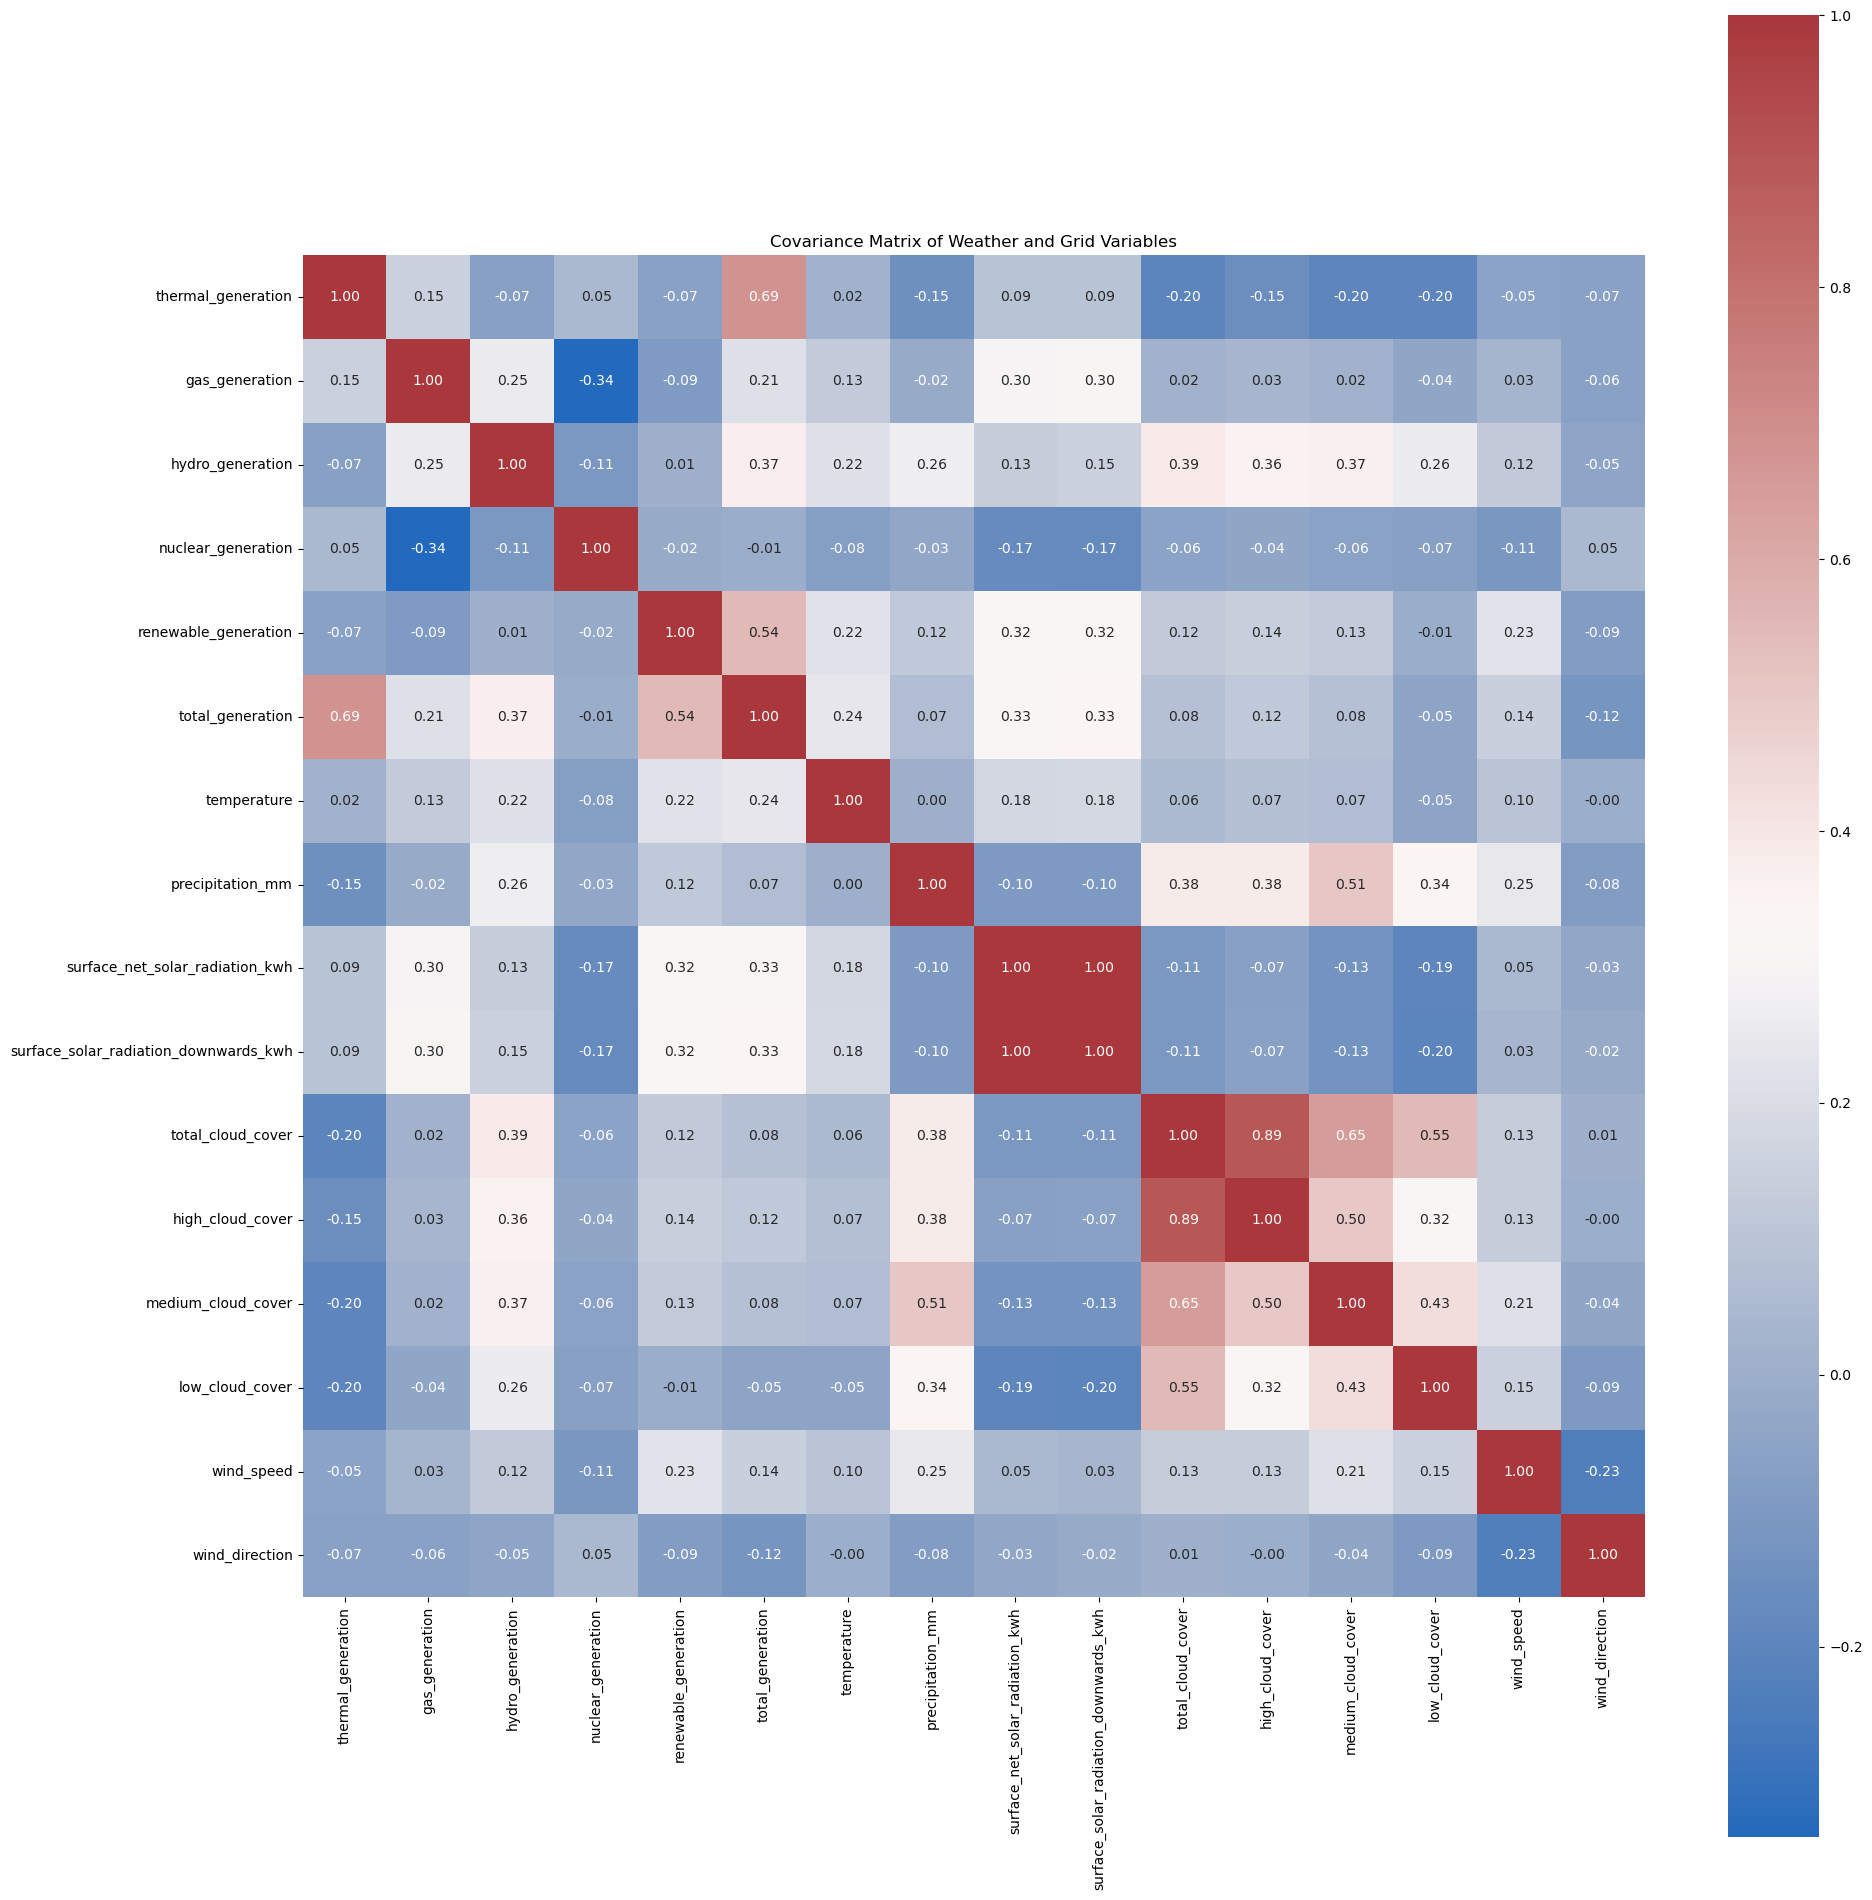

In [ ]:
# Check the correlation matrix of the combined DataFrame

print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf.select(
    pl.col( grid_predictor_vars + weather_predictor_vars),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [ ]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

/opt/homebrew/Caskroom/miniconda/base/envs/irpenv_3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 Variable         VIF
0                                   const  173.380860
1                      thermal_generation         inf
2                          gas_generation         inf
3                        hydro_generation         inf
4                      nuclear_generation         inf
5                    renewable_generation         inf
6                        total_generation         inf
7                             temperature    1.138471
8                        precipitation_mm    1.549627
9         surface_net_solar_radiation_kwh  184.785722
10  surface_solar_radiation_downwards_kwh  188.598116
11                      total_cloud_cover   10.374713
12                       high_cloud_cover    7.094458
13                     medium_cloud_cover    2.283669
14                        low_cloud_cover    2.086894
15                             wind_speed    1.233374
16                         wind_direction    1.120212


In [ ]:
colinear_columns_to_drop = [
    "surface_solar_radiation_downwards_kwh",  # Highly correlated with surface_net_solar_radiation_kwh
    "high_cloud_cover",  # Highly correlated with total_cloud_cover
    "medium_cloud_cover",  # Highly correlated with total_cloud_cover
    "low_cloud_cover",  # Highly correlated with total_cloud_cover
]

weather_predictor_vars = [col for col in weather_predictor_vars if col not in colinear_columns_to_drop]

In [ ]:
additional_cols_to_drop = [
    'thermal_generation', # not present in original analysis and highly correlated with total_generation
    'gas_generation',     # not present in original analysis and highly correlated with total_generation
    'hydro_generation',   # not present in original analysis and highly correlated with total_generation
    'nuclear_generation', # not present in original analysis and highly correlated with total_generation
    'renewable_generation', # not present in original analysis and highly correlated with total_generation
]

# Update grid_predictor_vars to exclude the additional columns
grid_predictor_vars = [col for col in grid_predictor_vars if col not in additional_cols_to_drop]


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


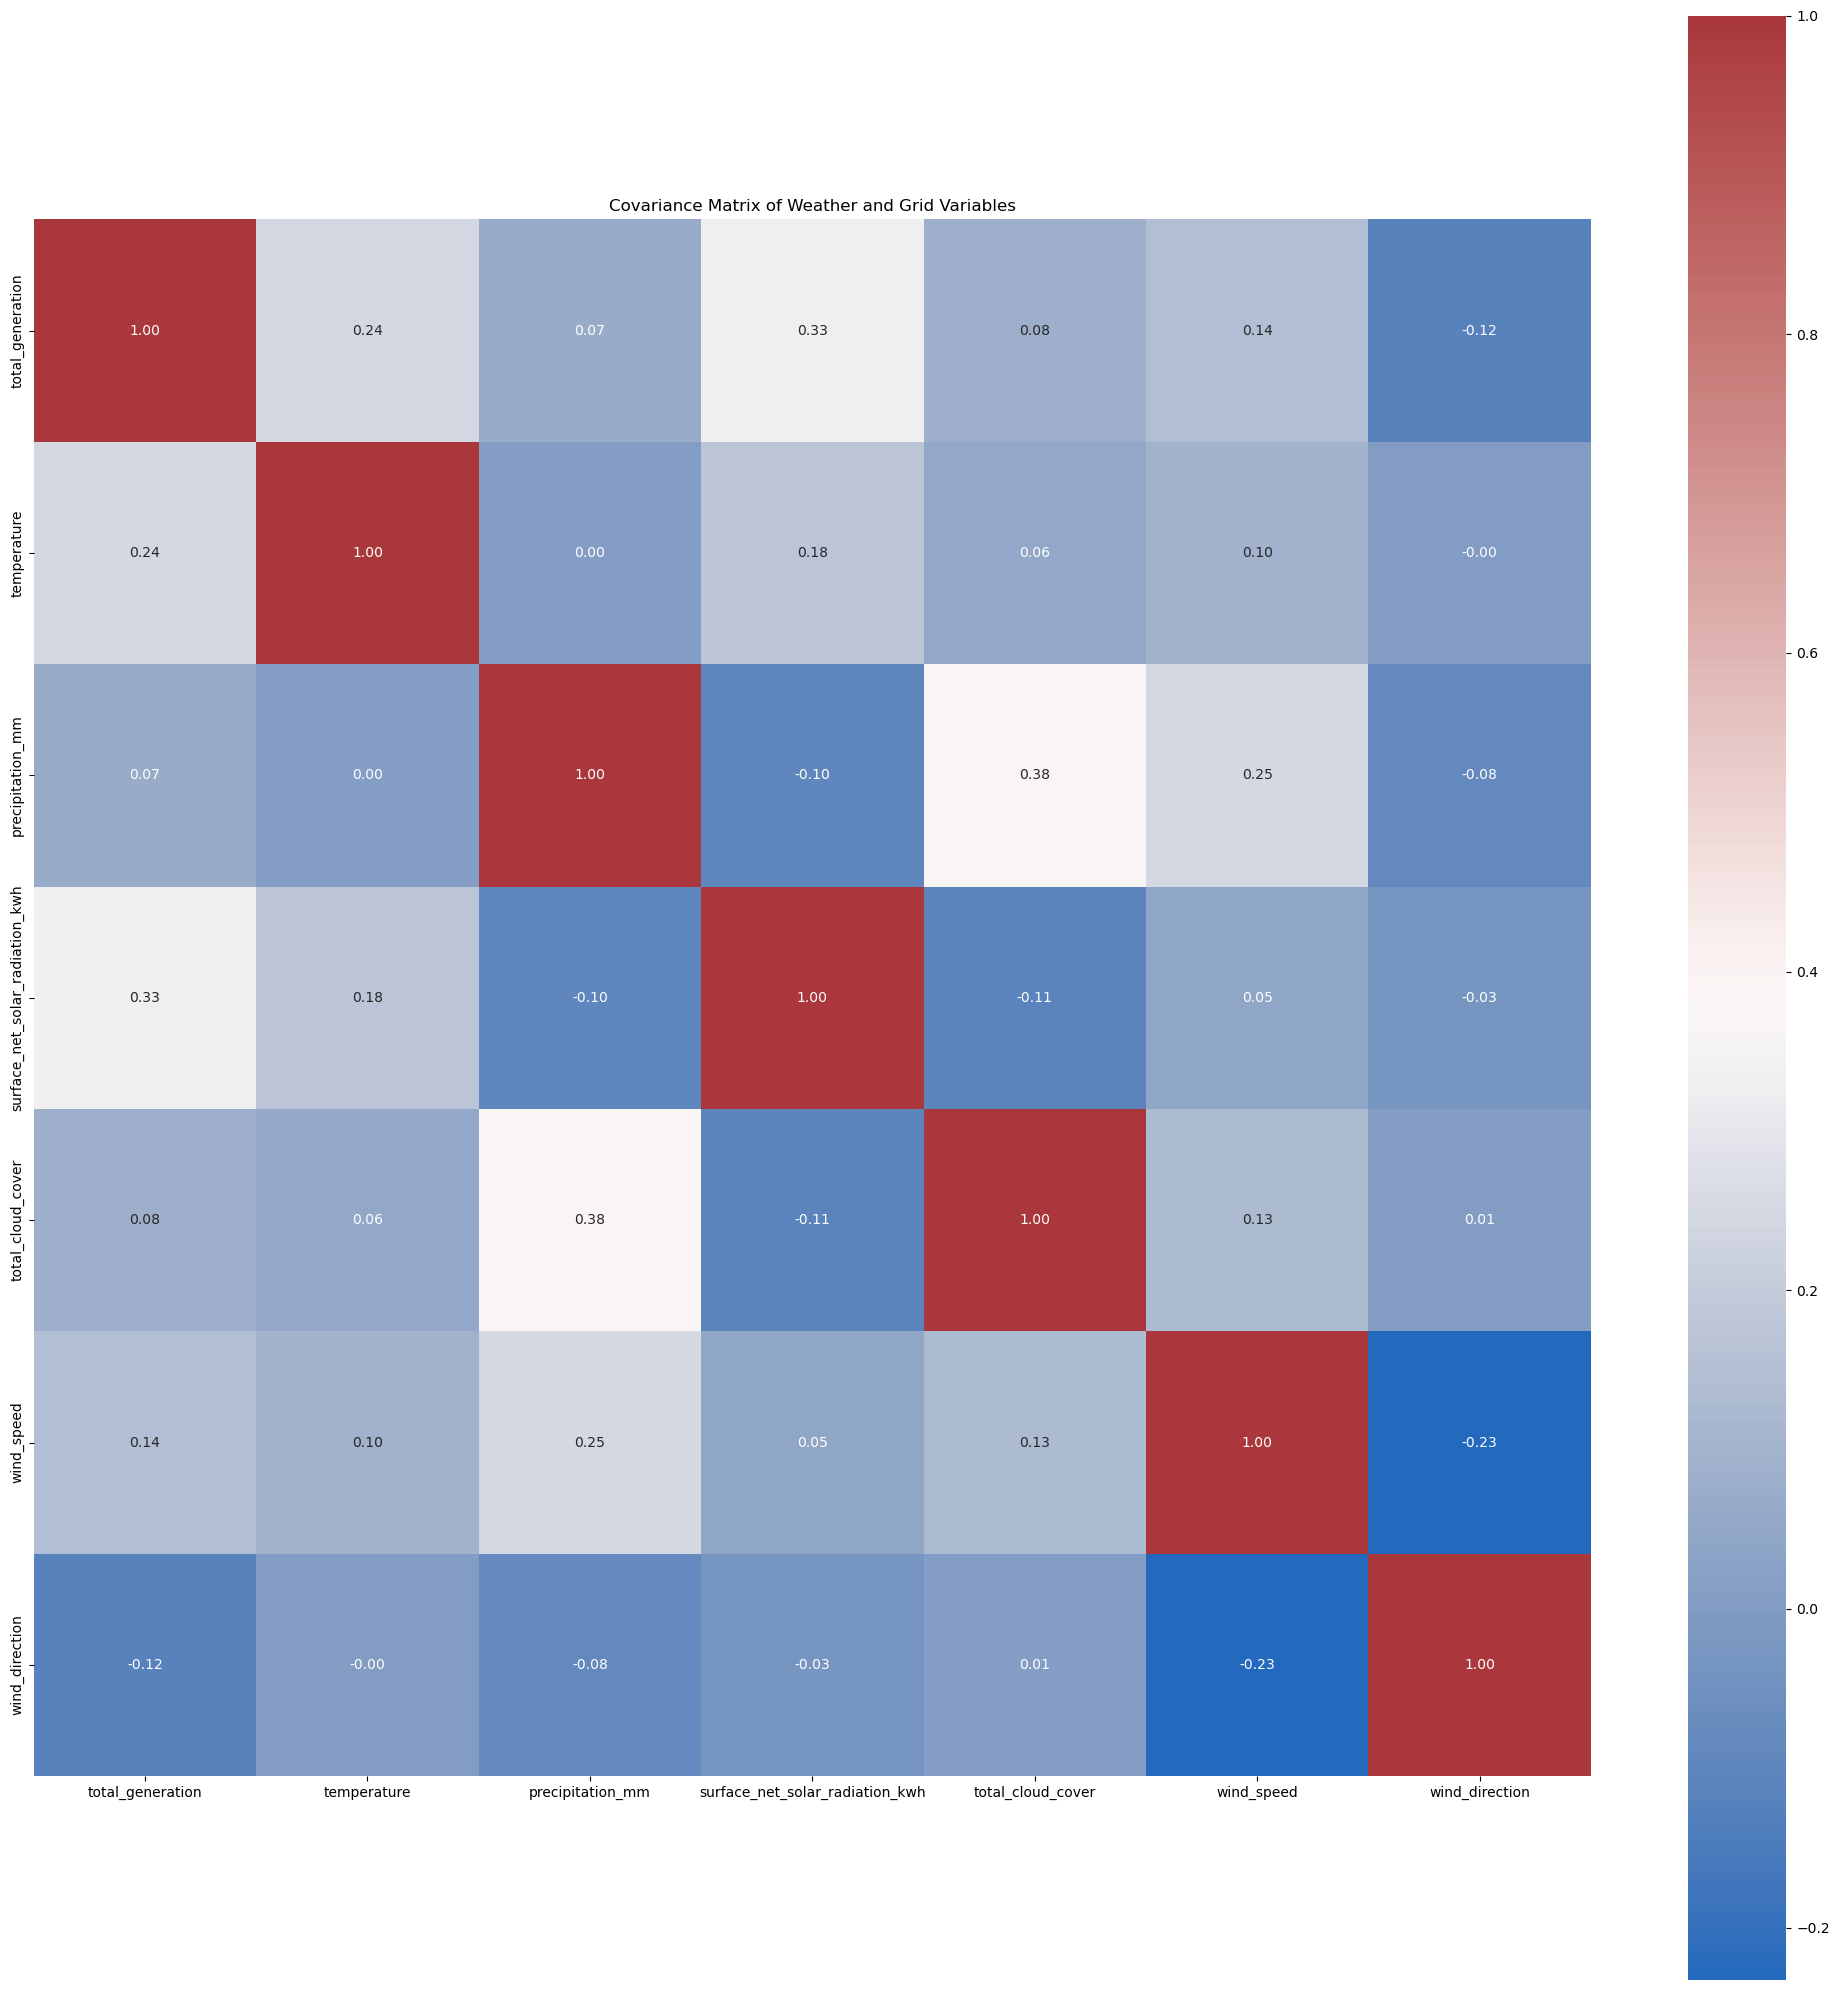

In [ ]:
# Check the correlation matrix of the combined DataFrame

print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf.select(
    pl.col( grid_predictor_vars + weather_predictor_vars),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [ ]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                          Variable        VIF
0                            const  77.476512
1                 total_generation   1.206520
2                      temperature   1.083020
3                 precipitation_mm   1.239949
4  surface_net_solar_radiation_kwh   1.164273
5                total_cloud_cover   1.198406
6                       wind_speed   1.141930
7                   wind_direction   1.072615


In [ ]:
print("\n" + "-" * 120)
print("Final Predictor Variables for Grid Readings and Weather Data:\n" + "-" * 120)
print(f"Helper Variables:\n\t{helper_vars}")
print("\nGrid Predictor Variables:")
print(f"\t{grid_predictor_vars}")
print("\nWeather Predictor Variables:")
print(f"\t{weather_predictor_vars}")
print("\nTarget Variable:")
print(f"\t[{target_var}]")


------------------------------------------------------------------------------------------------------------------------
Final Predictor Variables for Grid Readings and Weather Data:
------------------------------------------------------------------------------------------------------------------------
Helper Variables:
	['timestamp', 'weather_longitude', 'weather_latitude', 'city', 'era5_longitude', 'era5_latitude', 'distance_btwn_weather_and_era5_m', 'gap_filling']

Grid Predictor Variables:
	['total_generation']

Weather Predictor Variables:
	['temperature', 'precipitation_mm', 'surface_net_solar_radiation_kwh', 'total_cloud_cover', 'wind_speed', 'wind_direction']

Target Variable:
	[tons_co2]


In [ ]:
train_df = train_pldf.select(helper_vars + grid_predictor_vars + weather_predictor_vars + [target_var]).to_pandas()
validation_df = validation_pldf.select(helper_vars + grid_predictor_vars + weather_predictor_vars + [target_var]).to_pandas()
test_df = test_pldf.select(helper_vars + grid_predictor_vars + weather_predictor_vars + [target_var]).to_pandas()

### DRAFT - NEEDS REVIEW

######  asdffsdf

In [ ]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Take log(x + epsilon) of specified numeric columns in place.

    Parameters
    ----------
    columns : List[str]
        Names of numeric columns to log-transform.
    epsilon : float
        Small constant to avoid log(0).
    """
    def __init__(self, columns: List[str], epsilon: float = 1e-6):
        if not isinstance(columns, list) or not all(isinstance(c, str) for c in columns):
            raise ValueError("`columns` must be a list of strings")
        self.columns = columns
        self.epsilon = epsilon

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        for col in self.columns:
            if col not in df:
                raise ValueError(f"Column '{col}' not in DataFrame")
            df[col] = np.log(df[col] + self.epsilon)
        return df


In [ ]:
class PolynomialTransformer(BaseEstimator, TransformerMixin):
    """
    Add user-specified polynomial columns.

    Parameters
    ----------
    poly_specs : Dict[str, int]
        Mapping from column name → max degree.  For each (col, deg),
        this will add col^2, col^3, …, col^deg.
    """
    def __init__(self, poly_specs: Dict[str,int]):
        if not isinstance(poly_specs, dict) or not poly_specs:
            raise ValueError("`poly_specs` must be a non-empty dict")
        for col, deg in poly_specs.items():
            if not isinstance(col, str) or not isinstance(deg, int) or deg < 2:
                raise ValueError("Each key must be a str and each degree an int ≥ 2")
        self.poly_specs = poly_specs

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        for col, max_deg in self.poly_specs.items():
            if col not in df:
                raise ValueError(f"Column '{col}' not in DataFrame")
            for deg in range(2, max_deg + 1):
                new_col = f"{col}_pow{deg}"
                df[new_col] = df[col] ** deg
        return df


###### Helper Functions

In [ ]:
def run_groupwise_regression(
    df: pd.DataFrame,
    y_var: str = "tons_co2",
    x_vars: list[str] = ["total_generation", "total_generation_sqrd"],
    fe_vars: list[str] = ["month", "hour"],
    group_col: str = "combination",
    verbose: bool = True
) -> pd.DataFrame:
    """
    Run groupwise regressions with fixed effects and compute marginal effects.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe (must include group_col, X, Y, and FE variables).
    y_var : str
        The name of the target variable (Y).
    x_vars : list[str]
        List of predictor variables (X), must include a quadratic term if ME is desired.
    fe_vars : list[str]
        List of fixed effect variables (included with | in the formula).
    group_col : str
        Column containing group IDs (e.g., result of quantile or median binning).
    verbose : bool
        Whether to print progress and newly added column names.

    Returns
    -------
    dfout : pd.DataFrame
        Combined dataframe with original rows and estimated coefficients and marginal effects.
    """

    # Sanity checks
    required_cols = [y_var] + x_vars + fe_vars + [group_col]
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    dfout = pd.DataFrame()
    unique_groups = df[group_col].dropna().unique()
    new_columns = []

    for group in sorted(unique_groups):
        df_group = df[df[group_col] == group].copy()

        # Create regression formula
        x_formula = " + ".join(x_vars)
        fe_formula = " + ".join(fe_vars)
        formula = f"{y_var} ~ {x_formula} + C({fe_formula.replace('+', ')+C(')})"

        if verbose:
            print(f"Running regression for group '{group}' using formula:\n    {formula}")

        # Run OLS with categorical fixed effects
        model = smf.ols(formula=formula, data=df_group).fit()

        # Extract coefficients
        alpha1 = model.params.get(x_vars[0], float("nan"))
        alpha2 = model.params.get(x_vars[1], float("nan")) if len(x_vars) > 1 else 0.0

        df_group["alpha1"] = alpha1
        df_group["alpha2"] = alpha2
        df_group["marginal_effect"] = alpha1 + 2 * df_group[x_vars[0]] * alpha2

        dfout = pd.concat([dfout, df_group], axis=0)
        new_columns += ["alpha1", "alpha2", "marginal_effect"]

    if verbose:
        print(f"\nAdded columns: {sorted(set(new_columns))}")

    return dfout

###### Transformer Versions

In [ ]:
class ModelEvaluator:
    """
    Evaluate and compare different model configurations
    """
    def __init__(self):
        self.results = {}

    def evaluate_model(self, model_name: str, train_df: pd.DataFrame,
                      val_df: pd.DataFrame, test_df: pd.DataFrame,
                      pipeline: Pipeline) -> Dict:
        """
        Evaluate a model configuration on train/val/test sets
        """
        print(f"\n{'='*60}")
        print(f"EVALUATING MODEL: {model_name}")
        print(f"{'='*60}")

        results = {}

        # Fit and transform each dataset
        datasets = {'train': train_df, 'validation': val_df, 'test': test_df}

        for dataset_name, df in datasets.items():
            print(f"\nProcessing {dataset_name} set ({len(df)} observations)...")

            try:
                # Apply pipeline
                if dataset_name == 'train':
                    pipeline.fit(df)
                transformed_df = pipeline.transform(df)

                # Calculate evaluation metrics
                if 'ME' in transformed_df.columns and 'CO2' in transformed_df.columns:
                    # Overall dataset metrics
                    results[dataset_name] = {
                        'n_observations': len(transformed_df),
                        'n_groups': transformed_df['k'].nunique() if 'k' in transformed_df.columns else 0,
                        'avg_marginal_effect': transformed_df['ME'].mean(),
                        'std_marginal_effect': transformed_df['ME'].std(),
                        'min_marginal_effect': transformed_df['ME'].min(),
                        'max_marginal_effect': transformed_df['ME'].max(),
                        'avg_co2_intensity': transformed_df['tonsperMW'].mean() if 'tonsperMW' in transformed_df.columns else None
                    }

                    # Group-level analysis
                    if 'k' in transformed_df.columns:
                        group_stats = transformed_df.groupby('k').agg({
                            'ME': ['mean', 'std', 'count'],
                            'CO2': 'mean',
                            'Q': 'mean'
                        }).round(4)
                        results[f'{dataset_name}_group_stats'] = group_stats

                else:
                    results[dataset_name] = {'error': 'Missing required columns for evaluation'}

            except Exception as e:
                results[dataset_name] = {'error': str(e)}
                print(f"Error processing {dataset_name}: {str(e)}")

        self.results[model_name] = results
        return results

    def compare_models(self):
        """
        Compare results across different model configurations
        """
        if not self.results:
            print("No models to compare")
            return

        print(f"\n{'='*80}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*80}")

        comparison_data = []
        for model_name, model_results in self.results.items():
            for dataset in ['train', 'validation', 'test']:
                if dataset in model_results and 'error' not in model_results[dataset]:
                    row = {
                        'model': model_name,
                        'dataset': dataset,
                        **model_results[dataset]
                    }
                    comparison_data.append(row)

        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            print(comparison_df.round(4))
            return comparison_df
        else:
            print("No valid results to compare")
            return None

In [ ]:
def create_variable_combinations():
    """
    Define different combinations of weather variables to test
    """
    # Map your actual weather variable names to analysis names
    weather_var_mapping = {
        'v1': 'surface_net_solar_radiation_kwh',  # Solar
        'v2': 'wind_speed',                       # Wind speed
        'v3': 'temperature',                      # Temperature
        'v4': 'precipitation_mm',                 # Precipitation
        'v5': 'total_cloud_cover',               # Cloud cover
        'v6': 'wind_direction'                    # Wind direction (if needed)
    }

    # Define combinations to test
    combinations = [
        # Original R approach (2 variables)
        {
            'name': 'Original_Solar_Wind',
            'variables': ['v1', 'v2'],
            'description': 'Solar radiation + Wind speed (original R approach)'
        },

        # 3-variable combinations
        {
            'name': 'Solar_Wind_Temp',
            'variables': ['v1', 'v2', 'v3'],
            'description': 'Solar + Wind + Temperature'
        },
        {
            'name': 'Solar_Wind_Cloud',
            'variables': ['v1', 'v2', 'v5'],
            'description': 'Solar + Wind + Cloud cover'
        },
        {
            'name': 'Solar_Wind_Precip',
            'variables': ['v1', 'v2', 'v4'],
            'description': 'Solar + Wind + Precipitation'
        },

        # 4-variable combinations
        {
            'name': 'Solar_Wind_Temp_Cloud',
            'variables': ['v1', 'v2', 'v3', 'v5'],
            'description': 'Solar + Wind + Temperature + Cloud cover'
        },
        {
            'name': 'Solar_Wind_Temp_Precip',
            'variables': ['v1', 'v2', 'v3', 'v4'],
            'description': 'Solar + Wind + Temperature + Precipitation'
        },

        # 5-variable combination
        {
            'name': 'All_Weather_No_WindDir',
            'variables': ['v1', 'v2', 'v3', 'v4', 'v5'],
            'description': 'All weather except wind direction'
        }
    ]

    return combinations, weather_var_mapping


In [ ]:

def create_pipeline_for_combination(combination: Dict, binning_method: str = 'quantile',
                                  n_quantiles: int = 5, verbose: bool = False):
    """
    Create a pipeline for a specific variable combination
    """
    variables = combination['variables']

    if binning_method == 'quantile':
        binner = FlexibleQuantileBinner(variables=variables, n_quantiles=n_quantiles)
        expected_groups = n_quantiles ** len(variables)
    elif binning_method == 'median':
        binner = FlexibleMedianBinner(variables=variables)
        expected_groups = 2 ** len(variables)
    else:
        raise ValueError("binning_method must be 'quantile' or 'median'")

    pipeline_name = f"{combination['name']}_{binning_method}"

    if verbose:
        print(f"Creating pipeline: {pipeline_name}")
        print(f"  Variables: {variables}")
        print(f"  Expected groups: {expected_groups}")
        print(f"  Description: {combination['description']}")

    return Pipeline([
        ('analysis_features', EnhancedRAnalysisFeatureAdder()),
        ('binner', binner),
        ('groupwise_regression', ImprovedGroupwiseRegression(
            y_var='CO2', x_vars=['Q', 'Q2'], fe_vars=['mo', 'h'],
            group_col='k', verbose=verbose))
    ]), expected_groups


In [ ]:
class ComprehensiveModelEvaluator:
    """
    Enhanced evaluator for testing multiple variable combinations
    """
    def __init__(self):
        self.results = {}
        self.summary_stats = {}

    def run_comprehensive_evaluation(self, train_df: pd.DataFrame,
                                   val_df: pd.DataFrame, test_df: pd.DataFrame,
                                   binning_methods: List[str] = ['quantile', 'median'],
                                   n_quantiles: int = 5, max_variables: int = 5,
                                   verbose: bool = True):
        """
        Run evaluation across multiple variable combinations and binning methods
        """
        combinations, var_mapping = create_variable_combinations()

        # Filter combinations by max_variables
        filtered_combinations = [c for c in combinations if len(c['variables']) <= max_variables]

        print(f"Testing {len(filtered_combinations)} variable combinations with {len(binning_methods)} binning methods")
        print(f"Total pipeline configurations: {len(filtered_combinations) * len(binning_methods)}")

        results_summary = []

        for combination in filtered_combinations:
            n_vars = len(combination['variables'])

            for binning_method in binning_methods:
                pipeline_name = f"{combination['name']}_{binning_method}"

                # Skip combinations that would create too many groups
                if binning_method == 'quantile':
                    expected_groups = n_quantiles ** n_vars
                    if expected_groups > 1000:  # Reasonable threshold
                        print(f"Skipping {pipeline_name}: too many groups ({expected_groups})")
                        continue

                try:
                    print(f"\n{'='*80}")
                    print(f"TESTING: {pipeline_name}")
                    print(f"Variables: {combination['variables']} ({combination['description']})")

                    # Create pipeline
                    pipeline, expected_groups = create_pipeline_for_combination(
                        combination, binning_method, n_quantiles, verbose=False
                    )

                    print(f"Expected groups: {expected_groups}")

                    # Evaluate model
                    model_results = self.evaluate_single_model(
                        pipeline_name, train_df, val_df, test_df, pipeline
                    )

                    # Extract key metrics for summary
                    if 'train' in model_results and 'error' not in model_results['train']:
                        summary_row = {
                            'model_name': pipeline_name,
                            'n_variables': n_vars,
                            'variables': ', '.join(combination['variables']),
                            'binning_method': binning_method,
                            'expected_groups': expected_groups,
                            'actual_groups': model_results['train'].get('n_groups', 0),
                            'train_obs': model_results['train'].get('n_observations', 0),
                            'val_obs': model_results['validation'].get('n_observations', 0),
                            'test_obs': model_results['test'].get('n_observations', 0),
                            'train_avg_me': model_results['train'].get('avg_marginal_effect', np.nan),
                            'val_avg_me': model_results['validation'].get('avg_marginal_effect', np.nan),
                            'test_avg_me': model_results['test'].get('avg_marginal_effect', np.nan),
                            'train_std_me': model_results['train'].get('std_marginal_effect', np.nan),
                            'val_std_me': model_results['validation'].get('std_marginal_effect', np.nan),
                            'test_std_me': model_results['test'].get('std_marginal_effect', np.nan),
                        }
                        results_summary.append(summary_row)

                except Exception as e:
                    print(f"ERROR in {pipeline_name}: {str(e)}")
                    continue

        # Create comprehensive summary
        if results_summary:
            self.summary_stats = pd.DataFrame(results_summary)
            self.print_comprehensive_summary()
            return self.summary_stats
        else:
            print("No successful model evaluations completed")
            return None

    def evaluate_single_model(self, model_name: str, train_df: pd.DataFrame,
                            val_df: pd.DataFrame, test_df: pd.DataFrame,
                            pipeline: Pipeline) -> Dict:
        """
        Evaluate a single model configuration
        """
        results = {}
        datasets = {'train': train_df, 'validation': val_df, 'test': test_df}

        for dataset_name, df in datasets.items():
            try:
                # Apply pipeline
                if dataset_name == 'train':
                    pipeline.fit(df)
                transformed_df = pipeline.transform(df)

                # Calculate evaluation metrics
                if 'ME' in transformed_df.columns and 'CO2' in transformed_df.columns:
                    results[dataset_name] = {
                        'n_observations': len(transformed_df),
                        'n_groups': transformed_df['k'].nunique() if 'k' in transformed_df.columns else 0,
                        'avg_marginal_effect': transformed_df['ME'].mean(),
                        'std_marginal_effect': transformed_df['ME'].std(),
                        'min_marginal_effect': transformed_df['ME'].min(),
                        'max_marginal_effect': transformed_df['ME'].max(),
                        'median_marginal_effect': transformed_df['ME'].median(),
                        'q25_marginal_effect': transformed_df['ME'].quantile(0.25),
                        'q75_marginal_effect': transformed_df['ME'].quantile(0.75),
                        'avg_co2_intensity': transformed_df['tonsperMW'].mean() if 'tonsperMW' in transformed_df.columns else None
                    }
                else:
                    results[dataset_name] = {'error': 'Missing required columns'}

            except Exception as e:
                results[dataset_name] = {'error': str(e)}

        self.results[model_name] = results
        return results

    def print_comprehensive_summary(self):
        """
        Print a comprehensive summary of all model results
        """
        if self.summary_stats is None or len(self.summary_stats) == 0:
            print("No results to summarize")
            return

        print(f"\n{'='*100}")
        print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
        print(f"{'='*100}")

        # Group by number of variables
        for n_vars in sorted(self.summary_stats['n_variables'].unique()):
            subset = self.summary_stats[self.summary_stats['n_variables'] == n_vars]
            print(f"\n{'-'*60}")
            print(f"{n_vars}-VARIABLE MODELS ({len(subset)} configurations)")
            print(f"{'-'*60}")

            display_cols = ['model_name', 'actual_groups', 'train_obs', 'train_avg_me', 'val_avg_me', 'test_avg_me']
            print(subset[display_cols].round(4).to_string(index=False))

        # Overall statistics
        print(f"\n{'-'*60}")
        print("OVERALL STATISTICS")
        print(f"{'-'*60}")
        print(f"Models tested: {len(self.summary_stats)}")
        print(f"Variable combinations: {self.summary_stats['n_variables'].value_counts().sort_index()}")
        print(f"Avg marginal effect range: {self.summary_stats['train_avg_me'].min():.4f} to {self.summary_stats['train_avg_me'].max():.4f}")

        # Best/worst models by marginal effect stability (lowest std dev)
        print(f"\nMost stable models (lowest ME std dev on validation):")
        stable_models = self.summary_stats.nsmallest(3, 'val_std_me')[['model_name', 'val_avg_me', 'val_std_me']]
        print(stable_models.round(4).to_string(index=False))

    def get_best_models(self, criteria: str = 'stability', n_models: int = 5) -> pd.DataFrame:
        """
        Get best models according to specified criteria

        Parameters:
        -----------
        criteria : str
            'stability' - lowest std dev of marginal effects
            'magnitude' - highest average marginal effects
            'consistency' - smallest difference between train/val marginal effects
        """
        if self.summary_stats is None or len(self.summary_stats) == 0:
            return pd.DataFrame()

        df = self.summary_stats.copy()

        if criteria == 'stability':
            # Lowest standard deviation of marginal effects on validation set
            best = df.nsmallest(n_models, 'val_std_me')
        elif criteria == 'magnitude':
            # Highest average marginal effects on validation set
            best = df.nlargest(n_models, 'val_avg_me')
        elif criteria == 'consistency':
            # Smallest difference between train and validation marginal effects
            df['train_val_diff'] = abs(df['train_avg_me'] - df['val_avg_me'])
            best = df.nsmallest(n_models, 'train_val_diff')
        else:
            raise ValueError("criteria must be 'stability', 'magnitude', or 'consistency'")

        return best

    def plot_results(self, save_path: Optional[str] = None):
        """
        Create visualizations of model comparison results
        """
        if self.summary_stats is None or len(self.summary_stats) == 0:
            print("No results to plot")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Average Marginal Effect by Number of Variables
        axes[0,0].boxplot([self.summary_stats[self.summary_stats['n_variables']==n]['val_avg_me'].values
                          for n in sorted(self.summary_stats['n_variables'].unique())])
        axes[0,0].set_xlabel('Number of Variables')
        axes[0,0].set_ylabel('Average Marginal Effect (Validation)')
        axes[0,0].set_title('Marginal Effect by Model Complexity')
        axes[0,0].set_xticklabels(sorted(self.summary_stats['n_variables'].unique()))

        # Plot 2: Stability (Std Dev) vs Average ME
        axes[0,1].scatter(self.summary_stats['val_avg_me'], self.summary_stats['val_std_me'],
                         c=self.summary_stats['n_variables'], cmap='viridis', alpha=0.7)
        axes[0,1].set_xlabel('Average Marginal Effect')
        axes[0,1].set_ylabel('Std Dev Marginal Effect')
        axes[0,1].set_title('Stability vs Magnitude Trade-off')
        plt.colorbar(axes[0,1].scatter(self.summary_stats['val_avg_me'], self.summary_stats['val_std_me'],
                                      c=self.summary_stats['n_variables'], cmap='viridis'),
                    ax=axes[0,1], label='# Variables')

        # Plot 3: Train vs Validation Consistency
        axes[1,0].scatter(self.summary_stats['train_avg_me'], self.summary_stats['val_avg_me'],
                         c=self.summary_stats['n_variables'], cmap='viridis', alpha=0.7)
        axes[1,0].plot([self.summary_stats['train_avg_me'].min(), self.summary_stats['train_avg_me'].max()],
                      [self.summary_stats['train_avg_me'].min(), self.summary_stats['train_avg_me'].max()],
                      'r--', alpha=0.5)
        axes[1,0].set_xlabel('Train Average ME')
        axes[1,0].set_ylabel('Validation Average ME')
        axes[1,0].set_title('Train-Validation Consistency')

        # Plot 4: Number of Groups vs Performance
        axes[1,1].scatter(self.summary_stats['actual_groups'], self.summary_stats['val_avg_me'],
                         c=self.summary_stats['n_variables'], cmap='viridis', alpha=0.7)
        axes[1,1].set_xlabel('Number of Groups')
        axes[1,1].set_ylabel('Average Marginal Effect')
        axes[1,1].set_title('Model Complexity vs Performance')
        axes[1,1].set_xscale('log')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

In [ ]:
def run_comprehensive_model_evaluation(train_df: pd.DataFrame, validation_df: pd.DataFrame,
                                     test_df: pd.DataFrame, max_variables: int = 4,
                                     n_quantiles: int = 5, verbose: bool = True):
    """
    Run comprehensive evaluation of multiple model configurations
    """
    evaluator = ComprehensiveModelEvaluator()

    # Run all combinations
    summary_df = evaluator.run_comprehensive_evaluation(
        train_df, validation_df, test_df,
        binning_methods=['quantile', 'median'],
        n_quantiles=n_quantiles,
        max_variables=max_variables,
        verbose=verbose
    )

    if summary_df is not None:
        # Get best models by different criteria
        print(f"\n{'='*80}")
        print("BEST MODELS BY DIFFERENT CRITERIA")
        print(f"{'='*80}")

        for criteria in ['stability', 'consistency', 'magnitude']:
            print(f"\nBest models by {criteria}:")
            best_models = evaluator.get_best_models(criteria=criteria, n_models=3)
            display_cols = ['model_name', 'n_variables', 'val_avg_me', 'val_std_me']
            print(best_models[display_cols].round(4).to_string(index=False))

        # Create visualizations
        evaluator.plot_results()

    return evaluator, summary_df

###### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('analysis_feature_adder', AnalysisFeatureAdder()),
    ('multi_quantile_binner', MultiQuantileBinner(
        bin_specs={
            'total_generation': 5,
            'temperature': 5,
            'precipitation_mm': 5,
            'surface_net_solar_radiation_kwh': 5,
            'total_cloud_cover': 5,
            'wind_speed': 5,
            'wind_direction': 5
        },
        prefix='q'
    )),
    ('median_group_binner', MedianGroupBinner(
        columns=['total_generation', 'temperature', 'precipitation_mm',
                 'surface_net_solar_radiation_kwh', 'total_cloud_cover',
                 'wind_speed', 'wind_direction'],
        prefix='median'
    )),
    ('marginal_emissions', GroupwiseRegressionTransformer(
        y_var='tons_co2',
        x_vars=['total_generation', 'total_generation_sqrd'],
        fe_vars=['month', 'hour'],
        group_col='combination',
        verbose=True
    ))
])

TypeError: __init__() got an unexpected keyword argument 'prefix'

In [ ]:
# Step 2: Define features and target
X_train = train_df[grid_predictor_vars + weather_predictor_vars]
y_train = train_df[target_var]

X_val = validation_df[grid_predictor_vars + weather_predictor_vars]
y_val = validation_df[target_var]

X_test = test_df[grid_predictor_vars + weather_predictor_vars]
y_test = test_df[target_var]

# Step 3: Build pipeline
numeric_features = grid_predictor_vars + weather_predictor_vars

In [ ]:
# Split the combined DataFrame into training, validation, and test sets based on the revised dates

## Analysis

why do we create weather bins?

median splits - why would we do this


For the regression model - > what is the purpose of this - to find the relationship between marginal emission factors and weather?
- If so teyn wouldn't it potentiall ybe worth it to build other models? Neural Networks?

what is phi_t in this case? the delta t

Why are the log transfomations even there?


what doesn this mean?

"Instead of binning weather, use it as continuous controls:"


Use proper FE methods

linearmodels.PanelOLS or statsmodels with dummy vars for hour, month are these feature engineering?

###### OLD JUNK

In [ ]:
def downselect_features(dataframe, variables_to_keep):
    """
    Downselect features in a DataFrame based on a list of variables to keep.

    Parameters:
    ----------
    df : pl.DataFrame or pd.DataFrame
        Input DataFrame containing various features.

    variables_to_keep : list
        List of variable names to retain in the DataFrame.

    Returns:
    -------
    pl.DataFrame or pd.DataFrame
        DataFrame with only the specified variables retained.
    """
    return dataframe[variables_to_keep]


In [ ]:
def add_multi_quantile_bins(df: pd.DataFrame, bin_specs: dict[str, int],prefix: str = "q") -> pd.DataFrame:
    """
    Add quantile bin columns and a combined group ID ('k') based on multiple variables.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    bin_specs : dict
        Dictionary mapping column names to the number of quantile bins (e.g., {'v1': 5, 'v2': 5}).
    prefix : str
        Prefix for the quantile bin columns (default is 'q').

    Returns
    -------
    df : pd.DataFrame
        DataFrame with quantile bin columns and a combined group column `combination`.
    """
    df = df.copy()

    missing_cols = [col for col in bin_specs if col not in df.columns]
    if missing_cols:
           raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

    bin_columns = []

    for col, n_bins in bin_specs.items():
        bin_col = f"{prefix}_{col}_bin"
        df[bin_col] = pd.qcut(df[col], q=n_bins, labels=False, duplicates='drop') + 1
        bin_columns.append((bin_col, n_bins))

    # Compute a combined group index (like a base-n encoder)
    df['quartile_group'] = 0
    multiplier = 1
    for bin_col, n_bins in reversed(bin_columns):
        df['quartile_group'] += (df[bin_col] - 1) * multiplier
        multiplier *= n_bins

    df['quartile_group'] += 1  # match 1-based indexing from R (k = 1 to N)

    return df


In [ ]:

def add_median_groups(df: pd.DataFrame, columns: list[str], prefix: str = "median") -> pd.DataFrame:
    """
    Add binary Above/Below Median groupings for specified columns and create a combined group label 'combination'.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    columns : list[str]
        List of column names to group by median value.
    prefix : str
        Optional prefix for new group columns.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with binary group columns and a combined 'combination' group label.
    """
    df = df.copy()

    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

    group_cols = []

    for col in columns:
        median_val = df[col].median(skipna=True)
        new_col = f"{prefix}_{col}_group"
        df[new_col] = np.where(df[col] > median_val, "Above Median", "Below Median")
        group_cols.append(new_col)

    # Create unique group combinations using strings like "Group 1", "Group 2", ...
    df["median_group"] = df[group_cols].agg("-".join, axis=1)
    unique_groups = {val: f"Group {i+1}" for i, val in enumerate(sorted(df["median_group"].unique()))}
    df["median_group"] = df["median_group"].map(unique_groups)

    return df
